# **Fine-tuning LLM Agent with Online Reinforcement Learning** #
## **Authors: Fiona Chow, Christine Gao, Xinyue Ma** ##

### Introduction

- Training RL agents from scratch makes them align with the
environments, but it does not incorporate prior knowledge to
help with the learning process.

- Hypothesis: We can use a pre-trained LLM is as the starting policy, and
fine-tuning that LLM with online RL should make the learning more
efficient due to prior knowledge that the LLM has.

### Environment

Gym XiangQi (Chinese Chess)

Xiang Qi, also known as Chinese chess is a traditional game originated from China. Xiang Qi is similar in many respect to Chess, but is arguably more complicated. It has a higher branching factor, and each of the pieces has more restrictions as compared to Chess.

In [ ]:
!pip install gym-xiangqi

In [ ]:
import gym
from gym_xiangqi.agents import RandomAgent
from gym_xiangqi.constants import ALLY, PIECE_ID_TO_NAME, PIECE_POINTS,  ENEMY
from gym_xiangqi.utils import action_space_to_move, move_to_action_space
import numpy as np
import time
import matplotlib.pyplot as plt

env = gym.make('gym_xiangqi:xiangqi-v0')

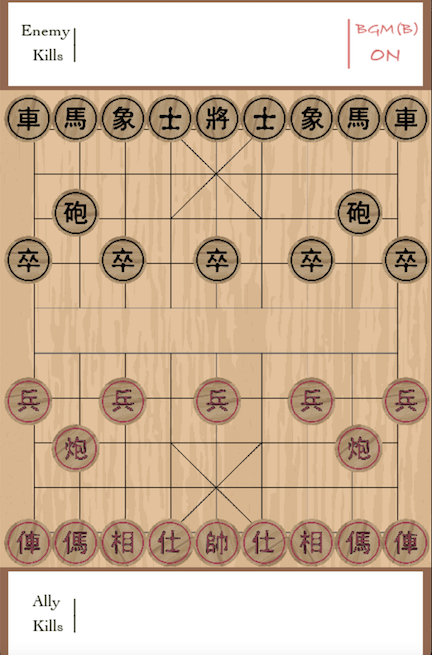


### States / Observation space
The game setup consists of a grid measuring 10 by 9 squares, where two players participate. Each player controls 16 pieces, distinguished by positive and negative values to denote ownership.


### The Pieces
Each player starts off with 1 general, 2 advisors, 2 elephants, 2 horses, 2 chariots, 2 cannons and 5 soldiers.

### The Rules
The game starts off with the position as shown in the image. Generally, the red pieces will get to move first. The game ends when either sides have no more moves to save the general piece from being taken in the next move, similar to checkmating the king in chess.



In [ ]:
#show states/observation space
env.observation_space

In [ ]:
#2 dimensional numpy array representing current board state
env.reset()
env.state

array([[ -9,  -7,  -5,  -3,  -1,  -2,  -4,  -6,  -8],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, -11,   0,   0,   0,   0,   0, -10,   0],
       [-16,   0, -15,   0, -14,   0, -13,   0, -12],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 12,   0,  13,   0,  14,   0,  15,   0,  16],
       [  0,  10,   0,   0,   0,   0,   0,  11,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  8,   6,   4,   2,   1,   3,   5,   7,   9]])


### Actions
 The action space encompasses all potential moves, including those that are invalid. Each action is defined by three pieces of information: the specific piece being moved, its starting position (10 * 9 grid), and its destination (10 * 9 grid). Therefore, 16 pieces * 10 * 9 * 10 * 9 = 129,600

In [ ]:
#show actions
env.action_space

Discrete(129600)

### Goal Function
The primary goal for an agent in this environment is to maximize its cumulative reward, which is aligned with achieving a victory in the game of Xiangqi.

### Reward Function
 - The reward function is designed to provide immediate feedback for each move.
 - Specific rewards are assigned to various actions: capturing a piece yields points equivalent to the value of the piece captured (e.g., capturing a general grants 100 points, chariot 9 points, horse 4 points, etc.), promoting strategic play and effective capture of high-value pieces.
 - An illegal move results in a penalty of -10 points, discouraging the agent from making such moves.
 - The ultimate rewards are given for winning (+100 points) and losing the game (-100 points), directly tying the agent's performance to the standard game outcomes.

### Evaluation
- Win Rates
- Reward per episode
- Episode length
- Reward variability


In [ ]:
# functions for all the evaluation metrics

def calculate_win_rate(wins, total_games):
    return (wins / total_games) * 100 if total_games > 0 else 0

def average_reward(rewards):
    """
    Average reward of winning agent
    """
    return sum(rewards) / len(rewards) if rewards else 0

def average_episode_length(rounds_list):
    return sum(rounds_list) / len(rounds_list) if rounds_list else 0

def reward_variability(rewards):
    return np.std(rewards)


In [ ]:
# functions for evaluation visualizations

def plot_episode_lengths(episode_lengths, window_size=3, ally="Greedy", enemy="Random"):
    """
    Plots the lengths of each episode and includes a moving average line to highlight trends.

    """
    plt.figure(figsize=(10, 5))
    episodes = range(1, len(episode_lengths) + 1)

    moving_average = np.convolve(episode_lengths, np.ones(window_size) / window_size, mode='valid')
    plt.plot(range(window_size, len(episode_lengths) + 1), moving_average, color='red', label='Moving Average')

    plt.title(f'Episode Lengths Over Games ({ally} vs {enemy})')
    plt.xlabel('Episode Number')
    plt.ylabel('Episode Length')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_episode_rewards(ally_rewards, enemy_rewards, window_size=3, ally="Greedy", enemy="Random"):
    """
    Plots the cumulative rewards for ally and enemy agents over episodes, including moving averages.

    Parameters:
    - ally_rewards (list): A list of floats representing the cumulative rewards for each episode by the ally agent.
    - enemy_rewards (list): A list of floats representing the cumulative rewards for each episode by the enemy agent.
    - window_size (int): The size of the window used for the moving average calculation.
    """
    plt.figure(figsize=(10, 5))

    episodes = range(1, len(enemy_rewards) + 1)


    ally_ma = np.convolve(ally_rewards, np.ones(window_size) / window_size, mode='valid')
    plt.plot(range(window_size, len(ally_rewards) + 1), ally_ma, color='cyan', label=f'{ally} Moving Average')


    enemy_ma = np.convolve(enemy_rewards, np.ones(window_size) / window_size, mode='valid')
    plt.plot(range(window_size, len(enemy_rewards) + 1), enemy_ma, color='lime', label=f'{enemy} Moving Average')

    plt.title(f'Episode Rewards Over Games ({ally} vs {enemy}) ')
    plt.xlabel('Episode Number')
    plt.ylabel('Cumulative Reward')
    plt.legend()
    plt.grid(True)
    plt.show()


### Test Case 1: Create a Random Agent

The gym-xiangqi library includes a random agent and script for a game between random agents.

This script simulates a game of Xiangqi where a random agent makes moves in the environment against another random agent until the game ends, logging each move's details.

Let's start by running this script to familiarize ourselves with the game set up.

In [ ]:
agent = RandomAgent()

env.reset()
done = False
round = 0

while not done:
  # Add a slight delay to properly visualize the game.
  # time.sleep(1)

  turn = "Ally" if env.turn == ALLY else "Enemy"
  action = agent.move(env)
  _, reward, done, _ = env.step(action)
  move = action_space_to_move(action)
  piece = PIECE_ID_TO_NAME[move[0]]

  print(f"Round: {round}")
  print(f"{turn} made the move {piece} from {move[1]} to {move[2]}.")
  print(f"Reward: {reward}")
  print("================")

  round += 1
  # env.render()
env.close()

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):


Round: 0
Ally made the move CANNON_2 from [7, 7] to [3, 7].
Reward: 0.0
Round: 1
Enemy made the move HORSE_2 from [0, 1] to [2, 0].
Reward: 0.0
Round: 2
Ally made the move CANNON_1 from [7, 1] to [7, 4].
Reward: 0.0
Round: 3
Enemy made the move CANNON_1 from [2, 7] to [2, 3].
Reward: 0.0
Round: 4
Ally made the move CHARIOT_2 from [9, 8] to [7, 8].
Reward: 0.0
Round: 5
Enemy made the move CANNON_1 from [2, 3] to [4, 3].
Reward: 0.0
Round: 6
Ally made the move SOLDIER_1 from [6, 0] to [5, 0].
Reward: 0.0
Round: 7
Enemy made the move CANNON_1 from [4, 3] to [2, 3].
Reward: 0.0
Round: 8
Ally made the move CHARIOT_1 from [9, 0] to [6, 0].
Reward: 0.0
Round: 9
Enemy made the move CANNON_1 from [2, 3] to [7, 3].
Reward: 0.0
Round: 10
Ally made the move CANNON_2 from [3, 7] to [4, 7].
Reward: 0.0
Round: 11
Enemy made the move CANNON_2 from [2, 1] to [2, 5].
Reward: 0.0
Round: 12
Ally made the move CANNON_2 from [4, 7] to [5, 7].
Reward: 0.0
Round: 13
Enemy made the move CANNON_2 from [2, 5] to

The game ended after 155 rounds with the 'enemy' random agent winning the game and achieving a reward of 100 points.

Now let's try running this configuration of random vs random agents for a few games.

In [ ]:
# Initialize the agent
random_agent = RandomAgent()

# Variables to track wins
ally_wins = 0
enemy_wins = 0
truncated_game = 0
num_games = 12

episode_lengths = []
ally_rewards = []
enemy_rewards = []
winning_rewards = []

for game in range(num_games):
    obs = env.reset()
    done = False
    round = 0
    current_ally_rewards = 0
    current_enemy_rewards = 0

    print(f"\nStarting game {game + 1}")

    while not done:
        print(f"Game {game + 1}, Round {round + 1}")

        turn = "Ally" if env.turn == ALLY else "Enemy"
        action = random_agent.move(env)
        obs, reward, done, _ = env.step(action)

        # Accumulate rewards based on who is playing
        if turn == "Ally":
          current_ally_rewards += reward
        else:
          current_enemy_rewards += reward

        move = action_space_to_move(action)
        piece = PIECE_ID_TO_NAME[move[0]]

        print(f"{turn} made the move {piece} from {move[1]} to {move[2]}. Reward: {reward}")
        print("================")

        round += 1

        # To prevent infinite loops
        if round >= 200:
            print("Game reached 200 rounds, stopping to prevent infinite loop.")
            done = True
            truncated_game += 1

    episode_lengths.append(round)

    print(f'current_ally_rewards:{current_ally_rewards}')
    print(f'current_enemy_rewards:{current_enemy_rewards}')

    # Determine the winner based on the last turn and reward
    if reward == 100:
        if turn == "Ally":
            ally_wins += 1
            winning_rewards.append(current_ally_rewards)
        elif turn == "Enemy":
            enemy_wins += 1
            winning_rewards.append(current_enemy_rewards)

    print(f"Game {game + 1} ended. Ally Wins: {ally_wins}, Enemy Wins: {enemy_wins}, Truncated Game: {truncated_game} ")

    ally_rewards.append(current_ally_rewards)
    enemy_rewards.append(current_enemy_rewards)

env.close()

print(f"\nFinal score after {num_games} games -> Ally Wins: {ally_wins}, Enemy Wins: {enemy_wins}, Truncated Game: {truncated_game}")
print(f"Ally Win Rate: {calculate_win_rate(ally_wins, num_games)}%")
print(f"Enemy Win Rate: {calculate_win_rate(enemy_wins, num_games)}%")
print(f"Truncated Rate: {calculate_win_rate(truncated_game, num_games)}%")
print(f"Average Winning Reward per Episode: {average_reward(winning_rewards)}")
print(f"Average Episode Length: {average_episode_length(episode_lengths)}")
print(f"Ally Reward Variability: {reward_variability(ally_rewards)}")
print(f"Enemy Reward Variability: {reward_variability(enemy_rewards)}")

Streaming output truncated to the last 5000 lines.
Game 3, Round 71
Ally made the move CANNON_2 from [0, 5] to [6, 5]. Reward: 0.0
Game 3, Round 72
Enemy made the move CHARIOT_1 from [0, 8] to [2, 8]. Reward: 0.0
Game 3, Round 73
Ally made the move HORSE_2 from [2, 6] to [3, 4]. Reward: 0.0
Game 3, Round 74
Enemy made the move SOLDIER_3 from [5, 4] to [6, 4]. Reward: 0.0
Game 3, Round 75
Ally made the move CHARIOT_1 from [9, 0] to [6, 0]. Reward: 0.0
Game 3, Round 76
Enemy made the move CANNON_1 from [8, 4] to [8, 3]. Reward: 0.0
Game 3, Round 77
Ally made the move CHARIOT_1 from [6, 0] to [6, 1]. Reward: 0.0
Game 3, Round 78
Enemy made the move CANNON_1 from [8, 3] to [8, 1]. Reward: 0.0
Game 3, Round 79
Ally made the move CHARIOT_1 from [6, 1] to [2, 1]. Reward: 0.0
Game 3, Round 80
Enemy made the move GENERAL from [0, 4] to [0, 5]. Reward: 0.0
Game 3, Round 81
Ally made the move CANNON_1 from [2, 4] to [2, 6]. Reward: 0.0
Game 3, Round 82
Enemy made the move ADVISOR_1 from [2, 3] to

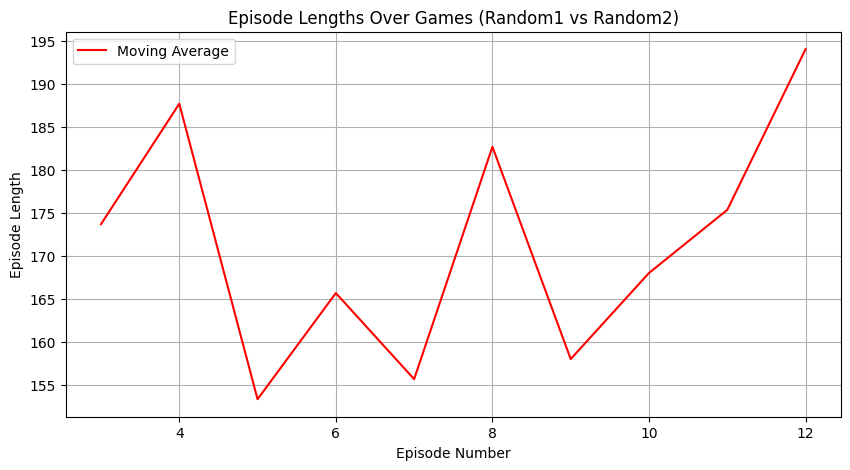

In [ ]:
plot_episode_lengths(episode_lengths, ally="Random1", enemy="Random2")

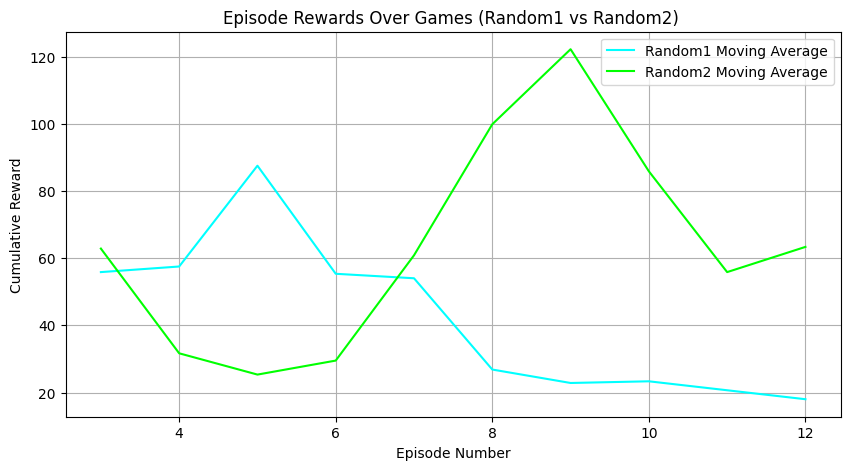

In [ ]:
plot_episode_rewards(ally_rewards, enemy_rewards, ally="Random1", enemy="Random2")

Next, lets try to create a better baseline agent.

### Test Case 2: Create a Greedy Agent

In [ ]:
class GreedyAgent:
    """
    This agent attempts to maximize immediate reward by capturing the highest
    value piece available on each move.
    """
    def __init__(self):
        pass

    def move(self, env):
        actions = (env.ally_actions if env.turn == ALLY
                   else env.enemy_actions)
        legal_moves = np.where(actions == 1)[0]

        # print(legal_moves)

        best_value = 0
        best_move = None

        # Evaluate each legal move
        for move in legal_moves:
            _, _, end = action_space_to_move(move)
            target_piece_id = env.state[end[0]][end[1]]
            piece_value = 0

            # Only consider the reward value if capturing an opponent's piece
            if target_piece_id != 0:
                piece_value = PIECE_POINTS[abs(target_piece_id)]
                # print(target_piece_id, piece_value)

            # Update best move if this move has a higher capture value
            if piece_value > best_value:
                best_value = piece_value
                best_move = move

        # If no best move found and there are legal moves available, choose randomly
        if best_move is None and legal_moves.size > 0:
            best_move = np.random.choice(legal_moves)

        # print(best_move)

        return best_move

Now lets use this newly created greedy agent to play a game against the random agent.

In [ ]:
# Initialize both agents
greedy_agent = GreedyAgent()
random_agent = RandomAgent()

# Variables to track wins
greedy_wins = 0
random_wins = 0
truncated_game = 0
num_games = 12

episode_lengths = []
greedy_rewards = []
random_rewards = []
winning_rewards = []

for game in range(num_games):
    env.reset()
    done = False
    round = 0
    current_greedy_rewards = 0
    current_random_rewards = 0

    print(f"\nStarting game {game + 1}")

    while not done:
        print(f"Game {game + 1}, Round {round + 1}")

        # print(f'turn: {env.turn}, {type(env.turn)}')

        turn = "Greedy Agent" if env.turn == 1 else "Random Agent"
        # Check whose turn it is and select an agent
        if env.turn == 1:
            action = greedy_agent.move(env)
        else:
            action = random_agent.move(env)

        # print(f'Prior: {env.state}')

        _, reward, done, _ = env.step(action)

        # print(f'Post: {env.state}')

        # Accumulate rewards based on who is playing
        if turn == "Greedy Agent":
          current_greedy_rewards += reward
        else:
          current_random_rewards += reward

        move = action_space_to_move(action)
        piece = PIECE_ID_TO_NAME[move[0]]

        print(f"{turn} made the move {piece} from {move[1]} to {move[2]}. Reward: {reward}")
        print("================")

        round += 1
        # env.render()  # Uncomment if you want to see visual output

        # To prevent infinite loops
        if round >= 200:
            print("Game reached 200 rounds, stopping to prevent infinite loop.")
            done = True

    episode_lengths.append(round)

    if reward == 100 and turn == "Greedy Agent":
        greedy_wins += 1
        winning_rewards.append(current_greedy_rewards)
    elif reward == 100 and turn == "Random Agent":
        random_wins += 1
        winning_rewards.append(current_random_rewards)

    print(f"Game {game + 1} ended. Score -> Greedy: {greedy_wins}, Random: {random_wins}, Truncated Game: {truncated_game}")

    greedy_rewards.append(current_greedy_rewards)
    random_rewards.append(current_random_rewards)

env.close()

print(f"\nFinal score after {num_games} games -> Greedy Agent Wins: {greedy_wins}, Random Agent Wins: {random_wins}, Truncated Game: {truncated_game}")
print(f"Greedy Agent Win Rate: {calculate_win_rate(greedy_wins, num_games)}%")
print(f"Random Agent Win Rate: {calculate_win_rate(random_wins, num_games)}%")
print(f"Truncated Rate: {calculate_win_rate(truncated_game, num_games)}%")
print(f"Average Winning Reward per Episode: {average_reward(winning_rewards)}")
print(f"Average Episode Length: {average_episode_length(episode_lengths)}")
print(f"Greedy Agent Reward Variability: {reward_variability(greedy_rewards)}")
print(f"Random Agent Reward Variability: {reward_variability(random_rewards)}")


Starting game 1
Game 1, Round 1
Greedy Agent made the move CANNON_1 from [7, 1] to [0, 1]. Reward: 4.0
Game 1, Round 2
Random Agent made the move CHARIOT_1 from [0, 8] to [2, 8]. Reward: 0.0
Game 1, Round 3
Greedy Agent made the move CANNON_2 from [7, 7] to [0, 7]. Reward: 4.0
Game 1, Round 4
Random Agent made the move CANNON_1 from [2, 7] to [2, 5]. Reward: 0.0
Game 1, Round 5
Greedy Agent made the move CANNON_1 from [0, 1] to [0, 3]. Reward: 2.0
Game 1, Round 6
Random Agent made the move CANNON_2 from [2, 1] to [2, 4]. Reward: 0.0
Game 1, Round 7
Greedy Agent made the move CANNON_1 from [0, 3] to [0, 0]. Reward: 9.0
Game 1, Round 8
Random Agent made the move CANNON_1 from [2, 5] to [4, 5]. Reward: 0.0
Game 1, Round 9
Greedy Agent made the move CANNON_1 from [0, 0] to [0, 4]. Reward: 100.0
Game 1 ended. Score -> Greedy: 1, Random: 0, Truncated Game: 0

Starting game 2
Game 2, Round 1
Greedy Agent made the move CANNON_1 from [7, 1] to [0, 1]. Reward: 4.0
Game 2, Round 2
Random Agent m

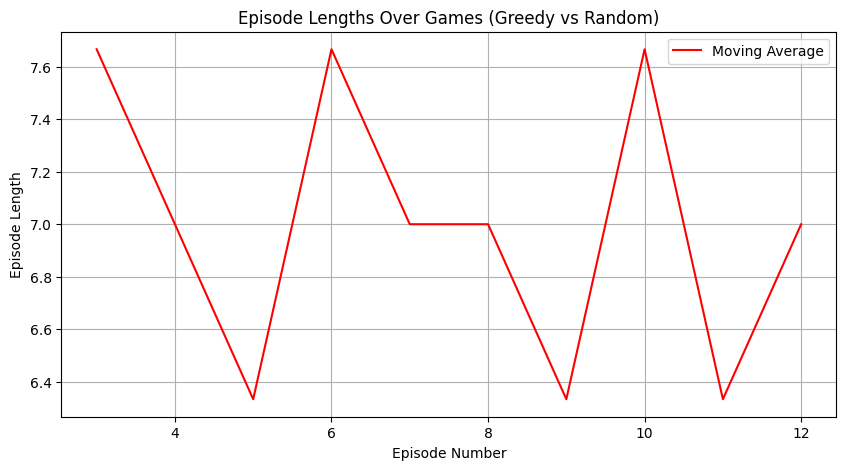

In [ ]:
# Visualizing the episode lengths
plot_episode_lengths(episode_lengths)

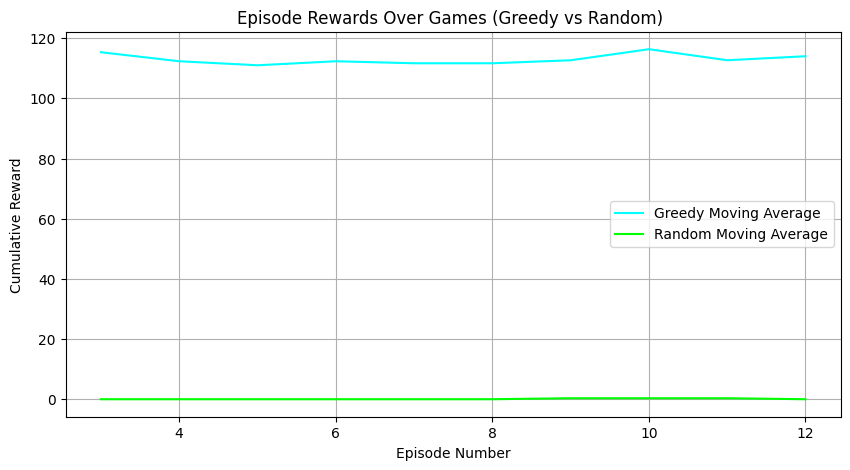

In [ ]:
# Visualizing the cumulative reward lengths
plot_episode_rewards(greedy_rewards, random_rewards)


On average, the games end sooner in the greedy vs random agent configuration.

In addition, the greedy agent wins almost all the time.

Lastly, the reward variability of the winning (greedy) agent is lower.

### Test Case 3: Create a DQN agent


In [ ]:
from gym_xiangqi.constants import ALLY, PIECE_ID_TO_NAME, PIECE_POINTS,  ENEMY
from gym_xiangqi.utils import action_space_to_move
from gym_xiangqi.agents import RandomAgent

import time
from tqdm import tqdm

import collections
import random
from random import sample

import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import gym

In [ ]:
ENV_NAME = 'gym_xiangqi:xiangqi-v0'

# Get the environment and extract the number of actions available in the Cartpole problem
env = gym.make(ENV_NAME)
np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n

In [ ]:
## implement Replay to store games
class ReplayMemory:
    def __init__(self, env, memory_size=50000, burn_in=10000):
        # Initialize replay memory -- stores transitions recorded from the agent taking actions in the environment.
        self.memory_size = memory_size
        self.burn_in = burn_in
        self.memory = collections.deque([], maxlen=memory_size)
        self.env = env

    def sample_batch(self, batch_size=10):
        # print((self.memory))
        # Returns a batch of randomly sampled transitions to be used for training the model.
        return random.sample(self.memory, batch_size)

    def append(self, transition):
        # Appends a transition to the replay memory.
        self.memory.append(transition)

In [ ]:
### DQN FINALIZED ###

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
import time

# Define the DQN Model using PyTorch
class DQNModel(nn.Module):
    def __init__(self, input_shape, nb_actions):
        super(DQNModel, self).__init__()
        self.input_shape = input_shape
        self.nb_actions = nb_actions

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(np.prod(input_shape), 128)
        self.fc2 = nn.Linear(128, nb_actions)

    def forward(self, x): ## maps states --> action values
        x = self.flatten(x)
        x = x.to(self.fc1.weight.dtype)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# Define the DQNAgent class
class DQNAgent:
    def __init__(self, model, memory, nb_steps_warmup, target_model_update, epsilon_decay_steps, epsilon_start=1.0,
                 epsilon_end=0.01, gamma=0.99):
        self.model = model
        self.memory = memory
        self.nb_steps_warmup = nb_steps_warmup
        self.target_model_update = target_model_update
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay_steps = epsilon_decay_steps
        self.epsilon_decay = (epsilon_start - epsilon_end) / epsilon_decay_steps
        self.gamma = gamma
        self.target_model = DQNModel(model.input_shape, model.nb_actions)
        self.target_model.load_state_dict(self.model.state_dict())
        self.target_model.eval()

    def compile(self, optimizer, loss_function):
        self.optimizer = optimizer
        self.loss_function = loss_function

    def move(self, env, epsilon):
        actions = (env.ally_actions if env.turn == 1 else env.enemy_actions)
        legal_moves = np.where(actions == 1)[0]

        if np.random.rand() < epsilon:
            return np.random.choice(legal_moves)
        else:
            best_value = 0
            best_move = None

            # Evaluate each legal move
            for move in legal_moves:
                _, _, end = action_space_to_move(move)
                target_piece_id = env.state[end[0]][end[1]]
                piece_value = 0

                # Only consider the reward value if capturing an opponent's piece
                if target_piece_id != 0:
                    piece_value = PIECE_POINTS[abs(target_piece_id)]

                # Update best move if this move has a higher capture value
                if piece_value > best_value:
                    best_value = piece_value
                    best_move = move

            # If no best move found and there are legal moves available, choose randomly
            if best_move is None and legal_moves.size > 0:
                best_move = np.random.choice(legal_moves)

            return best_move

    def fit(self, env, nb_steps, batch_size, enemy_agent, visualize=False, verbose=1, ):
        pbar = tqdm(desc='Games', total=nb_steps)
        dqn_wins = 0
        random_wins = 0
        episode_lengths = []
        dqn_rewards = []
        enemy_rewards = []
        winning_rewards = []
        # enemy_agent = GreedyAgent()

        for step in range(1, nb_steps + 1):
            # Reset the environment
            obs = env.reset()
            round = 0
            done = False
            current_dqn_rewards = 0
            current_enemy_rewards = 0

            epsilon = max(self.epsilon_end, self.epsilon_start - step * self.epsilon_decay)

            while not done:
                ally_action = self.move(env, epsilon)
                obs, ally_reward, done, info = env.step(ally_action)

                transition = (obs, ally_action, ally_reward, done)
                self.memory.append(transition)

                ally_turn = "Ally" #if env.turn == ALLY else "Enemy"
                ally_move = action_space_to_move(ally_action)
                ally_piece = PIECE_ID_TO_NAME[ally_move[0]]

                print(f"Round: {round}")
                print(f"{ally_turn} made the move {ally_piece} from {ally_move[1]} to {ally_move[2]}.")
                print(f"Reward: {ally_reward}")
                current_dqn_rewards += ally_reward
                print("================")
                round += 1

                if done:
                    break

                # Enemy's move
                enemy_action = enemy_agent.move(env)
                _, enemy_reward, done, _ = env.step(enemy_action)
                enemy_turn = "Enemy" #if env.turn == 'Enemy' else "Enemy"
                enemy_move = action_space_to_move(enemy_action)
                enemy_piece = PIECE_ID_TO_NAME[enemy_move[0]]

                print(f"Round: {round}")
                print(f"{enemy_turn} made the move {enemy_piece} from {enemy_move[1]} to {enemy_move[2]}.")
                print(f"Reward: {enemy_reward}")
                current_enemy_rewards += enemy_reward
                print("================")
                round += 1

                if round >= 200:
                  done = True

                # If warm-up steps are done, train the model
                if step > self.nb_steps_warmup:
                    # print('entering minibatch')
                    minibatch = self.memory.sample_batch(batch_size)
                    self.train_on_minibatch(minibatch)

                time.sleep(1)

            dqn_rewards.append(current_dqn_rewards)
            enemy_rewards.append(current_enemy_rewards)

            if ally_reward == 100:
                dqn_wins += 1
                print(dqn_wins)
            elif enemy_reward == 100:
                random_wins += 1

            episode_lengths.append(round)

            # Update target network every target_model_update steps
            if step % self.target_model_update == 0:
                self.update_target_model()

            # Print progress
            if verbose > 0:
                print(f"Step: {step}/{nb_steps} | Length of Game: {round} | Epsilon: {epsilon:.4f}")
            pbar.update(step)

            # Optionally visualize
            if visualize:
                env.render()

        print(f"DQN Agent Win Rate: {calculate_win_rate(dqn_wins, nb_steps)}%")
        print(f"Greedy Agent Win Rate: {calculate_win_rate(random_wins, nb_steps)}%")
        print(f"Average Episode Length: {np.mean(episode_lengths)}")
        plot_episode_lengths(episode_lengths, ally=self.__class__.__name__, enemy='Greedy')
        plot_episode_rewards(dqn_rewards, enemy_rewards, ally=self.__class__.__name__, enemy='Greedy')

    def train_on_minibatch(self, minibatch):
        obs, rewards, dones, _ = zip(*minibatch)
        obs = torch.tensor([o.flatten() for o in obs])

        # q-value - compute through forward pass of nn (output dimension is 1d)
        q_values = self.model(obs)#.detach().numpy()

        # q-value for next states
        next_states = torch.tensor([np.array(t[0]).flatten() for t in minibatch]) ## 2d tensor, batch_size, state_size
        target_q_values_next = self.target_model(next_states).detach().numpy()

        # update q-values if not done (bellman equation)
        for i in range(len(minibatch)):
            if dones[i]: ##
                q_values[i] = rewards[i]
            else:
                max_next_q_value = np.max(target_q_values_next[i])
                q_values[i] = rewards[i] + self.gamma * max_next_q_value

        # train on minibatch
        obs = torch.tensor([np.array(t[0]).flatten() for t in minibatch])
        q_values = torch.tensor(q_values)
        self.optimizer.zero_grad()

        ## minimize loss
        loss = self.loss_function(self.model(obs), q_values)
        loss.backward()
        self.optimizer.step()

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

Games:   0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead o

Round: 0
Ally made the move ADVISOR_2 from [9, 5] to [8, 4].
Reward: 0.0
Round: 1
Enemy made the move CANNON_1 from [2, 7] to [9, 7].
Reward: 4.0
Round: 2
Ally made the move CANNON_2 from [7, 7] to [7, 8].
Reward: 0.0
Round: 3
Enemy made the move CANNON_1 from [9, 7] to [9, 4].
Reward: 100.0


Games:   2%|▏         | 1/50 [00:02<01:40,  2.04s/it]

Step: 1/50 | Length of Game: 4 | Epsilon: 0.9802
Round: 0
Ally made the move SOLDIER_4 from [6, 6] to [5, 6].
Reward: 0.0
Round: 1
Enemy made the move CANNON_1 from [2, 7] to [9, 7].
Reward: 4.0
Round: 2
Ally made the move CANNON_1 from [7, 1] to [7, 4].
Reward: 0.0
Round: 3
Enemy made the move CANNON_1 from [9, 7] to [9, 5].
Reward: 2.0
Round: 4
Ally made the move CHARIOT_2 from [9, 8] to [7, 8].
Reward: 0.0
Round: 5
Enemy made the move CANNON_1 from [9, 5] to [9, 3].
Reward: 2.0
Round: 6
Ally made the move SOLDIER_5 from [6, 8] to [5, 8].
Reward: 0.0
Round: 7
Enemy made the move CANNON_1 from [9, 3] to [9, 1].
Reward: 4.0
Round: 8
Ally made the move CANNON_2 from [7, 7] to [2, 7].
Reward: 0.0
Round: 9
Enemy made the move CANNON_1 from [9, 1] to [9, 4].
Reward: 100.0


Games:   6%|▌         | 3/50 [00:07<01:53,  2.42s/it]

Step: 2/50 | Length of Game: 10 | Epsilon: 0.9604
Round: 0
Ally made the move CANNON_2 from [7, 7] to [7, 6].
Reward: 0.0
Round: 1
Enemy made the move CANNON_2 from [2, 1] to [9, 1].
Reward: 4.0
Round: 2
Ally made the move ELEPHANT_1 from [9, 2] to [7, 4].
Reward: 0.0
Round: 3
Enemy made the move CANNON_2 from [9, 1] to [9, 4].
Reward: 100.0


Games:  12%|█▏        | 6/50 [00:09<00:59,  1.36s/it]

Step: 3/50 | Length of Game: 4 | Epsilon: 0.9406
Round: 0
Ally made the move ELEPHANT_1 from [9, 2] to [7, 0].
Reward: 0.0
Round: 1
Enemy made the move CANNON_1 from [2, 7] to [9, 7].
Reward: 4.0
Round: 2
Ally made the move SOLDIER_3 from [6, 4] to [5, 4].
Reward: 0.0
Round: 3
Enemy made the move CANNON_2 from [2, 1] to [9, 1].
Reward: 4.0
Round: 4
Ally made the move CHARIOT_1 from [9, 0] to [8, 0].
Reward: 0.0
Round: 5
Enemy made the move CANNON_2 from [9, 1] to [9, 4].
Reward: 100.0


Games:  20%|██        | 10/50 [00:12<00:41,  1.04s/it]

Step: 4/50 | Length of Game: 6 | Epsilon: 0.9208
Round: 0
Ally made the move CANNON_2 from [7, 7] to [3, 7].
Reward: 0.0
Round: 1
Enemy made the move CANNON_1 from [2, 7] to [9, 7].
Reward: 4.0
Round: 2
Ally made the move CANNON_2 from [3, 7] to [6, 7].
Reward: 0.0
Round: 3
Enemy made the move CANNON_2 from [2, 1] to [9, 1].
Reward: 4.0
Round: 4
Ally made the move CANNON_2 from [6, 7] to [3, 7].
Reward: 0.0
Round: 5
Enemy made the move CANNON_1 from [9, 7] to [9, 5].
Reward: 2.0
Round: 6
Ally made the move CANNON_2 from [3, 7] to [6, 7].
Reward: 0.0
Round: 7
Enemy made the move CANNON_1 from [9, 5] to [9, 8].
Reward: 9.0
Round: 8
Ally made the move CHARIOT_1 from [9, 0] to [9, 1].
Reward: 4.5
Round: 9
Enemy made the move CANNON_1 from [9, 8] to [9, 4].
Reward: 100.0


Games:  30%|███       | 15/50 [00:17<00:35,  1.03s/it]

Step: 5/50 | Length of Game: 10 | Epsilon: 0.9010
Round: 0
Ally made the move ELEPHANT_2 from [9, 6] to [7, 4].
Reward: 0.0
Round: 1
Enemy made the move CANNON_1 from [2, 7] to [9, 7].
Reward: 4.0


<ipython-input-13-aebb23880fe4>:177: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  obs = torch.tensor([o.flatten() for o in obs])
<ipython-input-13-aebb23880fe4>:196: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_values = torch.tensor(q_values)


Round: 2
Ally made the move SOLDIER_2 from [6, 2] to [5, 2].
Reward: 0.0
Round: 3
Enemy made the move CANNON_1 from [9, 7] to [9, 4].
Reward: 100.0


Games:  42%|████▏     | 21/50 [00:20<00:22,  1.31it/s]

Step: 6/50 | Length of Game: 4 | Epsilon: 0.8812
Round: 0
Ally made the move CANNON_1 from [7, 1] to [7, 3].
Reward: 0.0
Round: 1
Enemy made the move CANNON_1 from [2, 7] to [9, 7].
Reward: 4.0
Round: 2
Ally made the move CANNON_2 from [7, 7] to [7, 8].
Reward: 0.0
Round: 3
Enemy made the move CANNON_1 from [9, 7] to [9, 5].
Reward: 2.0
Round: 4
Ally made the move GENERAL from [9, 4] to [9, 5].
Reward: 4.5
Round: 5
Enemy made the move CANNON_2 from [2, 1] to [6, 1].
Reward: 0.0
Round: 6
Ally made the move CANNON_2 from [7, 8] to [3, 8].
Reward: 1.0
Round: 7
Enemy made the move CHARIOT_1 from [0, 8] to [3, 8].
Reward: 4.5
Round: 8
Ally made the move ELEPHANT_2 from [9, 6] to [7, 8].
Reward: 0.0
Round: 9
Enemy made the move CHARIOT_1 from [3, 8] to [6, 8].
Reward: 1.0
Round: 10
Ally made the move CANNON_1 from [7, 3] to [7, 7].
Reward: 0.0
Round: 11
Enemy made the move CHARIOT_1 from [6, 8] to [7, 8].
Reward: 2.0
Round: 12
Ally made the move CANNON_1 from [7, 7] to [2, 7].
Reward: 0.0
Ro

Games:  56%|█████▌    | 28/50 [00:29<00:22,  1.04s/it]

Step: 7/50 | Length of Game: 16 | Epsilon: 0.8614
Round: 0
Ally made the move CANNON_1 from [7, 1] to [0, 1].
Reward: 4.0
Round: 1
Enemy made the move CHARIOT_2 from [0, 0] to [0, 1].
Reward: 4.5
Round: 2
Ally made the move CANNON_2 from [7, 7] to [7, 5].
Reward: 0.0
Round: 3
Enemy made the move CANNON_1 from [2, 7] to [3, 7].
Reward: 0.0
Round: 4
Ally made the move CHARIOT_1 from [9, 0] to [8, 0].
Reward: 0.0
Round: 5
Enemy made the move CANNON_1 from [3, 7] to [7, 7].
Reward: 0.0
Round: 6
Ally made the move CANNON_2 from [7, 5] to [5, 5].
Reward: 0.0
Round: 7
Enemy made the move CANNON_1 from [7, 7] to [7, 3].
Reward: 0.0
Round: 8
Ally made the move CHARIOT_1 from [8, 0] to [7, 0].
Reward: 0.0
Round: 9
Enemy made the move CANNON_1 from [7, 3] to [7, 4].
Reward: 0.0
Round: 10
Ally made the move SOLDIER_3 from [6, 4] to [5, 4].
Reward: 0.0
Round: 11
Enemy made the move ELEPHANT_1 from [0, 6] to [2, 4].
Reward: 0.0
Round: 12
Ally made the move CANNON_2 from [5, 5] to [3, 5].
Reward: 0.0

Games:  72%|███████▏  | 36/50 [00:44<00:19,  1.38s/it]

Step: 8/50 | Length of Game: 24 | Epsilon: 0.8416
Round: 0
Ally made the move CANNON_2 from [7, 7] to [7, 5].
Reward: 0.0
Round: 1
Enemy made the move CANNON_2 from [2, 1] to [9, 1].
Reward: 4.0
Round: 2
Ally made the move CHARIOT_1 from [9, 0] to [9, 1].
Reward: 4.5
Round: 3
Enemy made the move CANNON_1 from [2, 7] to [2, 0].
Reward: 0.0
Round: 4
Ally made the move CANNON_1 from [7, 1] to [7, 4].
Reward: 0.0
Round: 5
Enemy made the move CANNON_1 from [2, 0] to [6, 0].
Reward: 1.0
Round: 6
Ally made the move CANNON_2 from [7, 5] to [1, 5].
Reward: 0.0
Round: 7
Enemy made the move CANNON_1 from [6, 0] to [6, 4].
Reward: 1.0
Round: 8
Ally made the move GENERAL from [9, 4] to [8, 4].
Reward: 0.0
Round: 9
Enemy made the move CANNON_1 from [6, 4] to [8, 4].
Reward: 100.0


Games:  90%|█████████ | 45/50 [00:50<00:05,  1.10s/it]

Step: 9/50 | Length of Game: 10 | Epsilon: 0.8218
Round: 0
Ally made the move CANNON_1 from [7, 1] to [0, 1].
Reward: 4.0
Round: 1
Enemy made the move CHARIOT_2 from [0, 0] to [0, 1].
Reward: 4.5
Round: 2
Ally made the move ELEPHANT_1 from [9, 2] to [7, 4].
Reward: 0.0
Round: 3
Enemy made the move CANNON_1 from [2, 7] to [9, 7].
Reward: 4.0
Round: 4
Ally made the move CHARIOT_2 from [9, 8] to [9, 7].
Reward: 4.5
Round: 5
Enemy made the move SOLDIER_2 from [3, 6] to [4, 6].
Reward: 0.0
Round: 6
Ally made the move ADVISOR_1 from [9, 3] to [8, 4].
Reward: 0.0
Round: 7
Enemy made the move CHARIOT_2 from [0, 1] to [1, 1].
Reward: 0.0
Round: 8
Ally made the move CANNON_2 from [7, 7] to [5, 7].
Reward: 0.0
Round: 9
Enemy made the move HORSE_1 from [0, 7] to [2, 8].
Reward: 0.0
Round: 10
Ally made the move ELEPHANT_1 from [7, 4] to [9, 2].
Reward: 0.0
Round: 11
Enemy made the move CHARIOT_2 from [1, 1] to [1, 3].
Reward: 0.0
Round: 12
Ally made the move CANNON_2 from [5, 7] to [4, 7].
Reward: 

Games: 55it [01:00,  1.06s/it]                        

Step: 10/50 | Length of Game: 16 | Epsilon: 0.8020
Round: 0
Ally made the move CANNON_1 from [7, 1] to [7, 5].
Reward: 0.0
Round: 1
Enemy made the move CANNON_1 from [2, 7] to [9, 7].
Reward: 4.0
Round: 2
Ally made the move CHARIOT_2 from [9, 8] to [9, 7].
Reward: 4.5
Round: 3
Enemy made the move HORSE_1 from [0, 7] to [2, 8].
Reward: 0.0
Round: 4
Ally made the move ADVISOR_1 from [9, 3] to [8, 4].
Reward: 0.0
Round: 5
Enemy made the move SOLDIER_3 from [3, 4] to [4, 4].
Reward: 0.0
Round: 6
Ally made the move CHARIOT_1 from [9, 0] to [8, 0].
Reward: 0.0
Round: 7
Enemy made the move CHARIOT_2 from [0, 0] to [1, 0].
Reward: 0.0
Round: 8
Ally made the move SOLDIER_4 from [6, 6] to [5, 6].
Reward: 0.0
Round: 9
Enemy made the move HORSE_1 from [2, 8] to [1, 6].
Reward: 0.0
Round: 10
Ally made the move ADVISOR_1 from [8, 4] to [7, 3].
Reward: 0.0
Round: 11
Enemy made the move SOLDIER_4 from [3, 2] to [4, 2].
Reward: 0.0
Round: 12
Ally made the move CANNON_1 from [7, 5] to [2, 5].
Reward: 0.

Games: 66it [01:46,  2.23s/it]

Step: 11/50 | Length of Game: 74 | Epsilon: 0.7822
Round: 0
Ally made the move CANNON_1 from [7, 1] to [7, 5].
Reward: 0.0
Round: 1
Enemy made the move CANNON_1 from [2, 7] to [9, 7].
Reward: 4.0
Round: 2
Ally made the move CANNON_1 from [7, 5] to [3, 5].
Reward: 0.0
Round: 3
Enemy made the move CANNON_1 from [9, 7] to [9, 5].
Reward: 2.0
Round: 4
Ally made the move GENERAL from [9, 4] to [9, 5].
Reward: 4.5
Round: 5
Enemy made the move CANNON_2 from [2, 1] to [2, 5].
Reward: 0.0
Round: 6
Ally made the move CANNON_2 from [7, 7] to [5, 7].
Reward: 0.0
Round: 7
Enemy made the move CANNON_2 from [2, 5] to [9, 5].
Reward: 100.0


Games: 78it [01:51,  1.55s/it]

Step: 12/50 | Length of Game: 8 | Epsilon: 0.7624
Round: 0
Ally made the move CANNON_1 from [7, 1] to [7, 2].
Reward: 0.0
Round: 1
Enemy made the move CANNON_1 from [2, 7] to [9, 7].
Reward: 4.0
Round: 2
Ally made the move ADVISOR_1 from [9, 3] to [8, 4].
Reward: 0.0
Round: 3
Enemy made the move CANNON_1 from [9, 7] to [9, 5].
Reward: 2.0
Round: 4
Ally made the move CANNON_1 from [7, 2] to [7, 1].
Reward: 0.0
Round: 5
Enemy made the move CANNON_1 from [9, 5] to [9, 8].
Reward: 9.0
Round: 6
Ally made the move CANNON_1 from [7, 1] to [0, 1].
Reward: 4.0
Round: 7
Enemy made the move CANNON_1 from [9, 8] to [9, 4].
Reward: 100.0


Games: 91it [01:56,  1.12s/it]

Step: 13/50 | Length of Game: 8 | Epsilon: 0.7426
Round: 0
Ally made the move CANNON_2 from [7, 7] to [8, 7].
Reward: 0.0
Round: 1
Enemy made the move CANNON_1 from [2, 7] to [9, 7].
Reward: 4.0
Round: 2
Ally made the move CANNON_1 from [7, 1] to [6, 1].
Reward: 0.0
Round: 3
Enemy made the move CANNON_2 from [2, 1] to [9, 1].
Reward: 4.0
Round: 4
Ally made the move CANNON_2 from [8, 7] to [7, 7].
Reward: 0.0
Round: 5
Enemy made the move CANNON_1 from [9, 7] to [9, 5].
Reward: 2.0
Round: 6
Ally made the move GENERAL from [9, 4] to [8, 4].
Reward: 0.0
Round: 7
Enemy made the move CANNON_1 from [9, 5] to [9, 8].
Reward: 9.0
Round: 8
Ally made the move CANNON_2 from [7, 7] to [2, 7].
Reward: 0.0
Round: 9
Enemy made the move CANNON_1 from [9, 8] to [9, 3].
Reward: 2.0
Round: 10
Ally made the move CHARIOT_1 from [9, 0] to [9, 1].
Reward: 4.5
Round: 11
Enemy made the move CANNON_1 from [9, 3] to [9, 1].
Reward: 9.0
Round: 12
Ally made the move CANNON_2 from [2, 7] to [2, 3].
Reward: 0.0
Round

Games: 105it [02:22,  1.41s/it]

Step: 14/50 | Length of Game: 44 | Epsilon: 0.7228
Round: 0
Ally made the move CHARIOT_2 from [9, 8] to [8, 8].
Reward: 0.0
Round: 1
Enemy made the move CANNON_1 from [2, 7] to [9, 7].
Reward: 4.0
Round: 2
Ally made the move CANNON_1 from [7, 1] to [0, 1].
Reward: 4.0
Round: 3
Enemy made the move CHARIOT_2 from [0, 0] to [0, 1].
Reward: 4.5
Round: 4
Ally made the move ELEPHANT_1 from [9, 2] to [7, 0].
Reward: 0.0
Round: 5
Enemy made the move CANNON_1 from [9, 7] to [9, 5].
Reward: 2.0
Round: 6
Ally made the move CHARIOT_2 from [8, 8] to [8, 2].
Reward: 0.0
Round: 7
Enemy made the move CANNON_1 from [9, 5] to [9, 3].
Reward: 2.0
Round: 8
Ally made the move CHARIOT_2 from [8, 2] to [9, 2].
Reward: 0.0
Round: 9
Enemy made the move CANNON_1 from [9, 3] to [9, 1].
Reward: 4.0
Round: 10
Ally made the move CANNON_2 from [7, 7] to [2, 7].
Reward: 0.0
Round: 11
Enemy made the move CANNON_1 from [9, 1] to [9, 4].
Reward: 100.0


Games: 120it [02:30,  1.08s/it]

Step: 15/50 | Length of Game: 12 | Epsilon: 0.7030
Round: 0
Ally made the move ADVISOR_2 from [9, 5] to [8, 4].
Reward: 0.0
Round: 1
Enemy made the move CANNON_1 from [2, 7] to [9, 7].
Reward: 4.0
Round: 2
Ally made the move CHARIOT_2 from [9, 8] to [9, 7].
Reward: 4.5
Round: 3
Enemy made the move CANNON_2 from [2, 1] to [9, 1].
Reward: 4.0
Round: 4
Ally made the move CHARIOT_1 from [9, 0] to [9, 1].
Reward: 4.5
Round: 5
Enemy made the move GENERAL from [0, 4] to [1, 4].
Reward: 0.0
Round: 6
Ally made the move CANNON_2 from [7, 7] to [7, 3].
Reward: 0.0
Round: 7
Enemy made the move GENERAL from [1, 4] to [2, 4].
Reward: 0.0
Round: 8
Ally made the move CHARIOT_2 from [9, 7] to [0, 7].
Reward: 4.0
Round: 9
Enemy made the move CHARIOT_1 from [0, 8] to [0, 7].
Reward: 9.0
Round: 10
Ally made the move CANNON_1 from [7, 1] to [7, 0].
Reward: 0.0
Round: 11
Enemy made the move CHARIOT_1 from [0, 7] to [7, 7].
Reward: 0.0
Round: 12
Ally made the move CANNON_1 from [7, 0] to [7, 7].
Reward: 9.0


Games: 136it [02:55,  1.26s/it]

Step: 16/50 | Length of Game: 42 | Epsilon: 0.6832
Round: 0
Ally made the move CANNON_1 from [7, 1] to [0, 1].
Reward: 4.0
Round: 1
Enemy made the move CHARIOT_2 from [0, 0] to [0, 1].
Reward: 4.5
Round: 2
Ally made the move CANNON_2 from [7, 7] to [0, 7].
Reward: 4.0
Round: 3
Enemy made the move CHARIOT_1 from [0, 8] to [0, 7].
Reward: 4.5
Round: 4
Ally made the move ELEPHANT_1 from [9, 2] to [7, 0].
Reward: 0.0
Round: 5
Enemy made the move SOLDIER_1 from [3, 8] to [4, 8].
Reward: 0.0
Round: 6
Ally made the move SOLDIER_5 from [6, 8] to [5, 8].
Reward: 0.0
Round: 7
Enemy made the move SOLDIER_1 from [4, 8] to [5, 8].
Reward: 1.0
Round: 8
Ally made the move HORSE_1 from [9, 1] to [7, 2].
Reward: 0.0
Round: 9
Enemy made the move CANNON_1 from [2, 7] to [4, 7].
Reward: 0.0
Round: 10
Ally made the move HORSE_1 from [7, 2] to [9, 1].
Reward: 0.0
Round: 11
Enemy made the move CANNON_1 from [4, 7] to [4, 6].
Reward: 0.0
Round: 12
Ally made the move CHARIOT_2 from [9, 8] to [5, 8].
Reward: 1.

Games: 153it [03:08,  1.07s/it]

Step: 17/50 | Length of Game: 20 | Epsilon: 0.6634
Round: 0
Ally made the move CANNON_2 from [7, 7] to [0, 7].
Reward: 4.0
Round: 1
Enemy made the move CHARIOT_1 from [0, 8] to [0, 7].
Reward: 4.5
Round: 2
Ally made the move CANNON_1 from [7, 1] to [0, 1].
Reward: 4.0
Round: 3
Enemy made the move CHARIOT_2 from [0, 0] to [0, 1].
Reward: 4.5
Round: 4
Ally made the move SOLDIER_1 from [6, 0] to [5, 0].
Reward: 0.0
Round: 5
Enemy made the move CHARIOT_1 from [0, 7] to [0, 8].
Reward: 0.0
Round: 6
Ally made the move SOLDIER_5 from [6, 8] to [5, 8].
Reward: 0.0
Round: 7
Enemy made the move CANNON_1 from [2, 7] to [0, 7].
Reward: 0.0
Round: 8
Ally made the move HORSE_1 from [9, 1] to [7, 0].
Reward: 0.0
Round: 9
Enemy made the move CANNON_1 from [0, 7] to [5, 7].
Reward: 0.0
Round: 10
Ally made the move HORSE_1 from [7, 0] to [9, 1].
Reward: 0.0
Round: 11
Enemy made the move CANNON_2 from [2, 1] to [1, 1].
Reward: 0.0
Round: 12
Ally made the move ADVISOR_2 from [9, 5] to [8, 4].
Reward: 0.0


Games: 171it [03:42,  1.36s/it]

Step: 18/50 | Length of Game: 56 | Epsilon: 0.6436
Round: 0
Ally made the move CANNON_1 from [7, 1] to [0, 1].
Reward: 4.0
Round: 1
Enemy made the move CHARIOT_2 from [0, 0] to [0, 1].
Reward: 4.5
Round: 2
Ally made the move CANNON_2 from [7, 7] to [0, 7].
Reward: 4.0
Round: 3
Enemy made the move CHARIOT_1 from [0, 8] to [0, 7].
Reward: 4.5
Round: 4
Ally made the move ELEPHANT_1 from [9, 2] to [7, 4].
Reward: 0.0
Round: 5
Enemy made the move SOLDIER_3 from [3, 4] to [4, 4].
Reward: 0.0
Round: 6
Ally made the move HORSE_1 from [9, 1] to [8, 3].
Reward: 0.0
Round: 7
Enemy made the move CANNON_1 from [2, 7] to [2, 4].
Reward: 0.0
Round: 8
Ally made the move SOLDIER_5 from [6, 8] to [5, 8].
Reward: 0.0
Round: 9
Enemy made the move CHARIOT_1 from [0, 7] to [9, 7].
Reward: 4.0
Round: 10
Ally made the move CHARIOT_1 from [9, 0] to [9, 2].
Reward: 0.0
Round: 11
Enemy made the move CHARIOT_1 from [9, 7] to [9, 8].
Reward: 9.0
Round: 12
Ally made the move GENERAL from [9, 4] to [8, 4].
Reward: 0

Games: 190it [03:55,  1.13s/it]

Step: 19/50 | Length of Game: 22 | Epsilon: 0.6238
Round: 0
Ally made the move ELEPHANT_2 from [9, 6] to [7, 8].
Reward: 0.0
Round: 1
Enemy made the move CANNON_1 from [2, 7] to [9, 7].
Reward: 4.0
Round: 2
Ally made the move ADVISOR_2 from [9, 5] to [8, 4].
Reward: 0.0
Round: 3
Enemy made the move CANNON_2 from [2, 1] to [9, 1].
Reward: 4.0
Round: 4
Ally made the move CHARIOT_1 from [9, 0] to [9, 1].
Reward: 4.5
Round: 5
Enemy made the move CANNON_1 from [9, 7] to [9, 3].
Reward: 2.0
Round: 6
Ally made the move GENERAL from [9, 4] to [9, 3].
Reward: 4.5
Round: 7
Enemy made the move SOLDIER_5 from [3, 0] to [4, 0].
Reward: 0.0
Round: 8
Ally made the move CANNON_1 from [7, 1] to [5, 1].
Reward: 0.0
Round: 9
Enemy made the move HORSE_1 from [0, 7] to [2, 8].
Reward: 0.0
Round: 10
Ally made the move CANNON_2 from [7, 7] to [8, 7].
Reward: 0.0
Round: 11
Enemy made the move HORSE_1 from [2, 8] to [0, 7].
Reward: 0.0
Round: 12
Ally made the move CHARIOT_1 from [9, 1] to [6, 1].
Reward: 0.0
R

Games: 210it [04:42,  1.55s/it]

Step: 20/50 | Length of Game: 78 | Epsilon: 0.6040
Round: 0
Ally made the move HORSE_1 from [9, 1] to [7, 0].
Reward: 0.0
Round: 1
Enemy made the move CANNON_1 from [2, 7] to [9, 7].
Reward: 4.0
Round: 2
Ally made the move SOLDIER_2 from [6, 2] to [5, 2].
Reward: 0.0
Round: 3
Enemy made the move CANNON_1 from [9, 7] to [9, 5].
Reward: 2.0
Round: 4
Ally made the move CANNON_1 from [7, 1] to [7, 6].
Reward: 0.0
Round: 5
Enemy made the move CANNON_1 from [9, 5] to [9, 8].
Reward: 9.0
Round: 6
Ally made the move CANNON_2 from [7, 7] to [5, 7].
Reward: 0.0
Round: 7
Enemy made the move CANNON_1 from [9, 8] to [9, 4].
Reward: 100.0


Games: 231it [04:47,  1.11s/it]

Step: 21/50 | Length of Game: 8 | Epsilon: 0.5842
Round: 0
Ally made the move CANNON_1 from [7, 1] to [0, 1].
Reward: 4.0
Round: 1
Enemy made the move CHARIOT_2 from [0, 0] to [0, 1].
Reward: 4.5
Round: 2
Ally made the move CANNON_2 from [7, 7] to [7, 8].
Reward: 0.0
Round: 3
Enemy made the move CANNON_2 from [2, 1] to [4, 1].
Reward: 0.0
Round: 4
Ally made the move CANNON_2 from [7, 8] to [3, 8].
Reward: 1.0
Round: 5
Enemy made the move CHARIOT_1 from [0, 8] to [3, 8].
Reward: 4.5
Round: 6
Ally made the move ELEPHANT_2 from [9, 6] to [7, 4].
Reward: 0.0
Round: 7
Enemy made the move CHARIOT_1 from [3, 8] to [6, 8].
Reward: 1.0
Round: 8
Ally made the move CHARIOT_1 from [9, 0] to [8, 0].
Reward: 0.0
Round: 9
Enemy made the move CHARIOT_1 from [6, 8] to [9, 8].
Reward: 9.0
Round: 10
Ally made the move HORSE_2 from [9, 7] to [7, 6].
Reward: 0.0
Round: 11
Enemy made the move CHARIOT_1 from [9, 8] to [9, 5].
Reward: 2.0
Round: 12
Ally made the move GENERAL from [9, 4] to [9, 5].
Reward: 9.0

Games: 253it [06:06,  1.94s/it]

Step: 22/50 | Length of Game: 130 | Epsilon: 0.5644
Round: 0
Ally made the move CANNON_1 from [7, 1] to [5, 1].
Reward: 0.0
Round: 1
Enemy made the move CANNON_1 from [2, 7] to [9, 7].
Reward: 4.0
Round: 2
Ally made the move CHARIOT_2 from [9, 8] to [9, 7].
Reward: 4.5
Round: 3
Enemy made the move CANNON_2 from [2, 1] to [9, 1].
Reward: 4.0
Round: 4
Ally made the move SOLDIER_2 from [6, 2] to [5, 2].
Reward: 0.0
Round: 5
Enemy made the move CANNON_2 from [9, 1] to [9, 3].
Reward: 2.0
Round: 6
Ally made the move CANNON_2 from [7, 7] to [2, 7].
Reward: 0.0
Round: 7
Enemy made the move CANNON_2 from [9, 3] to [9, 0].
Reward: 9.0
Round: 8
Ally made the move CHARIOT_2 from [9, 7] to [8, 7].
Reward: 0.0
Round: 9
Enemy made the move CANNON_2 from [9, 0] to [9, 4].
Reward: 100.0


Games: 276it [06:12,  1.38s/it]

Step: 23/50 | Length of Game: 10 | Epsilon: 0.5446
Round: 0
Ally made the move CANNON_1 from [7, 1] to [5, 1].
Reward: 0.0
Round: 1
Enemy made the move CANNON_1 from [2, 7] to [9, 7].
Reward: 4.0
Round: 2
Ally made the move CANNON_2 from [7, 7] to [7, 8].
Reward: 0.0
Round: 3
Enemy made the move CANNON_2 from [2, 1] to [9, 1].
Reward: 4.0
Round: 4
Ally made the move CANNON_2 from [7, 8] to [7, 0].
Reward: 0.0
Round: 5
Enemy made the move CANNON_1 from [9, 7] to [9, 5].
Reward: 2.0
Round: 6
Ally made the move GENERAL from [9, 4] to [9, 5].
Reward: 4.5
Round: 7
Enemy made the move CANNON_2 from [9, 1] to [9, 3].
Reward: 2.0
Round: 8
Ally made the move CANNON_2 from [7, 0] to [3, 0].
Reward: 1.0
Round: 9
Enemy made the move CANNON_2 from [9, 3] to [9, 0].
Reward: 9.0
Round: 10
Ally made the move CANNON_2 from [3, 0] to [9, 0].
Reward: 4.5
Round: 11
Enemy made the move CHARIOT_2 from [0, 0] to [6, 0].
Reward: 1.0
Round: 12
Ally made the move CANNON_1 from [5, 1] to [4, 1].
Reward: 0.0
Roun

Games: 300it [06:23,  1.07s/it]

Step: 24/50 | Length of Game: 18 | Epsilon: 0.5248
Round: 0
Ally made the move CANNON_1 from [7, 1] to [7, 5].
Reward: 0.0
Round: 1
Enemy made the move CANNON_1 from [2, 7] to [9, 7].
Reward: 4.0
Round: 2
Ally made the move CHARIOT_2 from [9, 8] to [9, 7].
Reward: 4.5
Round: 3
Enemy made the move SOLDIER_5 from [3, 0] to [4, 0].
Reward: 0.0
Round: 4
Ally made the move CANNON_2 from [7, 7] to [2, 7].
Reward: 0.0
Round: 5
Enemy made the move ADVISOR_1 from [0, 5] to [1, 4].
Reward: 0.0
Round: 6
Ally made the move CANNON_2 from [2, 7] to [8, 7].
Reward: 0.0
Round: 7
Enemy made the move ADVISOR_1 from [1, 4] to [2, 3].
Reward: 0.0
Round: 8
Ally made the move CANNON_1 from [7, 5] to [7, 3].
Reward: 0.0
Round: 9
Enemy made the move HORSE_1 from [0, 7] to [2, 8].
Reward: 0.0
Round: 10
Ally made the move CANNON_2 from [8, 7] to [8, 2].
Reward: 0.0
Round: 11
Enemy made the move ELEPHANT_2 from [0, 2] to [2, 4].
Reward: 0.0
Round: 12
Ally made the move CANNON_1 from [7, 3] to [0, 3].
Reward: 2.0

Games: 325it [07:21,  1.49s/it]

Step: 25/50 | Length of Game: 96 | Epsilon: 0.5050
Round: 0
Ally made the move CANNON_1 from [7, 1] to [0, 1].
Reward: 4.0
Round: 1
Enemy made the move CHARIOT_2 from [0, 0] to [0, 1].
Reward: 4.5
Round: 2
Ally made the move CANNON_2 from [7, 7] to [0, 7].
Reward: 4.0
Round: 3
Enemy made the move CHARIOT_1 from [0, 8] to [0, 7].
Reward: 4.5
Round: 4
Ally made the move SOLDIER_2 from [6, 2] to [5, 2].
Reward: 0.0
Round: 5
Enemy made the move SOLDIER_1 from [3, 8] to [4, 8].
Reward: 0.0
Round: 6
Ally made the move SOLDIER_1 from [6, 0] to [5, 0].
Reward: 0.0
Round: 7
Enemy made the move CANNON_1 from [2, 7] to [5, 7].
Reward: 0.0
Round: 8
Ally made the move SOLDIER_1 from [5, 0] to [4, 0].
Reward: 0.0
Round: 9
Enemy made the move SOLDIER_5 from [3, 0] to [4, 0].
Reward: 2.0
Round: 10
Ally made the move HORSE_2 from [9, 7] to [7, 8].
Reward: 0.0
Round: 11
Enemy made the move CHARIOT_1 from [0, 7] to [2, 7].
Reward: 0.0
Round: 12
Ally made the move CHARIOT_1 from [9, 0] to [4, 0].
Reward: 

Games: 351it [07:41,  1.24s/it]

Step: 26/50 | Length of Game: 32 | Epsilon: 0.4852
Round: 0
Ally made the move CANNON_1 from [7, 1] to [0, 1].
Reward: 4.0
Round: 1
Enemy made the move CHARIOT_2 from [0, 0] to [0, 1].
Reward: 4.5
Round: 2
Ally made the move CANNON_2 from [7, 7] to [0, 7].
Reward: 4.0
Round: 3
Enemy made the move CHARIOT_1 from [0, 8] to [0, 7].
Reward: 4.5
Round: 4
Ally made the move SOLDIER_2 from [6, 2] to [5, 2].
Reward: 0.0
Round: 5
Enemy made the move CANNON_1 from [2, 7] to [7, 7].
Reward: 0.0
Round: 6
Ally made the move HORSE_1 from [9, 1] to [7, 2].
Reward: 0.0
Round: 7
Enemy made the move CANNON_2 from [2, 1] to [2, 8].
Reward: 0.0
Round: 8
Ally made the move CHARIOT_1 from [9, 0] to [9, 1].
Reward: 0.0
Round: 9
Enemy made the move CHARIOT_2 from [0, 1] to [9, 1].
Reward: 9.0
Round: 10
Ally made the move HORSE_1 from [7, 2] to [9, 1].
Reward: 9.0
Round: 11
Enemy made the move CANNON_2 from [2, 8] to [6, 8].
Reward: 1.0
Round: 12
Ally made the move CHARIOT_2 from [9, 8] to [6, 8].
Reward: 4.5


Games: 378it [09:08,  1.89s/it]

Step: 27/50 | Length of Game: 144 | Epsilon: 0.4654
Round: 0
Ally made the move ELEPHANT_1 from [9, 2] to [7, 0].
Reward: 0.0
Round: 1
Enemy made the move CANNON_1 from [2, 7] to [9, 7].
Reward: 4.0
Round: 2
Ally made the move CANNON_2 from [7, 7] to [7, 5].
Reward: 0.0
Round: 3
Enemy made the move CANNON_2 from [2, 1] to [9, 1].
Reward: 4.0
Round: 4
Ally made the move CHARIOT_1 from [9, 0] to [9, 1].
Reward: 4.5
Round: 5
Enemy made the move CANNON_1 from [9, 7] to [9, 5].
Reward: 2.0
Round: 6
Ally made the move CANNON_2 from [7, 5] to [7, 3].
Reward: 0.0
Round: 7
Enemy made the move CANNON_1 from [9, 5] to [9, 8].
Reward: 9.0
Round: 8
Ally made the move SOLDIER_4 from [6, 6] to [5, 6].
Reward: 0.0
Round: 9
Enemy made the move CANNON_1 from [9, 8] to [9, 4].
Reward: 100.0


Games: 406it [09:14,  1.35s/it]

Step: 28/50 | Length of Game: 10 | Epsilon: 0.4456
Round: 0
Ally made the move CANNON_1 from [7, 1] to [0, 1].
Reward: 4.0
Round: 1
Enemy made the move CHARIOT_2 from [0, 0] to [0, 1].
Reward: 4.5
Round: 2
Ally made the move CHARIOT_1 from [9, 0] to [7, 0].
Reward: 0.0
Round: 3
Enemy made the move CANNON_1 from [2, 7] to [9, 7].
Reward: 4.0
Round: 4
Ally made the move CHARIOT_2 from [9, 8] to [9, 7].
Reward: 4.5
Round: 5
Enemy made the move CHARIOT_2 from [0, 1] to [0, 0].
Reward: 0.0
Round: 6
Ally made the move CANNON_2 from [7, 7] to [6, 7].
Reward: 0.0
Round: 7
Enemy made the move CANNON_2 from [2, 1] to [2, 7].
Reward: 0.0
Round: 8
Ally made the move CANNON_2 from [6, 7] to [0, 7].
Reward: 4.0
Round: 9
Enemy made the move CHARIOT_1 from [0, 8] to [0, 7].
Reward: 4.5
Round: 10
Ally made the move CHARIOT_2 from [9, 7] to [2, 7].
Reward: 4.5
Round: 11
Enemy made the move CHARIOT_1 from [0, 7] to [2, 7].
Reward: 9.0
Round: 12
Ally made the move ELEPHANT_2 from [9, 6] to [7, 4].
Reward:

Games: 435it [09:46,  1.27s/it]

Step: 29/50 | Length of Game: 54 | Epsilon: 0.4258
Round: 0
Ally made the move CHARIOT_2 from [9, 8] to [7, 8].
Reward: 0.0
Round: 1
Enemy made the move CANNON_1 from [2, 7] to [9, 7].
Reward: 4.0
Round: 2
Ally made the move CANNON_1 from [7, 1] to [0, 1].
Reward: 4.0
Round: 3
Enemy made the move CHARIOT_2 from [0, 0] to [0, 1].
Reward: 4.5
Round: 4
Ally made the move SOLDIER_3 from [6, 4] to [5, 4].
Reward: 0.0
Round: 5
Enemy made the move CANNON_1 from [9, 7] to [9, 5].
Reward: 2.0
Round: 6
Ally made the move GENERAL from [9, 4] to [9, 5].
Reward: 4.5
Round: 7
Enemy made the move HORSE_1 from [0, 7] to [2, 8].
Reward: 0.0
Round: 8
Ally made the move ELEPHANT_1 from [9, 2] to [7, 4].
Reward: 0.0
Round: 9
Enemy made the move CHARIOT_2 from [0, 1] to [1, 1].
Reward: 0.0
Round: 10
Ally made the move SOLDIER_4 from [6, 6] to [5, 6].
Reward: 0.0
Round: 11
Enemy made the move CANNON_2 from [2, 1] to [4, 1].
Reward: 0.0
Round: 12
Ally made the move ADVISOR_1 from [9, 3] to [8, 4].
Reward: 0.

Games: 465it [11:47,  2.17s/it]

Step: 30/50 | Length of Game: 200 | Epsilon: 0.4060
Round: 0
Ally made the move CANNON_1 from [7, 1] to [3, 1].
Reward: 0.0
Round: 1
Enemy made the move CANNON_1 from [2, 7] to [9, 7].
Reward: 4.0
Round: 2
Ally made the move CHARIOT_2 from [9, 8] to [9, 7].
Reward: 4.5
Round: 3
Enemy made the move CANNON_2 from [2, 1] to [9, 1].
Reward: 4.0
Round: 4
Ally made the move CHARIOT_1 from [9, 0] to [9, 1].
Reward: 4.5
Round: 5
Enemy made the move HORSE_1 from [0, 7] to [2, 8].
Reward: 0.0
Round: 6
Ally made the move CANNON_1 from [3, 1] to [8, 1].
Reward: 0.0
Round: 7
Enemy made the move CHARIOT_2 from [0, 0] to [2, 0].
Reward: 0.0
Round: 8
Ally made the move CANNON_1 from [8, 1] to [8, 4].
Reward: 0.0
Round: 9
Enemy made the move CHARIOT_2 from [2, 0] to [2, 3].
Reward: 0.0
Round: 10
Ally made the move CANNON_2 from [7, 7] to [0, 7].
Reward: 0.0
Round: 11
Enemy made the move HORSE_1 from [2, 8] to [0, 7].
Reward: 4.5
Round: 12
Ally made the move CHARIOT_1 from [9, 1] to [0, 1].
Reward: 4.0


Games: 496it [12:07,  1.67s/it]

Round: 32
Ally made the move CHARIOT_1 from [5, 5] to [1, 5].
Reward: 100.0
1
Step: 31/50 | Length of Game: 33 | Epsilon: 0.3862
Round: 0
Ally made the move CANNON_2 from [7, 7] to [7, 4].
Reward: 0.0
Round: 1
Enemy made the move CANNON_2 from [2, 1] to [9, 1].
Reward: 4.0
Round: 2
Ally made the move CHARIOT_1 from [9, 0] to [9, 1].
Reward: 4.5
Round: 3
Enemy made the move ADVISOR_2 from [0, 3] to [1, 4].
Reward: 0.0
Round: 4
Ally made the move CANNON_2 from [7, 4] to [3, 4].
Reward: 1.0
Round: 5
Enemy made the move CANNON_1 from [2, 7] to [2, 6].
Reward: 0.0


Games: 528it [12:10,  1.17s/it]

Round: 6
Ally made the move CANNON_2 from [3, 4] to [0, 4].
Reward: 100.0
2
Step: 32/50 | Length of Game: 7 | Epsilon: 0.3664
Round: 0
Ally made the move CANNON_1 from [7, 1] to [0, 1].
Reward: 4.0
Round: 1
Enemy made the move CHARIOT_2 from [0, 0] to [0, 1].
Reward: 4.5
Round: 2
Ally made the move CANNON_2 from [7, 7] to [0, 7].
Reward: 4.0
Round: 3
Enemy made the move CHARIOT_1 from [0, 8] to [0, 7].
Reward: 4.5
Round: 4
Ally made the move ELEPHANT_2 from [9, 6] to [7, 8].
Reward: 0.0
Round: 5
Enemy made the move CANNON_1 from [2, 7] to [8, 7].
Reward: 0.0
Round: 6
Ally made the move ADVISOR_1 from [9, 3] to [8, 4].
Reward: 0.0
Round: 7
Enemy made the move CANNON_2 from [2, 1] to [5, 1].
Reward: 0.0
Round: 8
Ally made the move SOLDIER_1 from [6, 0] to [5, 0].
Reward: 0.0
Round: 9
Enemy made the move CANNON_2 from [5, 1] to [5, 2].
Reward: 0.0
Round: 10
Ally made the move SOLDIER_2 from [6, 2] to [5, 2].
Reward: 4.5
Round: 11
Enemy made the move CHARIOT_2 from [0, 1] to [9, 1].
Reward

Games: 561it [12:23,  1.10it/s]

Round: 20
Ally made the move CHARIOT_1 from [1, 1] to [1, 4].
Reward: 100.0
3
Step: 33/50 | Length of Game: 21 | Epsilon: 0.3466
Round: 0
Ally made the move CANNON_1 from [7, 1] to [5, 1].
Reward: 0.0
Round: 1
Enemy made the move CANNON_1 from [2, 7] to [9, 7].
Reward: 4.0
Round: 2
Ally made the move CANNON_2 from [7, 7] to [7, 5].
Reward: 0.0
Round: 3
Enemy made the move CANNON_2 from [2, 1] to [9, 1].
Reward: 4.0
Round: 4
Ally made the move CHARIOT_1 from [9, 0] to [9, 1].
Reward: 4.5
Round: 5
Enemy made the move CANNON_1 from [9, 7] to [9, 5].
Reward: 2.0
Round: 6
Ally made the move GENERAL from [9, 4] to [9, 5].
Reward: 4.5
Round: 7
Enemy made the move HORSE_2 from [0, 1] to [2, 0].
Reward: 0.0
Round: 8
Ally made the move CHARIOT_2 from [9, 8] to [9, 7].
Reward: 0.0
Round: 9
Enemy made the move CHARIOT_1 from [0, 8] to [1, 8].
Reward: 0.0
Round: 10
Ally made the move CANNON_1 from [5, 1] to [5, 5].
Reward: 0.0
Round: 11
Enemy made the move CHARIOT_1 from [1, 8] to [0, 8].
Reward: 0

Games: 595it [12:36,  1.35it/s]

Step: 34/50 | Length of Game: 22 | Epsilon: 0.3268
Round: 0
Ally made the move CANNON_2 from [7, 7] to [7, 4].
Reward: 0.0
Round: 1
Enemy made the move CANNON_2 from [2, 1] to [9, 1].
Reward: 4.0
Round: 2
Ally made the move CHARIOT_1 from [9, 0] to [9, 1].
Reward: 4.5
Round: 3
Enemy made the move CANNON_1 from [2, 7] to [2, 5].
Reward: 0.0
Round: 4
Ally made the move CANNON_2 from [7, 4] to [3, 4].
Reward: 1.0
Round: 5
Enemy made the move CHARIOT_2 from [0, 0] to [1, 0].
Reward: 0.0
Round: 6
Ally made the move CANNON_2 from [3, 4] to [2, 4].
Reward: 0.0
Round: 7
Enemy made the move ELEPHANT_1 from [0, 6] to [2, 4].
Reward: 4.5
Round: 8
Ally made the move HORSE_2 from [9, 7] to [7, 8].
Reward: 0.0
Round: 9
Enemy made the move CHARIOT_2 from [1, 0] to [0, 0].
Reward: 0.0
Round: 10
Ally made the move CHARIOT_2 from [9, 8] to [9, 7].
Reward: 0.0
Round: 11
Enemy made the move CANNON_1 from [2, 5] to [7, 5].
Reward: 0.0
Round: 12
Ally made the move CANNON_1 from [7, 1] to [8, 1].
Reward: 0.0

Games: 630it [13:05,  1.30it/s]

Step: 35/50 | Length of Game: 48 | Epsilon: 0.3070
Round: 0
Ally made the move ELEPHANT_1 from [9, 2] to [7, 4].
Reward: 0.0
Round: 1
Enemy made the move CANNON_1 from [2, 7] to [9, 7].
Reward: 4.0
Round: 2
Ally made the move CANNON_1 from [7, 1] to [7, 3].
Reward: 0.0
Round: 3
Enemy made the move CANNON_1 from [9, 7] to [9, 5].
Reward: 2.0
Round: 4
Ally made the move GENERAL from [9, 4] to [9, 5].
Reward: 4.5
Round: 5
Enemy made the move ELEPHANT_1 from [0, 6] to [2, 4].
Reward: 0.0
Round: 6
Ally made the move CHARIOT_2 from [9, 8] to [9, 7].
Reward: 0.0
Round: 7
Enemy made the move GENERAL from [0, 4] to [1, 4].
Reward: 0.0
Round: 8
Ally made the move CANNON_1 from [7, 3] to [8, 3].
Reward: 0.0
Round: 9
Enemy made the move CANNON_2 from [2, 1] to [3, 1].
Reward: 0.0
Round: 10
Ally made the move CANNON_1 from [8, 3] to [8, 6].
Reward: 0.0
Round: 11
Enemy made the move CANNON_2 from [3, 1] to [6, 1].
Reward: 0.0
Round: 12
Ally made the move CANNON_1 from [8, 6] to [3, 6].
Reward: 1.0
R

Games: 666it [13:27,  1.39it/s]

Step: 36/50 | Length of Game: 36 | Epsilon: 0.2872
Round: 0
Ally made the move CANNON_1 from [7, 1] to [0, 1].
Reward: 4.0
Round: 1
Enemy made the move CHARIOT_2 from [0, 0] to [0, 1].
Reward: 4.5
Round: 2
Ally made the move CANNON_2 from [7, 7] to [0, 7].
Reward: 4.0
Round: 3
Enemy made the move CHARIOT_1 from [0, 8] to [0, 7].
Reward: 4.5
Round: 4
Ally made the move HORSE_1 from [9, 1] to [7, 2].
Reward: 0.0
Round: 5
Enemy made the move ADVISOR_2 from [0, 3] to [1, 4].
Reward: 0.0
Round: 6
Ally made the move HORSE_1 from [7, 2] to [9, 1].
Reward: 0.0
Round: 7
Enemy made the move CANNON_2 from [2, 1] to [6, 1].
Reward: 0.0
Round: 8
Ally made the move GENERAL from [9, 4] to [8, 4].
Reward: 0.0
Round: 9
Enemy made the move CANNON_2 from [6, 1] to [6, 4].
Reward: 1.0
Round: 10
Ally made the move GENERAL from [8, 4] to [8, 5].
Reward: 0.0
Round: 11
Enemy made the move CHARIOT_2 from [0, 1] to [9, 1].
Reward: 4.0
Round: 12
Ally made the move CHARIOT_1 from [9, 0] to [9, 1].
Reward: 9.0
Rou

Games: 703it [14:12,  1.14it/s]

Step: 37/50 | Length of Game: 74 | Epsilon: 0.2674
Round: 0
Ally made the move CANNON_1 from [7, 1] to [0, 1].
Reward: 4.0
Round: 1
Enemy made the move CHARIOT_2 from [0, 0] to [0, 1].
Reward: 4.5
Round: 2
Ally made the move CANNON_2 from [7, 7] to [0, 7].
Reward: 4.0
Round: 3
Enemy made the move CHARIOT_1 from [0, 8] to [0, 7].
Reward: 4.5
Round: 4
Ally made the move ELEPHANT_1 from [9, 2] to [7, 0].
Reward: 0.0
Round: 5
Enemy made the move ELEPHANT_1 from [0, 6] to [2, 4].
Reward: 0.0
Round: 6
Ally made the move SOLDIER_3 from [6, 4] to [5, 4].
Reward: 0.0
Round: 7
Enemy made the move CANNON_1 from [2, 7] to [8, 7].
Reward: 0.0
Round: 8
Ally made the move CHARIOT_1 from [9, 0] to [8, 0].
Reward: 0.0
Round: 9
Enemy made the move CANNON_2 from [2, 1] to [2, 3].
Reward: 0.0
Round: 10
Ally made the move CHARIOT_1 from [8, 0] to [8, 7].
Reward: 4.5
Round: 11
Enemy made the move CHARIOT_1 from [0, 7] to [8, 7].
Reward: 9.0
Round: 12
Ally made the move ELEPHANT_2 from [9, 6] to [7, 4].
Rewa

Games: 741it [15:17,  1.15s/it]

Round: 108
Ally made the move SOLDIER_3 from [0, 6] to [0, 5].
Reward: 100.0
4
Step: 38/50 | Length of Game: 109 | Epsilon: 0.2476
Round: 0
Ally made the move HORSE_2 from [9, 7] to [7, 6].
Reward: 0.0
Round: 1
Enemy made the move CANNON_2 from [2, 1] to [9, 1].
Reward: 4.0
Round: 2
Ally made the move CHARIOT_1 from [9, 0] to [9, 1].
Reward: 4.5
Round: 3
Enemy made the move CANNON_1 from [2, 7] to [2, 0].
Reward: 0.0
Round: 4
Ally made the move GENERAL from [9, 4] to [8, 4].
Reward: 0.0
Round: 5
Enemy made the move CANNON_1 from [2, 0] to [6, 0].
Reward: 1.0
Round: 6
Ally made the move SOLDIER_2 from [6, 2] to [5, 2].
Reward: 0.0
Round: 7
Enemy made the move CANNON_1 from [6, 0] to [6, 6].
Reward: 1.0
Round: 8
Ally made the move CANNON_2 from [7, 7] to [3, 7].
Reward: 0.0
Round: 9
Enemy made the move CANNON_1 from [6, 6] to [9, 6].
Reward: 2.0
Round: 10
Ally made the move CHARIOT_2 from [9, 8] to [9, 6].
Reward: 4.5
Round: 11
Enemy made the move ELEPHANT_1 from [0, 6] to [2, 8].
Reward

Games: 780it [16:04,  1.17s/it]

Round: 78
Ally made the move SOLDIER_3 from [3, 4] to [2, 4].
Reward: 100.0
5
Step: 39/50 | Length of Game: 79 | Epsilon: 0.2278
Round: 0
Ally made the move CANNON_1 from [7, 1] to [0, 1].
Reward: 4.0
Round: 1
Enemy made the move CHARIOT_2 from [0, 0] to [0, 1].
Reward: 4.5
Round: 2
Ally made the move CANNON_2 from [7, 7] to [0, 7].
Reward: 4.0
Round: 3
Enemy made the move CHARIOT_1 from [0, 8] to [0, 7].
Reward: 4.5
Round: 4
Ally made the move CHARIOT_2 from [9, 8] to [8, 8].
Reward: 0.0
Round: 5
Enemy made the move CANNON_1 from [2, 7] to [7, 7].
Reward: 0.0
Round: 6
Ally made the move HORSE_1 from [9, 1] to [7, 2].
Reward: 0.0
Round: 7
Enemy made the move CANNON_1 from [7, 7] to [8, 7].
Reward: 0.0
Round: 8
Ally made the move CHARIOT_2 from [8, 8] to [9, 8].
Reward: 0.0
Round: 9
Enemy made the move CANNON_1 from [8, 7] to [8, 2].
Reward: 0.0
Round: 10
Ally made the move HORSE_2 from [9, 7] to [7, 8].
Reward: 0.0
Round: 11
Enemy made the move CANNON_1 from [8, 2] to [6, 2].
Reward: 1

Games: 820it [17:06,  1.29s/it]

Step: 40/50 | Length of Game: 102 | Epsilon: 0.2080
Round: 0
Ally made the move CANNON_1 from [7, 1] to [0, 1].
Reward: 4.0
Round: 1
Enemy made the move CHARIOT_2 from [0, 0] to [0, 1].
Reward: 4.5
Round: 2
Ally made the move CANNON_2 from [7, 7] to [0, 7].
Reward: 4.0
Round: 3
Enemy made the move CHARIOT_1 from [0, 8] to [0, 7].
Reward: 4.5
Round: 4
Ally made the move ADVISOR_2 from [9, 5] to [8, 4].
Reward: 0.0
Round: 5
Enemy made the move CANNON_2 from [2, 1] to [8, 1].
Reward: 0.0
Round: 6
Ally made the move CHARIOT_2 from [9, 8] to [7, 8].
Reward: 0.0
Round: 7
Enemy made the move CANNON_2 from [8, 1] to [8, 0].
Reward: 0.0
Round: 8
Ally made the move CHARIOT_1 from [9, 0] to [8, 0].
Reward: 4.5
Round: 9
Enemy made the move CHARIOT_2 from [0, 1] to [9, 1].
Reward: 4.0
Round: 10
Ally made the move CHARIOT_2 from [7, 8] to [7, 3].
Reward: 0.0
Round: 11
Enemy made the move CHARIOT_2 from [9, 1] to [9, 2].
Reward: 2.0
Round: 12
Ally made the move CHARIOT_2 from [7, 3] to [0, 3].
Reward

Games: 861it [17:20,  1.01it/s]

Step: 41/50 | Length of Game: 24 | Epsilon: 0.1882
Round: 0
Ally made the move CANNON_1 from [7, 1] to [0, 1].
Reward: 4.0
Round: 1
Enemy made the move CHARIOT_2 from [0, 0] to [0, 1].
Reward: 4.5
Round: 2
Ally made the move CANNON_2 from [7, 7] to [0, 7].
Reward: 4.0
Round: 3
Enemy made the move CHARIOT_1 from [0, 8] to [0, 7].
Reward: 4.5
Round: 4
Ally made the move SOLDIER_1 from [6, 0] to [5, 0].
Reward: 0.0
Round: 5
Enemy made the move CANNON_1 from [2, 7] to [5, 7].
Reward: 0.0
Round: 6
Ally made the move ELEPHANT_1 from [9, 2] to [7, 0].
Reward: 0.0
Round: 7
Enemy made the move CANNON_2 from [2, 1] to [2, 0].
Reward: 0.0
Round: 8
Ally made the move SOLDIER_5 from [6, 8] to [5, 8].
Reward: 0.0
Round: 9
Enemy made the move CHARIOT_2 from [0, 1] to [9, 1].
Reward: 4.0
Round: 10
Ally made the move CHARIOT_1 from [9, 0] to [9, 1].
Reward: 9.0
Round: 11
Enemy made the move CANNON_2 from [2, 0] to [5, 0].
Reward: 1.0
Round: 12
Ally made the move CHARIOT_1 from [9, 1] to [3, 1].
Reward:

Games: 903it [18:46,  1.33s/it]

Round: 142
Ally made the move SOLDIER_3 from [2, 4] to [1, 4].
Reward: 100.0
6
Step: 42/50 | Length of Game: 143 | Epsilon: 0.1684
Round: 0
Ally made the move CANNON_1 from [7, 1] to [0, 1].
Reward: 4.0
Round: 1
Enemy made the move CHARIOT_2 from [0, 0] to [0, 1].
Reward: 4.5
Round: 2
Ally made the move CANNON_2 from [7, 7] to [0, 7].
Reward: 4.0
Round: 3
Enemy made the move CHARIOT_1 from [0, 8] to [0, 7].
Reward: 4.5
Round: 4
Ally made the move SOLDIER_5 from [6, 8] to [5, 8].
Reward: 0.0
Round: 5
Enemy made the move CANNON_2 from [2, 1] to [2, 3].
Reward: 0.0
Round: 6
Ally made the move GENERAL from [9, 4] to [8, 4].
Reward: 0.0
Round: 7
Enemy made the move CHARIOT_2 from [0, 1] to [9, 1].
Reward: 4.0
Round: 8
Ally made the move CHARIOT_1 from [9, 0] to [9, 1].
Reward: 9.0
Round: 9
Enemy made the move CANNON_1 from [2, 7] to [2, 4].
Reward: 0.0
Round: 10
Ally made the move CHARIOT_1 from [9, 1] to [7, 1].
Reward: 0.0
Round: 11
Enemy made the move CHARIOT_1 from [0, 7] to [9, 7].
Rew

Games: 946it [20:42,  1.76s/it]

Step: 43/50 | Length of Game: 192 | Epsilon: 0.1486
Round: 0
Ally made the move CANNON_1 from [7, 1] to [0, 1].
Reward: 4.0
Round: 1
Enemy made the move CHARIOT_2 from [0, 0] to [0, 1].
Reward: 4.5
Round: 2
Ally made the move CANNON_2 from [7, 7] to [0, 7].
Reward: 4.0
Round: 3
Enemy made the move CHARIOT_1 from [0, 8] to [0, 7].
Reward: 4.5
Round: 4
Ally made the move SOLDIER_4 from [6, 6] to [5, 6].
Reward: 0.0
Round: 5
Enemy made the move CHARIOT_1 from [0, 7] to [0, 8].
Reward: 0.0
Round: 6
Ally made the move GENERAL from [9, 4] to [8, 4].
Reward: 0.0
Round: 7
Enemy made the move CANNON_1 from [2, 7] to [2, 8].
Reward: 0.0
Round: 8
Ally made the move SOLDIER_4 from [5, 6] to [4, 6].
Reward: 0.0
Round: 9
Enemy made the move CANNON_1 from [2, 8] to [6, 8].
Reward: 1.0
Round: 10
Ally made the move CHARIOT_2 from [9, 8] to [6, 8].
Reward: 4.5
Round: 11
Enemy made the move SOLDIER_2 from [3, 6] to [4, 6].
Reward: 2.0
Round: 12
Ally made the move CHARIOT_2 from [6, 8] to [3, 8].
Reward: 

Games: 990it [21:03,  1.35s/it]

Step: 44/50 | Length of Game: 34 | Epsilon: 0.1288
Round: 0
Ally made the move CANNON_1 from [7, 1] to [0, 1].
Reward: 4.0
Round: 1
Enemy made the move CHARIOT_2 from [0, 0] to [0, 1].
Reward: 4.5
Round: 2
Ally made the move CANNON_2 from [7, 7] to [0, 7].
Reward: 4.0
Round: 3
Enemy made the move CHARIOT_1 from [0, 8] to [0, 7].
Reward: 4.5
Round: 4
Ally made the move SOLDIER_2 from [6, 2] to [5, 2].
Reward: 0.0
Round: 5
Enemy made the move CANNON_1 from [2, 7] to [2, 2].
Reward: 0.0
Round: 6
Ally made the move SOLDIER_5 from [6, 8] to [5, 8].
Reward: 0.0
Round: 7
Enemy made the move CHARIOT_1 from [0, 7] to [9, 7].
Reward: 4.0
Round: 8
Ally made the move CHARIOT_2 from [9, 8] to [9, 7].
Reward: 9.0
Round: 9
Enemy made the move CANNON_1 from [2, 2] to [5, 2].
Reward: 1.0
Round: 10
Ally made the move CHARIOT_1 from [9, 0] to [7, 0].
Reward: 0.0
Round: 11
Enemy made the move CANNON_2 from [2, 1] to [2, 5].
Reward: 0.0
Round: 12
Ally made the move CHARIOT_2 from [9, 7] to [0, 7].
Reward: 

Games: 1035it [21:21,  1.05s/it]

Round: 30
Ally made the move CHARIOT_1 from [0, 3] to [0, 5].
Reward: 100.0
7
Step: 45/50 | Length of Game: 31 | Epsilon: 0.1090
Round: 0
Ally made the move CANNON_1 from [7, 1] to [0, 1].
Reward: 4.0
Round: 1
Enemy made the move CHARIOT_2 from [0, 0] to [0, 1].
Reward: 4.5
Round: 2
Ally made the move CANNON_2 from [7, 7] to [0, 7].
Reward: 4.0
Round: 3
Enemy made the move CHARIOT_1 from [0, 8] to [0, 7].
Reward: 4.5
Round: 4
Ally made the move SOLDIER_4 from [6, 6] to [5, 6].
Reward: 0.0
Round: 5
Enemy made the move CANNON_1 from [2, 7] to [7, 7].
Reward: 0.0
Round: 6
Ally made the move ELEPHANT_1 from [9, 2] to [7, 4].
Reward: 0.0
Round: 7
Enemy made the move CANNON_2 from [2, 1] to [3, 1].
Reward: 0.0
Round: 8
Ally made the move SOLDIER_5 from [6, 8] to [5, 8].
Reward: 0.0
Round: 9
Enemy made the move CANNON_2 from [3, 1] to [8, 1].
Reward: 0.0
Round: 10
Ally made the move ADVISOR_2 from [9, 5] to [8, 4].
Reward: 0.0
Round: 11
Enemy made the move SOLDIER_5 from [3, 0] to [4, 0].
Rew

Games: 1081it [22:11,  1.06s/it]

Round: 82
Ally made the move SOLDIER_5 from [2, 6] to [2, 5].
Reward: 100.0
8
Step: 46/50 | Length of Game: 83 | Epsilon: 0.0892
Round: 0
Ally made the move CANNON_1 from [7, 1] to [0, 1].
Reward: 4.0
Round: 1
Enemy made the move CHARIOT_2 from [0, 0] to [0, 1].
Reward: 4.5
Round: 2
Ally made the move HORSE_1 from [9, 1] to [7, 0].
Reward: 0.0
Round: 3
Enemy made the move CANNON_1 from [2, 7] to [9, 7].
Reward: 4.0
Round: 4
Ally made the move CHARIOT_2 from [9, 8] to [9, 7].
Reward: 4.5
Round: 5
Enemy made the move HORSE_1 from [0, 7] to [2, 6].
Reward: 0.0
Round: 6
Ally made the move CANNON_2 from [7, 7] to [8, 7].
Reward: 0.0
Round: 7
Enemy made the move ADVISOR_1 from [0, 5] to [1, 4].
Reward: 0.0
Round: 8
Ally made the move CANNON_2 from [8, 7] to [5, 7].
Reward: 0.0
Round: 9
Enemy made the move ELEPHANT_1 from [0, 6] to [2, 8].
Reward: 0.0
Round: 10
Ally made the move CANNON_2 from [5, 7] to [5, 2].
Reward: 0.0
Round: 11
Enemy made the move CHARIOT_1 from [0, 8] to [0, 7].
Reward:

Games: 1128it [23:22,  1.21s/it]

Step: 47/50 | Length of Game: 118 | Epsilon: 0.0694
Round: 0
Ally made the move CANNON_1 from [7, 1] to [0, 1].
Reward: 4.0
Round: 1
Enemy made the move CHARIOT_2 from [0, 0] to [0, 1].
Reward: 4.5
Round: 2
Ally made the move CANNON_2 from [7, 7] to [0, 7].
Reward: 4.0
Round: 3
Enemy made the move CHARIOT_1 from [0, 8] to [0, 7].
Reward: 4.5
Round: 4
Ally made the move CHARIOT_1 from [9, 0] to [8, 0].
Reward: 0.0
Round: 5
Enemy made the move CANNON_1 from [2, 7] to [1, 7].
Reward: 0.0
Round: 6
Ally made the move SOLDIER_4 from [6, 6] to [5, 6].
Reward: 0.0
Round: 7
Enemy made the move ELEPHANT_2 from [0, 2] to [2, 4].
Reward: 0.0
Round: 8
Ally made the move SOLDIER_4 from [5, 6] to [4, 6].
Reward: 0.0
Round: 9
Enemy made the move ELEPHANT_2 from [2, 4] to [4, 6].
Reward: 2.0
Round: 10
Ally made the move ADVISOR_1 from [9, 3] to [8, 4].
Reward: 0.0
Round: 11
Enemy made the move CANNON_2 from [2, 1] to [7, 1].
Reward: 0.0
Round: 12
Ally made the move SOLDIER_3 from [6, 4] to [5, 4].
Rewa

Games: 1176it [25:23,  1.62s/it]

Step: 48/50 | Length of Game: 200 | Epsilon: 0.0496
Round: 0
Ally made the move CANNON_1 from [7, 1] to [0, 1].
Reward: 4.0
Round: 1
Enemy made the move CHARIOT_2 from [0, 0] to [0, 1].
Reward: 4.5
Round: 2
Ally made the move CANNON_2 from [7, 7] to [0, 7].
Reward: 4.0
Round: 3
Enemy made the move CHARIOT_1 from [0, 8] to [0, 7].
Reward: 4.5
Round: 4
Ally made the move HORSE_1 from [9, 1] to [7, 2].
Reward: 0.0
Round: 5
Enemy made the move CANNON_2 from [2, 1] to [9, 1].
Reward: 0.0
Round: 6
Ally made the move HORSE_1 from [7, 2] to [9, 1].
Reward: 4.5
Round: 7
Enemy made the move CHARIOT_2 from [0, 1] to [9, 1].
Reward: 4.0
Round: 8
Ally made the move CHARIOT_1 from [9, 0] to [9, 1].
Reward: 9.0
Round: 9
Enemy made the move CANNON_1 from [2, 7] to [2, 5].
Reward: 0.0
Round: 10
Ally made the move HORSE_2 from [9, 7] to [7, 8].
Reward: 0.0
Round: 11
Enemy made the move CANNON_1 from [2, 5] to [2, 0].
Reward: 0.0
Round: 12
Ally made the move SOLDIER_3 from [6, 4] to [5, 4].
Reward: 0.0
R

Games: 1225it [27:25,  1.89s/it]

Step: 49/50 | Length of Game: 200 | Epsilon: 0.0298
Round: 0
Ally made the move CANNON_1 from [7, 1] to [0, 1].
Reward: 4.0
Round: 1
Enemy made the move CHARIOT_2 from [0, 0] to [0, 1].
Reward: 4.5
Round: 2
Ally made the move CANNON_2 from [7, 7] to [0, 7].
Reward: 4.0
Round: 3
Enemy made the move CHARIOT_1 from [0, 8] to [0, 7].
Reward: 4.5
Round: 4
Ally made the move SOLDIER_2 from [6, 2] to [5, 2].
Reward: 0.0
Round: 5
Enemy made the move SOLDIER_5 from [3, 0] to [4, 0].
Reward: 0.0
Round: 6
Ally made the move HORSE_1 from [9, 1] to [7, 0].
Reward: 0.0
Round: 7
Enemy made the move SOLDIER_2 from [3, 6] to [4, 6].
Reward: 0.0
Round: 8
Ally made the move SOLDIER_4 from [6, 6] to [5, 6].
Reward: 0.0
Round: 9
Enemy made the move SOLDIER_2 from [4, 6] to [5, 6].
Reward: 1.0
Round: 10
Ally made the move CHARIOT_2 from [9, 8] to [7, 8].
Reward: 0.0
Round: 11
Enemy made the move ELEPHANT_1 from [0, 6] to [2, 4].
Reward: 0.0
Round: 12
Ally made the move HORSE_2 from [9, 7] to [7, 6].
Reward:

Games: 1275it [27:51,  1.46s/it]

Step: 50/50 | Length of Game: 44 | Epsilon: 0.0100
DQN Agent Win Rate: 16.0%
Greedy Agent Win Rate: 78.0%
Average Episode Length: 55.4


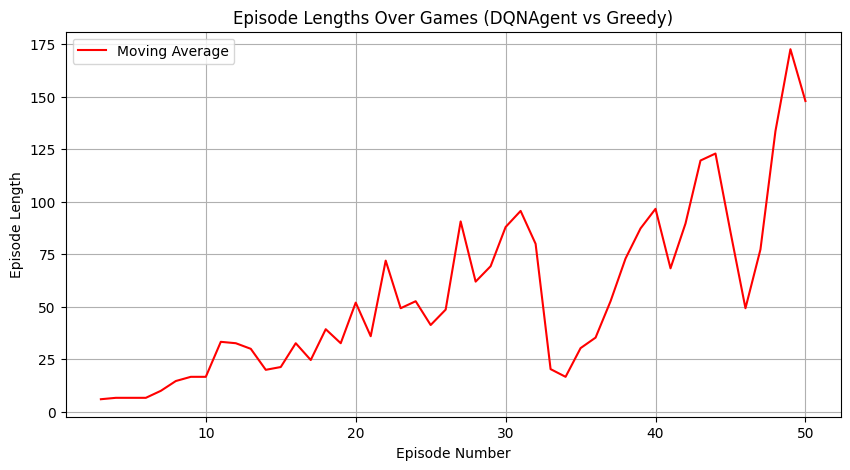

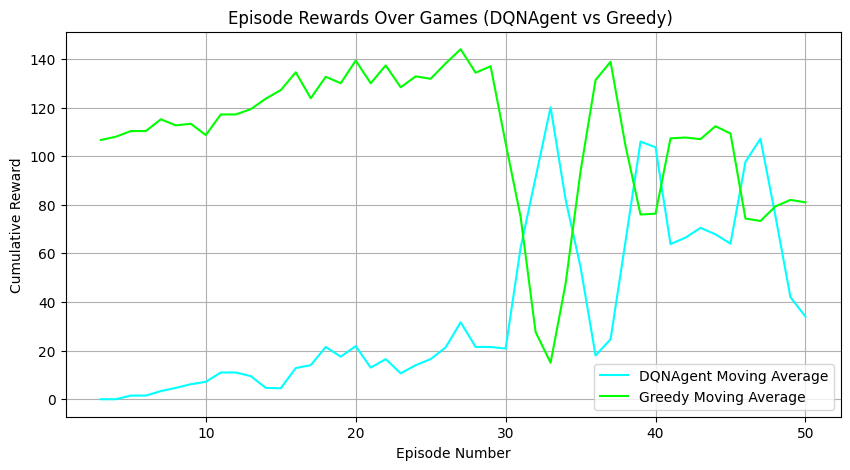

Games: 1275it [27:52,  1.31s/it]


In [ ]:
''' DQN AGENT '''
input_shape = env.observation_space.shape
model = DQNModel(input_shape, nb_actions)
memory = ReplayMemory(env=env)
nb_steps= 50
nb_steps_warmup=nb_steps/10
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_function = nn.MSELoss()
dqn = DQNAgent(model=model, memory=memory, nb_steps_warmup=nb_steps_warmup, epsilon_decay_steps=nb_steps, target_model_update=1e-2)
dqn.compile(optimizer=optimizer, loss_function=loss_function)
dqn.fit(env, enemy_agent=GreedyAgent(), batch_size=1, nb_steps=nb_steps, visualize=False, verbose=2)

To play the XiangQi environment, we chose a pytorch implementation of a DQNAgent (instead of tensorflow due to specific environment compatibility issues). The model is a neural network that takes in the observation of the current environment and maps each state to action values.

After the specified warmup steps, every following step will use the stored states in memory to select (epsilon-greedily) the max of the q-values in the projected next state-space. That is, from the current board, the DQN Agent will greedily select the next states using the target network.

We simulate 50 games and have the DQN agent play against a greedy agent. From the plots we can observe the DQN agent begins to learn from its stored experiences, as average episode length increases and the agent learns to make smarter moves. Additionally, the DQN agent begins to accumulative greater average rewards and acquires more wins.

The overall win rate for the DQN agent is 16% of games.

### Test Case 4: Create a DDQN agent



Games:   0%|          | 0/50 [00:00<?, ?it/s]

Round: 0
Ally made the move CANNON_2 from [7, 7] to [0, 7].
Reward: 4.0
Round: 1
Enemy made the move CHARIOT_1 from [0, 8] to [0, 7].
Reward: 4.5
Round: 2
Ally made the move SOLDIER_4 from [6, 6] to [5, 6].
Reward: 0.0
Round: 3
Enemy made the move CANNON_2 from [2, 1] to [9, 1].
Reward: 4.0
Round: 4
Ally made the move CHARIOT_2 from [9, 8] to [8, 8].
Reward: 0.0
Round: 5
Enemy made the move CANNON_2 from [9, 1] to [9, 3].
Reward: 2.0
Round: 6
Ally made the move SOLDIER_2 from [6, 2] to [5, 2].
Reward: 0.0
Round: 7
Enemy made the move CANNON_2 from [9, 3] to [9, 0].
Reward: 9.0
Round: 8
Ally made the move SOLDIER_2 from [5, 2] to [4, 2].
Reward: 0.0
Round: 9
Enemy made the move CANNON_2 from [9, 0] to [9, 4].
Reward: 100.0



Games:   2%|▏         | 1/50 [00:05<04:10,  5.10s/it]

Step: 1/50 | Length of Game: 10 | Epsilon: 0.9802
Round: 0
Ally made the move CANNON_2 from [7, 7] to [7, 3].
Reward: 0.0
Round: 1
Enemy made the move CANNON_2 from [2, 1] to [9, 1].
Reward: 4.0
Round: 2
Ally made the move ELEPHANT_1 from [9, 2] to [7, 4].
Reward: 0.0
Round: 3
Enemy made the move CANNON_2 from [9, 1] to [9, 4].
Reward: 100.0



Games:   6%|▌         | 3/50 [00:07<01:37,  2.08s/it]

Step: 2/50 | Length of Game: 4 | Epsilon: 0.9604
Round: 0
Ally made the move CANNON_1 from [7, 1] to [7, 6].
Reward: 0.0
Round: 1
Enemy made the move CANNON_1 from [2, 7] to [9, 7].
Reward: 4.0
Round: 2
Ally made the move HORSE_1 from [9, 1] to [7, 2].
Reward: 0.0
Round: 3
Enemy made the move CANNON_1 from [9, 7] to [9, 5].
Reward: 2.0
Round: 4
Ally made the move CANNON_2 from [7, 7] to [1, 7].
Reward: 0.0
Round: 5
Enemy made the move CANNON_1 from [9, 5] to [9, 8].
Reward: 9.0
Round: 6
Ally made the move SOLDIER_4 from [6, 6] to [5, 6].
Reward: 0.0
Round: 7
Enemy made the move CANNON_1 from [9, 8] to [9, 4].
Reward: 100.0



Games:  12%|█▏        | 6/50 [00:11<01:11,  1.63s/it]

Step: 3/50 | Length of Game: 8 | Epsilon: 0.9406
Round: 0
Ally made the move CANNON_2 from [7, 7] to [7, 6].
Reward: 0.0
Round: 1
Enemy made the move CANNON_2 from [2, 1] to [9, 1].
Reward: 4.0
Round: 2
Ally made the move CHARIOT_1 from [9, 0] to [9, 1].
Reward: 4.5
Round: 3
Enemy made the move CANNON_1 from [2, 7] to [2, 4].
Reward: 0.0
Round: 4
Ally made the move HORSE_2 from [9, 7] to [7, 8].
Reward: 0.0
Round: 5
Enemy made the move CANNON_1 from [2, 4] to [6, 4].
Reward: 1.0
Round: 6
Ally made the move CANNON_1 from [7, 1] to [7, 2].
Reward: 0.0
Round: 7
Enemy made the move CANNON_1 from [6, 4] to [6, 0].
Reward: 1.0
Round: 8
Ally made the move CANNON_1 from [7, 2] to [7, 3].
Reward: 0.0
Round: 9
Enemy made the move CANNON_1 from [6, 0] to [6, 6].
Reward: 1.0
Round: 10
Ally made the move CANNON_2 from [7, 6] to [7, 7].
Reward: 0.0
Round: 11
Enemy made the move CANNON_1 from [6, 6] to [6, 4].
Reward: 0.0
Round: 12
Ally made the move SOLDIER_5 from [6, 8] to [5, 8].
Reward: 0.0
Round


Games:  20%|██        | 10/50 [00:27<01:57,  2.93s/it]

Step: 4/50 | Length of Game: 32 | Epsilon: 0.9208
Round: 0
Ally made the move CANNON_1 from [7, 1] to [3, 1].
Reward: 0.0
Round: 1
Enemy made the move CANNON_1 from [2, 7] to [9, 7].
Reward: 4.0
Round: 2
Ally made the move CANNON_1 from [3, 1] to [0, 1].
Reward: 4.0
Round: 3
Enemy made the move CHARIOT_2 from [0, 0] to [0, 1].
Reward: 4.5
Round: 4
Ally made the move CANNON_2 from [7, 7] to [4, 7].
Reward: 0.0
Round: 5
Enemy made the move CANNON_1 from [9, 7] to [9, 5].
Reward: 2.0
Round: 6
Ally made the move CANNON_2 from [4, 7] to [4, 2].
Reward: 0.0
Round: 7
Enemy made the move CANNON_1 from [9, 5] to [9, 8].
Reward: 9.0
Round: 8
Ally made the move CANNON_2 from [4, 2] to [0, 2].
Reward: 2.0
Round: 9
Enemy made the move CANNON_1 from [9, 8] to [9, 4].
Reward: 100.0



Games:  30%|███       | 15/50 [00:32<01:09,  1.99s/it]

Step: 5/50 | Length of Game: 10 | Epsilon: 0.9010
Round: 0
Ally made the move CANNON_2 from [7, 7] to [0, 7].
Reward: 4.0
Round: 1
Enemy made the move CHARIOT_1 from [0, 8] to [0, 7].
Reward: 4.5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1, 129600])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Round: 2
Ally made the move CANNON_1 from [7, 1] to [4, 1].
Reward: 0.0
Round: 3
Enemy made the move CANNON_2 from [2, 1] to [9, 1].
Reward: 4.0
Round: 4
Ally made the move CANNON_1 from [4, 1] to [4, 8].
Reward: 0.0
Round: 5
Enemy made the move SOLDIER_1 from [3, 8] to [4, 8].
Reward: 4.5
Round: 6
Ally made the move ELEPHANT_2 from [9, 6] to [7, 8].
Reward: 0.0
Round: 7
Enemy made the move CANNON_2 from [9, 1] to [9, 3].
Reward: 2.0
Round: 8
Ally made the move HORSE_2 from [9, 7] to [7, 6].
Reward: 0.0
Round: 9
Enemy made the move CANNON_2 from [9, 3] to [9, 0].
Reward: 9.0
Round: 10
Ally made the move CHARIOT_2 from [9, 8] to [9, 7].
Reward: 0.0
Round: 11
Enemy made the move CANNON_2 from [9, 0] to [9, 4].
Reward: 100.0



Games:  42%|████▏     | 21/50 [00:40<00:48,  1.68s/it]

Step: 6/50 | Length of Game: 12 | Epsilon: 0.8812
Round: 0
Ally made the move CANNON_1 from [7, 1] to [7, 2].
Reward: 0.0
Round: 1
Enemy made the move CANNON_1 from [2, 7] to [9, 7].
Reward: 4.0
Round: 2
Ally made the move CHARIOT_2 from [9, 8] to [9, 7].
Reward: 4.5
Round: 3
Enemy made the move CANNON_2 from [2, 1] to [2, 5].
Reward: 0.0
Round: 4
Ally made the move CANNON_2 from [7, 7] to [6, 7].
Reward: 0.0
Round: 5
Enemy made the move ELEPHANT_1 from [0, 6] to [2, 8].
Reward: 0.0
Round: 6
Ally made the move CANNON_1 from [7, 2] to [7, 6].
Reward: 0.0
Round: 7
Enemy made the move SOLDIER_1 from [3, 8] to [4, 8].
Reward: 0.0
Round: 8
Ally made the move CANNON_1 from [7, 6] to [3, 6].
Reward: 1.0
Round: 9
Enemy made the move ELEPHANT_1 from [2, 8] to [0, 6].
Reward: 0.0
Round: 10
Ally made the move ELEPHANT_2 from [9, 6] to [7, 4].
Reward: 0.0
Round: 11
Enemy made the move ADVISOR_1 from [0, 5] to [1, 4].
Reward: 0.0
Round: 12
Ally made the move CANNON_1 from [3, 6] to [5, 6].
Reward: 


Games:  56%|█████▌    | 28/50 [00:54<00:40,  1.83s/it]

Step: 7/50 | Length of Game: 22 | Epsilon: 0.8614
Round: 0
Ally made the move ADVISOR_2 from [9, 5] to [8, 4].
Reward: 0.0
Round: 1
Enemy made the move CANNON_1 from [2, 7] to [9, 7].
Reward: 4.0
Round: 2
Ally made the move ELEPHANT_1 from [9, 2] to [7, 4].
Reward: 0.0
Round: 3
Enemy made the move CANNON_1 from [9, 7] to [9, 4].
Reward: 100.0



Games:  72%|███████▏  | 36/50 [00:57<00:16,  1.21s/it]

Step: 8/50 | Length of Game: 4 | Epsilon: 0.8416
Round: 0
Ally made the move CANNON_2 from [7, 7] to [7, 4].
Reward: 0.0
Round: 1
Enemy made the move CANNON_2 from [2, 1] to [9, 1].
Reward: 4.0
Round: 2
Ally made the move CANNON_1 from [7, 1] to [7, 0].
Reward: 0.0
Round: 3
Enemy made the move CANNON_2 from [9, 1] to [9, 3].
Reward: 2.0
Round: 4
Ally made the move CHARIOT_2 from [9, 8] to [7, 8].
Reward: 0.0
Round: 5
Enemy made the move CANNON_2 from [9, 3] to [9, 0].
Reward: 9.0
Round: 6
Ally made the move SOLDIER_3 from [6, 4] to [5, 4].
Reward: 0.0
Round: 7
Enemy made the move CANNON_2 from [9, 0] to [9, 4].
Reward: 100.0



Games:  90%|█████████ | 45/50 [01:02<00:04,  1.05it/s]

Step: 9/50 | Length of Game: 8 | Epsilon: 0.8218
Round: 0
Ally made the move CANNON_1 from [7, 1] to [0, 1].
Reward: 4.0
Round: 1
Enemy made the move CHARIOT_2 from [0, 0] to [0, 1].
Reward: 4.5
Round: 2
Ally made the move SOLDIER_4 from [6, 6] to [5, 6].
Reward: 0.0
Round: 3
Enemy made the move CANNON_1 from [2, 7] to [9, 7].
Reward: 4.0
Round: 4
Ally made the move CHARIOT_2 from [9, 8] to [9, 7].
Reward: 4.5
Round: 5
Enemy made the move CHARIOT_1 from [0, 8] to [1, 8].
Reward: 0.0
Round: 6
Ally made the move CANNON_2 from [7, 7] to [7, 2].
Reward: 0.0
Round: 7
Enemy made the move CANNON_2 from [2, 1] to [2, 5].
Reward: 0.0
Round: 8
Ally made the move CHARIOT_2 from [9, 7] to [0, 7].
Reward: 4.0
Round: 9
Enemy made the move CHARIOT_2 from [0, 1] to [9, 1].
Reward: 4.0
Round: 10
Ally made the move CANNON_2 from [7, 2] to [8, 2].
Reward: 0.0
Round: 11
Enemy made the move CHARIOT_2 from [9, 1] to [9, 0].
Reward: 9.0
Round: 12
Ally made the move CHARIOT_2 from [0, 7] to [0, 6].
Reward: 2.


Games: 55it [01:29,  1.63s/it]                        

Step: 10/50 | Length of Game: 42 | Epsilon: 0.8020
Round: 0
Ally made the move CANNON_1 from [7, 1] to [0, 1].
Reward: 4.0
Round: 1
Enemy made the move CHARIOT_2 from [0, 0] to [0, 1].
Reward: 4.5
Round: 2
Ally made the move CANNON_2 from [7, 7] to [7, 6].
Reward: 0.0
Round: 3
Enemy made the move CHARIOT_1 from [0, 8] to [1, 8].
Reward: 0.0
Round: 4
Ally made the move CANNON_2 from [7, 6] to [7, 7].
Reward: 0.0
Round: 5
Enemy made the move CANNON_1 from [2, 7] to [9, 7].
Reward: 4.0
Round: 6
Ally made the move CANNON_2 from [7, 7] to [7, 2].
Reward: 0.0
Round: 7
Enemy made the move CANNON_1 from [9, 7] to [9, 5].
Reward: 2.0
Round: 8
Ally made the move CANNON_2 from [7, 2] to [7, 3].
Reward: 0.0
Round: 9
Enemy made the move CANNON_1 from [9, 5] to [9, 8].
Reward: 9.0
Round: 10
Ally made the move CANNON_2 from [7, 3] to [7, 7].
Reward: 0.0
Round: 11
Enemy made the move CANNON_1 from [9, 8] to [9, 4].
Reward: 100.0



Games: 66it [01:36,  1.28s/it]

Step: 11/50 | Length of Game: 12 | Epsilon: 0.7822
Round: 0
Ally made the move CANNON_1 from [7, 1] to [0, 1].
Reward: 4.0
Round: 1
Enemy made the move CHARIOT_2 from [0, 0] to [0, 1].
Reward: 4.5
Round: 2
Ally made the move CANNON_2 from [7, 7] to [7, 5].
Reward: 0.0
Round: 3
Enemy made the move ADVISOR_1 from [0, 5] to [1, 4].
Reward: 0.0
Round: 4
Ally made the move ELEPHANT_1 from [9, 2] to [7, 0].
Reward: 0.0
Round: 5
Enemy made the move HORSE_1 from [0, 7] to [2, 6].
Reward: 0.0
Round: 6
Ally made the move SOLDIER_2 from [6, 2] to [5, 2].
Reward: 0.0
Round: 7
Enemy made the move HORSE_1 from [2, 6] to [0, 7].
Reward: 0.0
Round: 8
Ally made the move ELEPHANT_2 from [9, 6] to [7, 8].
Reward: 0.0
Round: 9
Enemy made the move CANNON_2 from [2, 1] to [8, 1].
Reward: 0.0
Round: 10
Ally made the move ADVISOR_2 from [9, 5] to [8, 4].
Reward: 0.0
Round: 11
Enemy made the move ELEPHANT_1 from [0, 6] to [2, 8].
Reward: 0.0
Round: 12
Ally made the move ELEPHANT_2 from [7, 8] to [5, 6].
Reward


Games: 78it [02:03,  1.64s/it]

Step: 12/50 | Length of Game: 42 | Epsilon: 0.7624
Round: 0
Ally made the move CANNON_2 from [7, 7] to [3, 7].
Reward: 0.0
Round: 1
Enemy made the move CANNON_1 from [2, 7] to [9, 7].
Reward: 4.0
Round: 2
Ally made the move CHARIOT_2 from [9, 8] to [9, 7].
Reward: 4.5
Round: 3
Enemy made the move CANNON_2 from [2, 1] to [9, 1].
Reward: 4.0
Round: 4
Ally made the move CANNON_1 from [7, 1] to [6, 1].
Reward: 0.0
Round: 5
Enemy made the move CANNON_2 from [9, 1] to [9, 3].
Reward: 2.0
Round: 6
Ally made the move GENERAL from [9, 4] to [8, 4].
Reward: 0.0
Round: 7
Enemy made the move CANNON_2 from [9, 3] to [9, 0].
Reward: 9.0
Round: 8
Ally made the move CANNON_2 from [3, 7] to [5, 7].
Reward: 0.0
Round: 9
Enemy made the move CANNON_2 from [9, 0] to [9, 5].
Reward: 2.0
Round: 10
Ally made the move CHARIOT_2 from [9, 7] to [8, 7].
Reward: 0.0
Round: 11
Enemy made the move ADVISOR_1 from [0, 5] to [1, 4].
Reward: 0.0
Round: 12
Ally made the move CHARIOT_2 from [8, 7] to [8, 6].
Reward: 0.0
R


Games: 91it [02:49,  2.33s/it]

Step: 13/50 | Length of Game: 72 | Epsilon: 0.7426
Round: 0
Ally made the move CANNON_2 from [7, 7] to [7, 2].
Reward: 0.0
Round: 1
Enemy made the move CANNON_2 from [2, 1] to [9, 1].
Reward: 4.0
Round: 2
Ally made the move CANNON_2 from [7, 2] to [7, 7].
Reward: 0.0
Round: 3
Enemy made the move CANNON_1 from [2, 7] to [9, 7].
Reward: 4.0
Round: 4
Ally made the move CHARIOT_1 from [9, 0] to [9, 1].
Reward: 4.5
Round: 5
Enemy made the move CANNON_1 from [9, 7] to [9, 5].
Reward: 2.0
Round: 6
Ally made the move CHARIOT_2 from [9, 8] to [9, 7].
Reward: 0.0
Round: 7
Enemy made the move CANNON_1 from [9, 5] to [9, 7].
Reward: 9.0
Round: 8
Ally made the move CANNON_1 from [7, 1] to [1, 1].
Reward: 0.0
Round: 9
Enemy made the move CANNON_1 from [9, 7] to [9, 4].
Reward: 100.0



Games: 105it [02:56,  1.66s/it]

Step: 14/50 | Length of Game: 10 | Epsilon: 0.7228
Round: 0
Ally made the move ADVISOR_1 from [9, 3] to [8, 4].
Reward: 0.0
Round: 1
Enemy made the move CANNON_1 from [2, 7] to [9, 7].
Reward: 4.0
Round: 2
Ally made the move HORSE_1 from [9, 1] to [7, 2].
Reward: 0.0
Round: 3
Enemy made the move CANNON_1 from [9, 7] to [9, 5].
Reward: 2.0
Round: 4
Ally made the move GENERAL from [9, 4] to [9, 5].
Reward: 4.5
Round: 5
Enemy made the move SOLDIER_2 from [3, 6] to [4, 6].
Reward: 0.0
Round: 6
Ally made the move CANNON_1 from [7, 1] to [6, 1].
Reward: 0.0
Round: 7
Enemy made the move ELEPHANT_1 from [0, 6] to [2, 8].
Reward: 0.0
Round: 8
Ally made the move CANNON_2 from [7, 7] to [7, 4].
Reward: 0.0
Round: 9
Enemy made the move CANNON_2 from [2, 1] to [2, 2].
Reward: 0.0
Round: 10
Ally made the move CANNON_2 from [7, 4] to [3, 4].
Reward: 1.0
Round: 11
Enemy made the move CANNON_2 from [2, 2] to [6, 2].
Reward: 1.0
Round: 12
Ally made the move CANNON_2 from [3, 4] to [3, 0].
Reward: 1.0
Ro


Games: 120it [03:32,  1.94s/it]

Step: 15/50 | Length of Game: 58 | Epsilon: 0.7030
Round: 0
Ally made the move CANNON_1 from [7, 1] to [0, 1].
Reward: 4.0
Round: 1
Enemy made the move CHARIOT_2 from [0, 0] to [0, 1].
Reward: 4.5
Round: 2
Ally made the move CANNON_2 from [7, 7] to [6, 7].
Reward: 0.0
Round: 3
Enemy made the move CANNON_1 from [2, 7] to [9, 7].
Reward: 4.0
Round: 4
Ally made the move CHARIOT_2 from [9, 8] to [9, 7].
Reward: 4.5
Round: 5
Enemy made the move CANNON_2 from [2, 1] to [2, 0].
Reward: 0.0
Round: 6
Ally made the move SOLDIER_5 from [6, 8] to [5, 8].
Reward: 0.0
Round: 7
Enemy made the move CHARIOT_2 from [0, 1] to [9, 1].
Reward: 4.0
Round: 8
Ally made the move SOLDIER_1 from [6, 0] to [5, 0].
Reward: 0.0
Round: 9
Enemy made the move CHARIOT_2 from [9, 1] to [9, 0].
Reward: 9.0
Round: 10
Ally made the move CANNON_2 from [6, 7] to [3, 7].
Reward: 0.0
Round: 11
Enemy made the move CHARIOT_2 from [9, 0] to [9, 2].
Reward: 2.0
Round: 12
Ally made the move SOLDIER_4 from [6, 6] to [5, 6].
Reward: 


Games: 136it [04:23,  2.37s/it]

Step: 16/50 | Length of Game: 80 | Epsilon: 0.6832
Round: 0
Ally made the move CANNON_2 from [7, 7] to [7, 3].
Reward: 0.0
Round: 1
Enemy made the move CANNON_2 from [2, 1] to [9, 1].
Reward: 4.0
Round: 2
Ally made the move CHARIOT_1 from [9, 0] to [9, 1].
Reward: 4.5
Round: 3
Enemy made the move CANNON_1 from [2, 7] to [2, 2].
Reward: 0.0
Round: 4
Ally made the move CANNON_2 from [7, 3] to [5, 3].
Reward: 0.0
Round: 5
Enemy made the move CANNON_1 from [2, 2] to [6, 2].
Reward: 1.0
Round: 6
Ally made the move CANNON_2 from [5, 3] to [5, 2].
Reward: 0.0
Round: 7
Enemy made the move CANNON_1 from [6, 2] to [6, 6].
Reward: 1.0
Round: 8
Ally made the move CANNON_1 from [7, 1] to [4, 1].
Reward: 0.0
Round: 9
Enemy made the move CANNON_1 from [6, 6] to [6, 0].
Reward: 1.0
Round: 10
Ally made the move CANNON_1 from [4, 1] to [4, 0].
Reward: 0.0
Round: 11
Enemy made the move SOLDIER_5 from [3, 0] to [4, 0].
Reward: 4.5
Round: 12
Ally made the move CHARIOT_1 from [9, 1] to [0, 1].
Reward: 4.0
R


Games: 153it [04:35,  1.78s/it]

Round: 18
Ally made the move CANNON_2 from [0, 2] to [0, 4].
Reward: 100.0
1
Step: 17/50 | Length of Game: 19 | Epsilon: 0.6634
Round: 0
Ally made the move SOLDIER_2 from [6, 2] to [5, 2].
Reward: 0.0
Round: 1
Enemy made the move CANNON_1 from [2, 7] to [9, 7].
Reward: 4.0
Round: 2
Ally made the move CANNON_2 from [7, 7] to [7, 8].
Reward: 0.0
Round: 3
Enemy made the move CANNON_2 from [2, 1] to [9, 1].
Reward: 4.0
Round: 4
Ally made the move ADVISOR_2 from [9, 5] to [8, 4].
Reward: 0.0
Round: 5
Enemy made the move CANNON_1 from [9, 7] to [9, 4].
Reward: 100.0



Games: 171it [04:38,  1.24s/it]

Step: 18/50 | Length of Game: 6 | Epsilon: 0.6436
Round: 0
Ally made the move CANNON_1 from [7, 1] to [0, 1].
Reward: 4.0
Round: 1
Enemy made the move CHARIOT_2 from [0, 0] to [0, 1].
Reward: 4.5
Round: 2
Ally made the move CANNON_2 from [7, 7] to [0, 7].
Reward: 4.0
Round: 3
Enemy made the move CHARIOT_1 from [0, 8] to [0, 7].
Reward: 4.5
Round: 4
Ally made the move SOLDIER_3 from [6, 4] to [5, 4].
Reward: 0.0
Round: 5
Enemy made the move SOLDIER_2 from [3, 6] to [4, 6].
Reward: 0.0
Round: 6
Ally made the move SOLDIER_5 from [6, 8] to [5, 8].
Reward: 0.0
Round: 7
Enemy made the move CANNON_1 from [2, 7] to [3, 7].
Reward: 0.0
Round: 8
Ally made the move SOLDIER_1 from [6, 0] to [5, 0].
Reward: 0.0
Round: 9
Enemy made the move GENERAL from [0, 4] to [1, 4].
Reward: 0.0
Round: 10
Ally made the move HORSE_1 from [9, 1] to [7, 2].
Reward: 0.0
Round: 11
Enemy made the move CANNON_1 from [3, 7] to [1, 7].
Reward: 0.0
Round: 12
Ally made the move CHARIOT_2 from [9, 8] to [6, 8].
Reward: 0.0



Games: 190it [05:08,  1.34s/it]

Step: 19/50 | Length of Game: 46 | Epsilon: 0.6238
Round: 0
Ally made the move CANNON_1 from [7, 1] to [0, 1].
Reward: 4.0
Round: 1
Enemy made the move CHARIOT_2 from [0, 0] to [0, 1].
Reward: 4.5
Round: 2
Ally made the move CANNON_2 from [7, 7] to [7, 5].
Reward: 0.0
Round: 3
Enemy made the move SOLDIER_3 from [3, 4] to [4, 4].
Reward: 0.0
Round: 4
Ally made the move ELEPHANT_2 from [9, 6] to [7, 8].
Reward: 0.0
Round: 5
Enemy made the move CANNON_2 from [2, 1] to [6, 1].
Reward: 0.0
Round: 6
Ally made the move CANNON_2 from [7, 5] to [8, 5].
Reward: 0.0
Round: 7
Enemy made the move CANNON_2 from [6, 1] to [6, 4].
Reward: 1.0
Round: 8
Ally made the move CANNON_2 from [8, 5] to [7, 5].
Reward: 0.0
Round: 9
Enemy made the move CHARIOT_2 from [0, 1] to [9, 1].
Reward: 4.0
Round: 10
Ally made the move GENERAL from [9, 4] to [8, 4].
Reward: 0.0
Round: 11
Enemy made the move CHARIOT_2 from [9, 1] to [9, 0].
Reward: 9.0
Round: 12
Ally made the move CANNON_2 from [7, 5] to [7, 3].
Reward: 0.0


Games: 210it [05:19,  1.08s/it]

Step: 20/50 | Length of Game: 18 | Epsilon: 0.6040
Round: 0
Ally made the move CANNON_1 from [7, 1] to [7, 0].
Reward: 0.0
Round: 1
Enemy made the move CANNON_1 from [2, 7] to [9, 7].
Reward: 4.0
Round: 2
Ally made the move CHARIOT_2 from [9, 8] to [9, 7].
Reward: 4.5
Round: 3
Enemy made the move ELEPHANT_2 from [0, 2] to [2, 0].
Reward: 0.0
Round: 4
Ally made the move CHARIOT_2 from [9, 7] to [9, 8].
Reward: 0.0
Round: 5
Enemy made the move ELEPHANT_1 from [0, 6] to [2, 4].
Reward: 0.0
Round: 6
Ally made the move CANNON_1 from [7, 0] to [3, 0].
Reward: 1.0
Round: 7
Enemy made the move CANNON_2 from [2, 1] to [2, 3].
Reward: 0.0
Round: 8
Ally made the move SOLDIER_2 from [6, 2] to [5, 2].
Reward: 0.0
Round: 9
Enemy made the move CANNON_2 from [2, 3] to [5, 3].
Reward: 0.0
Round: 10
Ally made the move ELEPHANT_2 from [9, 6] to [7, 8].
Reward: 0.0
Round: 11
Enemy made the move CHARIOT_1 from [0, 8] to [2, 8].
Reward: 0.0
Round: 12
Ally made the move ADVISOR_2 from [9, 5] to [8, 4].
Rewar


Games: 231it [06:14,  1.59s/it]

Round: 86
Ally made the move CHARIOT_2 from [0, 6] to [0, 4].
Reward: 100.0
2
Step: 21/50 | Length of Game: 87 | Epsilon: 0.5842
Round: 0
Ally made the move HORSE_2 from [9, 7] to [7, 8].
Reward: 0.0
Round: 1
Enemy made the move CANNON_2 from [2, 1] to [9, 1].
Reward: 4.0
Round: 2
Ally made the move CANNON_1 from [7, 1] to [7, 6].
Reward: 0.0
Round: 3
Enemy made the move CANNON_2 from [9, 1] to [9, 3].
Reward: 2.0
Round: 4
Ally made the move ELEPHANT_2 from [9, 6] to [7, 4].
Reward: 0.0
Round: 5
Enemy made the move CANNON_2 from [9, 3] to [9, 0].
Reward: 9.0
Round: 6
Ally made the move ADVISOR_2 from [9, 5] to [8, 4].
Reward: 0.0
Round: 7
Enemy made the move CANNON_2 from [9, 0] to [9, 4].
Reward: 100.0



Games: 253it [06:19,  1.14s/it]

Step: 22/50 | Length of Game: 8 | Epsilon: 0.5644
Round: 0
Ally made the move CANNON_2 from [7, 7] to [8, 7].
Reward: 0.0
Round: 1
Enemy made the move CANNON_1 from [2, 7] to [9, 7].
Reward: 4.0
Round: 2
Ally made the move ADVISOR_1 from [9, 3] to [8, 4].
Reward: 0.0
Round: 3
Enemy made the move CANNON_2 from [2, 1] to [9, 1].
Reward: 4.0
Round: 4
Ally made the move CANNON_2 from [8, 7] to [1, 7].
Reward: 0.0
Round: 5
Enemy made the move CANNON_2 from [9, 1] to [9, 4].
Reward: 100.0



Games: 276it [06:23,  1.23it/s]

Step: 23/50 | Length of Game: 6 | Epsilon: 0.5446
Round: 0
Ally made the move CANNON_2 from [7, 7] to [5, 7].
Reward: 0.0
Round: 1
Enemy made the move CANNON_1 from [2, 7] to [9, 7].
Reward: 4.0
Round: 2
Ally made the move ELEPHANT_1 from [9, 2] to [7, 0].
Reward: 0.0
Round: 3
Enemy made the move CANNON_2 from [2, 1] to [9, 1].
Reward: 4.0
Round: 4
Ally made the move CANNON_2 from [5, 7] to [8, 7].
Reward: 0.0
Round: 5
Enemy made the move CANNON_2 from [9, 1] to [9, 4].
Reward: 100.0



Games: 300it [06:26,  1.68it/s]

Step: 24/50 | Length of Game: 6 | Epsilon: 0.5248
Round: 0
Ally made the move CANNON_1 from [7, 1] to [0, 1].
Reward: 4.0
Round: 1
Enemy made the move CHARIOT_2 from [0, 0] to [0, 1].
Reward: 4.5
Round: 2
Ally made the move CANNON_2 from [7, 7] to [0, 7].
Reward: 4.0
Round: 3
Enemy made the move CHARIOT_1 from [0, 8] to [0, 7].
Reward: 4.5
Round: 4
Ally made the move ADVISOR_1 from [9, 3] to [8, 4].
Reward: 0.0
Round: 5
Enemy made the move CANNON_1 from [2, 7] to [2, 3].
Reward: 0.0
Round: 6
Ally made the move HORSE_2 from [9, 7] to [7, 6].
Reward: 0.0
Round: 7
Enemy made the move CANNON_2 from [2, 1] to [5, 1].
Reward: 0.0
Round: 8
Ally made the move CHARIOT_2 from [9, 8] to [9, 7].
Reward: 0.0
Round: 9
Enemy made the move CHARIOT_1 from [0, 7] to [9, 7].
Reward: 9.0
Round: 10
Ally made the move HORSE_2 from [7, 6] to [9, 7].
Reward: 9.0
Round: 11
Enemy made the move ADVISOR_1 from [0, 5] to [1, 4].
Reward: 0.0
Round: 12
Ally made the move SOLDIER_5 from [6, 8] to [5, 8].
Reward: 0.0



Games: 325it [07:36,  1.32s/it]

Step: 25/50 | Length of Game: 110 | Epsilon: 0.5050
Round: 0
Ally made the move ELEPHANT_1 from [9, 2] to [7, 4].
Reward: 0.0
Round: 1
Enemy made the move CANNON_1 from [2, 7] to [9, 7].
Reward: 4.0
Round: 2
Ally made the move GENERAL from [9, 4] to [8, 4].
Reward: 0.0
Round: 3
Enemy made the move CANNON_2 from [2, 1] to [9, 1].
Reward: 4.0
Round: 4
Ally made the move CHARIOT_1 from [9, 0] to [9, 1].
Reward: 4.5
Round: 5
Enemy made the move CANNON_1 from [9, 7] to [9, 5].
Reward: 2.0
Round: 6
Ally made the move CANNON_1 from [7, 1] to [2, 1].
Reward: 0.0
Round: 7
Enemy made the move CANNON_1 from [9, 5] to [9, 1].
Reward: 9.0
Round: 8
Ally made the move CANNON_1 from [2, 1] to [2, 5].
Reward: 0.0
Round: 9
Enemy made the move CANNON_1 from [9, 1] to [9, 6].
Reward: 2.0
Round: 10
Ally made the move ELEPHANT_1 from [7, 4] to [9, 6].
Reward: 4.5
Round: 11
Enemy made the move CHARIOT_2 from [0, 0] to [1, 0].
Reward: 0.0
Round: 12
Ally made the move GENERAL from [8, 4] to [9, 4].
Reward: 0.0


Games: 351it [08:05,  1.26s/it]

Round: 46
Ally made the move CHARIOT_2 from [7, 5] to [0, 5].
Reward: 100.0
3
Step: 26/50 | Length of Game: 47 | Epsilon: 0.4852
Round: 0
Ally made the move CANNON_1 from [7, 1] to [0, 1].
Reward: 4.0
Round: 1
Enemy made the move CHARIOT_2 from [0, 0] to [0, 1].
Reward: 4.5
Round: 2
Ally made the move CANNON_2 from [7, 7] to [0, 7].
Reward: 4.0
Round: 3
Enemy made the move CHARIOT_1 from [0, 8] to [0, 7].
Reward: 4.5
Round: 4
Ally made the move CHARIOT_1 from [9, 0] to [7, 0].
Reward: 0.0
Round: 5
Enemy made the move SOLDIER_4 from [3, 2] to [4, 2].
Reward: 0.0
Round: 6
Ally made the move SOLDIER_2 from [6, 2] to [5, 2].
Reward: 0.0
Round: 7
Enemy made the move SOLDIER_4 from [4, 2] to [5, 2].
Reward: 1.0
Round: 8
Ally made the move CHARIOT_1 from [7, 0] to [7, 6].
Reward: 0.0
Round: 9
Enemy made the move SOLDIER_1 from [3, 8] to [4, 8].
Reward: 0.0
Round: 10
Ally made the move SOLDIER_1 from [6, 0] to [5, 0].
Reward: 0.0
Round: 11
Enemy made the move CHARIOT_1 from [0, 7] to [1, 7].
R


Games: 378it [08:17,  1.02it/s]

Step: 27/50 | Length of Game: 18 | Epsilon: 0.4654
Round: 0
Ally made the move CANNON_1 from [7, 1] to [7, 6].
Reward: 0.0
Round: 1
Enemy made the move CANNON_1 from [2, 7] to [9, 7].
Reward: 4.0
Round: 2
Ally made the move CHARIOT_2 from [9, 8] to [9, 7].
Reward: 4.5
Round: 3
Enemy made the move CHARIOT_1 from [0, 8] to [1, 8].
Reward: 0.0
Round: 4
Ally made the move CANNON_1 from [7, 6] to [3, 6].
Reward: 1.0
Round: 5
Enemy made the move CANNON_2 from [2, 1] to [3, 1].
Reward: 0.0
Round: 6
Ally made the move CANNON_1 from [3, 6] to [3, 2].
Reward: 1.0
Round: 7
Enemy made the move CHARIOT_1 from [1, 8] to [1, 5].
Reward: 0.0
Round: 8
Ally made the move CANNON_1 from [3, 2] to [3, 0].
Reward: 1.0
Round: 9
Enemy made the move CHARIOT_2 from [0, 0] to [3, 0].
Reward: 4.5
Round: 10
Ally made the move CHARIOT_1 from [9, 0] to [8, 0].
Reward: 0.0
Round: 11
Enemy made the move CHARIOT_1 from [1, 5] to [9, 5].
Reward: 2.0
Round: 12
Ally made the move CHARIOT_1 from [8, 0] to [7, 0].
Reward: 0


Games: 406it [08:26,  1.31it/s]

Step: 28/50 | Length of Game: 14 | Epsilon: 0.4456
Round: 0
Ally made the move CANNON_1 from [7, 1] to [0, 1].
Reward: 4.0
Round: 1
Enemy made the move CHARIOT_2 from [0, 0] to [0, 1].
Reward: 4.5
Round: 2
Ally made the move ADVISOR_1 from [9, 3] to [8, 4].
Reward: 0.0
Round: 3
Enemy made the move CANNON_1 from [2, 7] to [9, 7].
Reward: 4.0
Round: 4
Ally made the move CHARIOT_2 from [9, 8] to [9, 7].
Reward: 4.5
Round: 5
Enemy made the move CHARIOT_1 from [0, 8] to [2, 8].
Reward: 0.0
Round: 6
Ally made the move ELEPHANT_1 from [9, 2] to [7, 4].
Reward: 0.0
Round: 7
Enemy made the move ADVISOR_2 from [0, 3] to [1, 4].
Reward: 0.0
Round: 8
Ally made the move HORSE_1 from [9, 1] to [8, 3].
Reward: 0.0
Round: 9
Enemy made the move CANNON_2 from [2, 1] to [2, 0].
Reward: 0.0
Round: 10
Ally made the move SOLDIER_3 from [6, 4] to [5, 4].
Reward: 0.0
Round: 11
Enemy made the move CANNON_2 from [2, 0] to [6, 0].
Reward: 1.0
Round: 12
Ally made the move CHARIOT_1 from [9, 0] to [6, 0].
Reward: 


Games: 435it [08:56,  1.17it/s]

Round: 48
Ally made the move CHARIOT_1 from [2, 4] to [1, 4].
Reward: 100.0
4
Step: 29/50 | Length of Game: 49 | Epsilon: 0.4258
Round: 0
Ally made the move SOLDIER_3 from [6, 4] to [5, 4].
Reward: 0.0
Round: 1
Enemy made the move CANNON_1 from [2, 7] to [9, 7].
Reward: 4.0
Round: 2
Ally made the move CHARIOT_2 from [9, 8] to [9, 7].
Reward: 4.5
Round: 3
Enemy made the move CANNON_2 from [2, 1] to [9, 1].
Reward: 4.0
Round: 4
Ally made the move CANNON_1 from [7, 1] to [4, 1].
Reward: 0.0
Round: 5
Enemy made the move CANNON_2 from [9, 1] to [9, 3].
Reward: 2.0
Round: 6
Ally made the move CANNON_1 from [4, 1] to [4, 0].
Reward: 0.0
Round: 7
Enemy made the move CANNON_2 from [9, 3] to [9, 0].
Reward: 9.0
Round: 8
Ally made the move CANNON_1 from [4, 0] to [0, 0].
Reward: 9.0
Round: 9
Enemy made the move CANNON_2 from [9, 0] to [9, 4].
Reward: 100.0



Games: 465it [09:02,  1.54it/s]

Step: 30/50 | Length of Game: 10 | Epsilon: 0.4060
Round: 0
Ally made the move CANNON_1 from [7, 1] to [0, 1].
Reward: 4.0
Round: 1
Enemy made the move CHARIOT_2 from [0, 0] to [0, 1].
Reward: 4.5
Round: 2
Ally made the move CANNON_2 from [7, 7] to [0, 7].
Reward: 4.0
Round: 3
Enemy made the move CHARIOT_1 from [0, 8] to [0, 7].
Reward: 4.5
Round: 4
Ally made the move CHARIOT_1 from [9, 0] to [7, 0].
Reward: 0.0
Round: 5
Enemy made the move CHARIOT_2 from [0, 1] to [1, 1].
Reward: 0.0
Round: 6
Ally made the move SOLDIER_4 from [6, 6] to [5, 6].
Reward: 0.0
Round: 7
Enemy made the move ELEPHANT_1 from [0, 6] to [2, 4].
Reward: 0.0
Round: 8
Ally made the move HORSE_2 from [9, 7] to [7, 6].
Reward: 0.0
Round: 9
Enemy made the move CANNON_1 from [2, 7] to [9, 7].
Reward: 0.0
Round: 10
Ally made the move SOLDIER_1 from [6, 0] to [5, 0].
Reward: 0.0
Round: 11
Enemy made the move CANNON_1 from [9, 7] to [9, 5].
Reward: 2.0
Round: 12
Ally made the move SOLDIER_1 from [5, 0] to [4, 0].
Reward: 


Games: 496it [09:12,  1.84it/s]

Step: 31/50 | Length of Game: 16 | Epsilon: 0.3862
Round: 0
Ally made the move CANNON_1 from [7, 1] to [0, 1].
Reward: 4.0
Round: 1
Enemy made the move CHARIOT_2 from [0, 0] to [0, 1].
Reward: 4.5
Round: 2
Ally made the move CANNON_2 from [7, 7] to [0, 7].
Reward: 4.0
Round: 3
Enemy made the move CHARIOT_1 from [0, 8] to [0, 7].
Reward: 4.5
Round: 4
Ally made the move ELEPHANT_2 from [9, 6] to [7, 4].
Reward: 0.0
Round: 5
Enemy made the move CANNON_2 from [2, 1] to [2, 5].
Reward: 0.0
Round: 6
Ally made the move HORSE_2 from [9, 7] to [8, 5].
Reward: 0.0
Round: 7
Enemy made the move CHARIOT_2 from [0, 1] to [9, 1].
Reward: 4.0
Round: 8
Ally made the move CHARIOT_1 from [9, 0] to [9, 1].
Reward: 9.0
Round: 9
Enemy made the move CANNON_2 from [2, 5] to [9, 5].
Reward: 2.0
Round: 10
Ally made the move GENERAL from [9, 4] to [9, 5].
Reward: 4.5
Round: 11
Enemy made the move CANNON_1 from [2, 7] to [2, 6].
Reward: 0.0
Round: 12
Ally made the move CHARIOT_1 from [9, 1] to [2, 1].
Reward: 0.0


Games: 528it [10:13,  1.02it/s]

Step: 32/50 | Length of Game: 96 | Epsilon: 0.3664
Round: 0
Ally made the move ELEPHANT_1 from [9, 2] to [7, 4].
Reward: 0.0
Round: 1
Enemy made the move CANNON_1 from [2, 7] to [9, 7].
Reward: 4.0
Round: 2
Ally made the move CANNON_2 from [7, 7] to [2, 7].
Reward: 0.0
Round: 3
Enemy made the move CANNON_2 from [2, 1] to [9, 1].
Reward: 4.0
Round: 4
Ally made the move CANNON_2 from [2, 7] to [7, 7].
Reward: 0.0
Round: 5
Enemy made the move CANNON_2 from [9, 1] to [9, 4].
Reward: 100.0



Games: 561it [10:17,  1.42it/s]

Step: 33/50 | Length of Game: 6 | Epsilon: 0.3466
Round: 0
Ally made the move CHARIOT_2 from [9, 8] to [8, 8].
Reward: 0.0
Round: 1
Enemy made the move CANNON_1 from [2, 7] to [9, 7].
Reward: 4.0
Round: 2
Ally made the move CANNON_1 from [7, 1] to [0, 1].
Reward: 4.0
Round: 3
Enemy made the move CHARIOT_2 from [0, 0] to [0, 1].
Reward: 4.5
Round: 4
Ally made the move ADVISOR_1 from [9, 3] to [8, 4].
Reward: 0.0
Round: 5
Enemy made the move CANNON_1 from [9, 7] to [9, 5].
Reward: 2.0
Round: 6
Ally made the move GENERAL from [9, 4] to [9, 5].
Reward: 4.5
Round: 7
Enemy made the move ELEPHANT_2 from [0, 2] to [2, 4].
Reward: 0.0
Round: 8
Ally made the move ADVISOR_1 from [8, 4] to [7, 3].
Reward: 0.0
Round: 9
Enemy made the move CANNON_2 from [2, 1] to [3, 1].
Reward: 0.0
Round: 10
Ally made the move CANNON_2 from [7, 7] to [7, 8].
Reward: 0.0
Round: 11
Enemy made the move HORSE_1 from [0, 7] to [2, 8].
Reward: 0.0
Round: 12
Ally made the move CHARIOT_2 from [8, 8] to [8, 3].
Reward: 0.0



Games: 595it [10:44,  1.37it/s]

Round: 42
Ally made the move CHARIOT_1 from [0, 1] to [0, 3].
Reward: 100.0
5
Step: 34/50 | Length of Game: 43 | Epsilon: 0.3268
Round: 0
Ally made the move ELEPHANT_2 from [9, 6] to [7, 4].
Reward: 0.0
Round: 1
Enemy made the move CANNON_1 from [2, 7] to [9, 7].
Reward: 4.0
Round: 2
Ally made the move CHARIOT_2 from [9, 8] to [9, 7].
Reward: 4.5
Round: 3
Enemy made the move CANNON_2 from [2, 1] to [9, 1].
Reward: 4.0
Round: 4
Ally made the move CHARIOT_1 from [9, 0] to [9, 1].
Reward: 4.5
Round: 5
Enemy made the move SOLDIER_5 from [3, 0] to [4, 0].
Reward: 0.0
Round: 6
Ally made the move CANNON_2 from [7, 7] to [8, 7].
Reward: 0.0
Round: 7
Enemy made the move HORSE_1 from [0, 7] to [2, 8].
Reward: 0.0
Round: 8
Ally made the move CANNON_1 from [7, 1] to [2, 1].
Reward: 0.0
Round: 9
Enemy made the move ELEPHANT_2 from [0, 2] to [2, 0].
Reward: 0.0
Round: 10
Ally made the move CANNON_2 from [8, 7] to [8, 8].
Reward: 0.0
Round: 11
Enemy made the move SOLDIER_5 from [4, 0] to [5, 0].
Rewa


Games: 630it [10:57,  1.63it/s]

Round: 20
Ally made the move CANNON_2 from [0, 6] to [0, 4].
Reward: 100.0
6
Step: 35/50 | Length of Game: 21 | Epsilon: 0.3070
Round: 0
Ally made the move CANNON_1 from [7, 1] to [0, 1].
Reward: 4.0
Round: 1
Enemy made the move CHARIOT_2 from [0, 0] to [0, 1].
Reward: 4.5
Round: 2
Ally made the move CANNON_2 from [7, 7] to [0, 7].
Reward: 4.0
Round: 3
Enemy made the move CHARIOT_1 from [0, 8] to [0, 7].
Reward: 4.5
Round: 4
Ally made the move ADVISOR_2 from [9, 5] to [8, 4].
Reward: 0.0
Round: 5
Enemy made the move CANNON_2 from [2, 1] to [2, 0].
Reward: 0.0
Round: 6
Ally made the move ADVISOR_2 from [8, 4] to [7, 5].
Reward: 0.0
Round: 7
Enemy made the move CHARIOT_2 from [0, 1] to [9, 1].
Reward: 4.0
Round: 8
Ally made the move CHARIOT_1 from [9, 0] to [7, 0].
Reward: 0.0
Round: 9
Enemy made the move CHARIOT_2 from [9, 1] to [9, 2].
Reward: 2.0
Round: 10
Ally made the move CHARIOT_1 from [7, 0] to [7, 1].
Reward: 0.0
Round: 11
Enemy made the move CHARIOT_2 from [9, 2] to [9, 3].
Rew


Games: 666it [11:18,  1.64it/s]

Step: 36/50 | Length of Game: 34 | Epsilon: 0.2872
Round: 0
Ally made the move CANNON_1 from [7, 1] to [0, 1].
Reward: 4.0
Round: 1
Enemy made the move CHARIOT_2 from [0, 0] to [0, 1].
Reward: 4.5
Round: 2
Ally made the move CANNON_2 from [7, 7] to [0, 7].
Reward: 4.0
Round: 3
Enemy made the move CHARIOT_1 from [0, 8] to [0, 7].
Reward: 4.5
Round: 4
Ally made the move CHARIOT_1 from [9, 0] to [8, 0].
Reward: 0.0
Round: 5
Enemy made the move CANNON_2 from [2, 1] to [2, 5].
Reward: 0.0
Round: 6
Ally made the move CHARIOT_1 from [8, 0] to [8, 6].
Reward: 0.0
Round: 7
Enemy made the move CHARIOT_2 from [0, 1] to [9, 1].
Reward: 4.0
Round: 8
Ally made the move ELEPHANT_1 from [9, 2] to [7, 4].
Reward: 0.0
Round: 9
Enemy made the move CHARIOT_2 from [9, 1] to [9, 3].
Reward: 2.0
Round: 10
Ally made the move GENERAL from [9, 4] to [9, 3].
Reward: 9.0
Round: 11
Enemy made the move ADVISOR_1 from [0, 5] to [1, 4].
Reward: 0.0
Round: 12
Ally made the move SOLDIER_4 from [6, 6] to [5, 6].
Reward:


Games: 703it [12:33,  1.06s/it]

Step: 37/50 | Length of Game: 118 | Epsilon: 0.2674
Round: 0
Ally made the move CANNON_1 from [7, 1] to [0, 1].
Reward: 4.0
Round: 1
Enemy made the move CHARIOT_2 from [0, 0] to [0, 1].
Reward: 4.5
Round: 2
Ally made the move CANNON_2 from [7, 7] to [0, 7].
Reward: 4.0
Round: 3
Enemy made the move CHARIOT_1 from [0, 8] to [0, 7].
Reward: 4.5
Round: 4
Ally made the move ELEPHANT_2 from [9, 6] to [7, 4].
Reward: 0.0
Round: 5
Enemy made the move CANNON_2 from [2, 1] to [6, 1].
Reward: 0.0
Round: 6
Ally made the move GENERAL from [9, 4] to [8, 4].
Reward: 0.0
Round: 7
Enemy made the move CANNON_2 from [6, 1] to [6, 4].
Reward: 1.0
Round: 8
Ally made the move CHARIOT_1 from [9, 0] to [8, 0].
Reward: 0.0
Round: 9
Enemy made the move CANNON_2 from [6, 4] to [8, 4].
Reward: 100.0



Games: 741it [12:39,  1.29it/s]

Step: 38/50 | Length of Game: 10 | Epsilon: 0.2476
Round: 0
Ally made the move CANNON_1 from [7, 1] to [0, 1].
Reward: 4.0
Round: 1
Enemy made the move CHARIOT_2 from [0, 0] to [0, 1].
Reward: 4.5
Round: 2
Ally made the move CANNON_2 from [7, 7] to [0, 7].
Reward: 4.0
Round: 3
Enemy made the move CHARIOT_1 from [0, 8] to [0, 7].
Reward: 4.5
Round: 4
Ally made the move ADVISOR_1 from [9, 3] to [8, 4].
Reward: 0.0
Round: 5
Enemy made the move CHARIOT_2 from [0, 1] to [0, 0].
Reward: 0.0
Round: 6
Ally made the move ADVISOR_1 from [8, 4] to [7, 3].
Reward: 0.0
Round: 7
Enemy made the move GENERAL from [0, 4] to [1, 4].
Reward: 0.0
Round: 8
Ally made the move CHARIOT_1 from [9, 0] to [8, 0].
Reward: 0.0
Round: 9
Enemy made the move CANNON_2 from [2, 1] to [5, 1].
Reward: 0.0
Round: 10
Ally made the move ELEPHANT_2 from [9, 6] to [7, 8].
Reward: 0.0
Round: 11
Enemy made the move CANNON_2 from [5, 1] to [8, 1].
Reward: 0.0
Round: 12
Ally made the move CHARIOT_1 from [8, 0] to [8, 1].
Reward: 


Games: 780it [13:02,  1.40it/s]

Step: 39/50 | Length of Game: 36 | Epsilon: 0.2278
Round: 0
Ally made the move CANNON_1 from [7, 1] to [0, 1].
Reward: 4.0
Round: 1
Enemy made the move CHARIOT_2 from [0, 0] to [0, 1].
Reward: 4.5
Round: 2
Ally made the move CANNON_2 from [7, 7] to [0, 7].
Reward: 4.0
Round: 3
Enemy made the move CHARIOT_1 from [0, 8] to [0, 7].
Reward: 4.5
Round: 4
Ally made the move CHARIOT_2 from [9, 8] to [7, 8].
Reward: 0.0
Round: 5
Enemy made the move CANNON_1 from [2, 7] to [2, 6].
Reward: 0.0
Round: 6
Ally made the move CHARIOT_1 from [9, 0] to [8, 0].
Reward: 0.0
Round: 7
Enemy made the move CHARIOT_1 from [0, 7] to [9, 7].
Reward: 4.0
Round: 8
Ally made the move CHARIOT_1 from [8, 0] to [8, 4].
Reward: 0.0
Round: 9
Enemy made the move CHARIOT_1 from [9, 7] to [9, 6].
Reward: 2.0
Round: 10
Ally made the move CHARIOT_1 from [8, 4] to [8, 5].
Reward: 0.0
Round: 11
Enemy made the move CHARIOT_1 from [9, 6] to [9, 5].
Reward: 2.0
Round: 12
Ally made the move CHARIOT_1 from [8, 5] to [4, 5].
Reward


Games: 820it [13:11,  1.79it/s]

Step: 40/50 | Length of Game: 14 | Epsilon: 0.2080
Round: 0
Ally made the move CANNON_1 from [7, 1] to [0, 1].
Reward: 4.0
Round: 1
Enemy made the move CHARIOT_2 from [0, 0] to [0, 1].
Reward: 4.5
Round: 2
Ally made the move CANNON_2 from [7, 7] to [0, 7].
Reward: 4.0
Round: 3
Enemy made the move CHARIOT_1 from [0, 8] to [0, 7].
Reward: 4.5
Round: 4
Ally made the move HORSE_2 from [9, 7] to [7, 6].
Reward: 0.0
Round: 5
Enemy made the move CANNON_1 from [2, 7] to [2, 4].
Reward: 0.0
Round: 6
Ally made the move ELEPHANT_2 from [9, 6] to [7, 8].
Reward: 0.0
Round: 7
Enemy made the move CANNON_1 from [2, 4] to [6, 4].
Reward: 1.0
Round: 8
Ally made the move HORSE_2 from [7, 6] to [6, 4].
Reward: 4.5
Round: 9
Enemy made the move CHARIOT_1 from [0, 7] to [8, 7].
Reward: 0.0
Round: 10
Ally made the move HORSE_1 from [9, 1] to [7, 2].
Reward: 0.0
Round: 11
Enemy made the move GENERAL from [0, 4] to [1, 4].
Reward: 0.0
Round: 12
Ally made the move ADVISOR_1 from [9, 3] to [8, 4].
Reward: 0.0
Ro


Games: 861it [13:35,  1.76it/s]

Round: 38
Ally made the move CHARIOT_2 from [1, 5] to [1, 4].
Reward: 100.0
7
Step: 41/50 | Length of Game: 39 | Epsilon: 0.1882
Round: 0
Ally made the move CANNON_1 from [7, 1] to [0, 1].
Reward: 4.0
Round: 1
Enemy made the move CHARIOT_2 from [0, 0] to [0, 1].
Reward: 4.5
Round: 2
Ally made the move CANNON_2 from [7, 7] to [0, 7].
Reward: 4.0
Round: 3
Enemy made the move CHARIOT_1 from [0, 8] to [0, 7].
Reward: 4.5
Round: 4
Ally made the move ADVISOR_2 from [9, 5] to [8, 4].
Reward: 0.0
Round: 5
Enemy made the move CANNON_1 from [2, 7] to [2, 4].
Reward: 0.0
Round: 6
Ally made the move ADVISOR_2 from [8, 4] to [7, 5].
Reward: 0.0
Round: 7
Enemy made the move CHARIOT_1 from [0, 7] to [9, 7].
Reward: 4.0
Round: 8
Ally made the move CHARIOT_2 from [9, 8] to [9, 7].
Reward: 9.0
Round: 9
Enemy made the move CANNON_1 from [2, 4] to [6, 4].
Reward: 1.0
Round: 10
Ally made the move CHARIOT_1 from [9, 0] to [8, 0].
Reward: 0.0
Round: 11
Enemy made the move CANNON_1 from [6, 4] to [6, 0].
Rewa


Games: 903it [14:34,  1.21it/s]

Step: 42/50 | Length of Game: 92 | Epsilon: 0.1684
Round: 0
Ally made the move CANNON_1 from [7, 1] to [0, 1].
Reward: 4.0
Round: 1
Enemy made the move CHARIOT_2 from [0, 0] to [0, 1].
Reward: 4.5
Round: 2
Ally made the move CANNON_2 from [7, 7] to [0, 7].
Reward: 4.0
Round: 3
Enemy made the move CHARIOT_1 from [0, 8] to [0, 7].
Reward: 4.5
Round: 4
Ally made the move ELEPHANT_2 from [9, 6] to [7, 4].
Reward: 0.0
Round: 5
Enemy made the move ELEPHANT_2 from [0, 2] to [2, 4].
Reward: 0.0
Round: 6
Ally made the move SOLDIER_1 from [6, 0] to [5, 0].
Reward: 0.0
Round: 7
Enemy made the move CANNON_2 from [2, 1] to [6, 1].
Reward: 0.0
Round: 8
Ally made the move ELEPHANT_2 from [7, 4] to [5, 6].
Reward: 0.0
Round: 9
Enemy made the move CANNON_2 from [6, 1] to [6, 4].
Reward: 1.0
Round: 10
Ally made the move SOLDIER_5 from [6, 8] to [5, 8].
Reward: 0.0
Round: 11
Enemy made the move CHARIOT_2 from [0, 1] to [9, 1].
Reward: 4.0
Round: 12
Ally made the move CHARIOT_1 from [9, 0] to [9, 1].
Rewa


Games: 946it [14:49,  1.48it/s]

Step: 43/50 | Length of Game: 24 | Epsilon: 0.1486
Round: 0
Ally made the move CANNON_2 from [7, 7] to [8, 7].
Reward: 0.0
Round: 1
Enemy made the move CANNON_1 from [2, 7] to [9, 7].
Reward: 4.0
Round: 2
Ally made the move CHARIOT_2 from [9, 8] to [9, 7].
Reward: 4.5
Round: 3
Enemy made the move CANNON_2 from [2, 1] to [9, 1].
Reward: 4.0
Round: 4
Ally made the move CHARIOT_1 from [9, 0] to [9, 1].
Reward: 4.5
Round: 5
Enemy made the move ELEPHANT_2 from [0, 2] to [2, 4].
Reward: 0.0
Round: 6
Ally made the move CANNON_1 from [7, 1] to [2, 1].
Reward: 0.0
Round: 7
Enemy made the move SOLDIER_4 from [3, 2] to [4, 2].
Reward: 0.0
Round: 8
Ally made the move CANNON_2 from [8, 7] to [4, 7].
Reward: 0.0
Round: 9
Enemy made the move CHARIOT_2 from [0, 0] to [2, 0].
Reward: 0.0
Round: 10
Ally made the move CANNON_1 from [2, 1] to [6, 1].
Reward: 0.0
Round: 11
Enemy made the move SOLDIER_4 from [4, 2] to [5, 2].
Reward: 0.0
Round: 12
Ally made the move SOLDIER_2 from [6, 2] to [5, 2].
Reward: 


Games: 990it [15:22,  1.43it/s]

Round: 52
Ally made the move CHARIOT_1 from [0, 5] to [0, 3].
Reward: 100.0
8
Step: 44/50 | Length of Game: 53 | Epsilon: 0.1288
Round: 0
Ally made the move CANNON_1 from [7, 1] to [0, 1].
Reward: 4.0
Round: 1
Enemy made the move CHARIOT_2 from [0, 0] to [0, 1].
Reward: 4.5
Round: 2
Ally made the move CANNON_2 from [7, 7] to [3, 7].
Reward: 0.0
Round: 3
Enemy made the move CANNON_1 from [2, 7] to [9, 7].
Reward: 4.0
Round: 4
Ally made the move CANNON_2 from [3, 7] to [2, 7].
Reward: 0.0
Round: 5
Enemy made the move CANNON_1 from [9, 7] to [9, 5].
Reward: 2.0
Round: 6
Ally made the move GENERAL from [9, 4] to [9, 5].
Reward: 4.5
Round: 7
Enemy made the move SOLDIER_3 from [3, 4] to [4, 4].
Reward: 0.0
Round: 8
Ally made the move GENERAL from [9, 5] to [8, 5].
Reward: 0.0
Round: 9
Enemy made the move CHARIOT_2 from [0, 1] to [0, 0].
Reward: 0.0
Round: 10
Ally made the move ELEPHANT_1 from [9, 2] to [7, 4].
Reward: 0.0
Round: 11
Enemy made the move ELEPHANT_2 from [0, 2] to [2, 0].
Reward


Games: 1035it [15:47,  1.52it/s]

Round: 40
Ally made the move CHARIOT_2 from [0, 5] to [0, 4].
Reward: 100.0
9
Step: 45/50 | Length of Game: 41 | Epsilon: 0.1090
Round: 0
Ally made the move CANNON_1 from [7, 1] to [0, 1].
Reward: 4.0
Round: 1
Enemy made the move CHARIOT_2 from [0, 0] to [0, 1].
Reward: 4.5
Round: 2
Ally made the move ELEPHANT_2 from [9, 6] to [7, 8].
Reward: 0.0
Round: 3
Enemy made the move CANNON_1 from [2, 7] to [9, 7].
Reward: 4.0
Round: 4
Ally made the move CHARIOT_2 from [9, 8] to [9, 7].
Reward: 4.5
Round: 5
Enemy made the move CANNON_2 from [2, 1] to [2, 8].
Reward: 0.0
Round: 6
Ally made the move ELEPHANT_1 from [9, 2] to [7, 4].
Reward: 0.0
Round: 7
Enemy made the move CHARIOT_2 from [0, 1] to [9, 1].
Reward: 4.0
Round: 8
Ally made the move CHARIOT_1 from [9, 0] to [9, 1].
Reward: 9.0
Round: 9
Enemy made the move CANNON_2 from [2, 8] to [6, 8].
Reward: 1.0
Round: 10
Ally made the move ELEPHANT_1 from [7, 4] to [5, 6].
Reward: 0.0
Round: 11
Enemy made the move CANNON_2 from [6, 8] to [6, 4].
R


Games: 1081it [15:56,  1.96it/s]

Step: 46/50 | Length of Game: 14 | Epsilon: 0.0892
Round: 0
Ally made the move CANNON_1 from [7, 1] to [0, 1].
Reward: 4.0
Round: 1
Enemy made the move CHARIOT_2 from [0, 0] to [0, 1].
Reward: 4.5
Round: 2
Ally made the move CANNON_2 from [7, 7] to [0, 7].
Reward: 4.0
Round: 3
Enemy made the move CHARIOT_1 from [0, 8] to [0, 7].
Reward: 4.5
Round: 4
Ally made the move CHARIOT_1 from [9, 0] to [8, 0].
Reward: 0.0
Round: 5
Enemy made the move CANNON_2 from [2, 1] to [3, 1].
Reward: 0.0
Round: 6
Ally made the move CHARIOT_1 from [8, 0] to [8, 8].
Reward: 0.0
Round: 7
Enemy made the move CANNON_2 from [3, 1] to [7, 1].
Reward: 0.0
Round: 8
Ally made the move ELEPHANT_1 from [9, 2] to [7, 4].
Reward: 0.0
Round: 9
Enemy made the move CANNON_1 from [2, 7] to [2, 8].
Reward: 0.0
Round: 10
Ally made the move SOLDIER_5 from [6, 8] to [5, 8].
Reward: 0.0
Round: 11
Enemy made the move CHARIOT_1 from [0, 7] to [9, 7].
Reward: 4.0
Round: 12
Ally made the move CHARIOT_2 from [9, 8] to [9, 7].
Reward:


Games: 1128it [16:19,  1.99it/s]

Round: 36
Ally made the move CHARIOT_1 from [3, 4] to [0, 4].
Reward: 100.0
10
Step: 47/50 | Length of Game: 37 | Epsilon: 0.0694
Round: 0
Ally made the move CANNON_1 from [7, 1] to [0, 1].
Reward: 4.0
Round: 1
Enemy made the move CHARIOT_2 from [0, 0] to [0, 1].
Reward: 4.5
Round: 2
Ally made the move CANNON_2 from [7, 7] to [0, 7].
Reward: 4.0
Round: 3
Enemy made the move CHARIOT_1 from [0, 8] to [0, 7].
Reward: 4.5
Round: 4
Ally made the move ADVISOR_2 from [9, 5] to [8, 4].
Reward: 0.0
Round: 5
Enemy made the move CANNON_1 from [2, 7] to [4, 7].
Reward: 0.0
Round: 6
Ally made the move ADVISOR_2 from [8, 4] to [7, 3].
Reward: 0.0
Round: 7
Enemy made the move SOLDIER_1 from [3, 8] to [4, 8].
Reward: 0.0
Round: 8
Ally made the move GENERAL from [9, 4] to [8, 4].
Reward: 0.0
Round: 9
Enemy made the move ELEPHANT_2 from [0, 2] to [2, 4].
Reward: 0.0
Round: 10
Ally made the move HORSE_1 from [9, 1] to [7, 2].
Reward: 0.0
Round: 11
Enemy made the move SOLDIER_2 from [3, 6] to [4, 6].
Rewa


Games: 1176it [16:33,  2.29it/s]

Round: 22
Ally made the move CHARIOT_1 from [1, 1] to [1, 4].
Reward: 100.0
11
Step: 48/50 | Length of Game: 23 | Epsilon: 0.0496
Round: 0
Ally made the move CANNON_1 from [7, 1] to [0, 1].
Reward: 4.0
Round: 1
Enemy made the move CHARIOT_2 from [0, 0] to [0, 1].
Reward: 4.5
Round: 2
Ally made the move CANNON_2 from [7, 7] to [0, 7].
Reward: 4.0
Round: 3
Enemy made the move CHARIOT_1 from [0, 8] to [0, 7].
Reward: 4.5
Round: 4
Ally made the move ELEPHANT_1 from [9, 2] to [7, 0].
Reward: 0.0
Round: 5
Enemy made the move SOLDIER_1 from [3, 8] to [4, 8].
Reward: 0.0
Round: 6
Ally made the move CHARIOT_2 from [9, 8] to [7, 8].
Reward: 0.0
Round: 7
Enemy made the move CANNON_1 from [2, 7] to [2, 5].
Reward: 0.0
Round: 8
Ally made the move CHARIOT_2 from [7, 8] to [7, 1].
Reward: 0.0
Round: 9
Enemy made the move CHARIOT_1 from [0, 7] to [9, 7].
Reward: 4.0
Round: 10
Ally made the move CHARIOT_2 from [7, 1] to [2, 1].
Reward: 4.5
Round: 11
Enemy made the move CHARIOT_2 from [0, 1] to [2, 1].



Games: 1225it [18:40,  1.11s/it]

Step: 49/50 | Length of Game: 200 | Epsilon: 0.0298
Round: 0
Ally made the move CANNON_1 from [7, 1] to [0, 1].
Reward: 4.0
Round: 1
Enemy made the move CHARIOT_2 from [0, 0] to [0, 1].
Reward: 4.5
Round: 2
Ally made the move CANNON_2 from [7, 7] to [0, 7].
Reward: 4.0
Round: 3
Enemy made the move CHARIOT_1 from [0, 8] to [0, 7].
Reward: 4.5
Round: 4
Ally made the move ELEPHANT_1 from [9, 2] to [7, 0].
Reward: 0.0
Round: 5
Enemy made the move CANNON_2 from [2, 1] to [1, 1].
Reward: 0.0
Round: 6
Ally made the move ELEPHANT_2 from [9, 6] to [7, 4].
Reward: 0.0
Round: 7
Enemy made the move CANNON_1 from [2, 7] to [2, 0].
Reward: 0.0
Round: 8
Ally made the move ELEPHANT_2 from [7, 4] to [5, 6].
Reward: 0.0
Round: 9
Enemy made the move CHARIOT_1 from [0, 7] to [9, 7].
Reward: 4.0
Round: 10
Ally made the move CHARIOT_2 from [9, 8] to [9, 7].
Reward: 9.0
Round: 11
Enemy made the move CANNON_1 from [2, 0] to [6, 0].
Reward: 1.0
Round: 12
Ally made the move CHARIOT_2 from [9, 7] to [5, 7].
Rewa


Games: 1275it [18:51,  1.20it/s]

Step: 50/50 | Length of Game: 18 | Epsilon: 0.0100
DQN Agent Win Rate: 22.0%
Greedy Agent Win Rate: 76.0%
Average Episode Length: 36.1


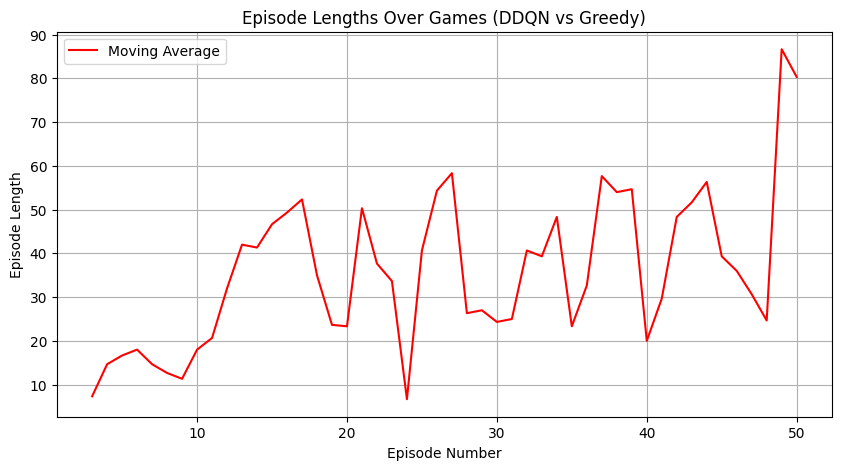

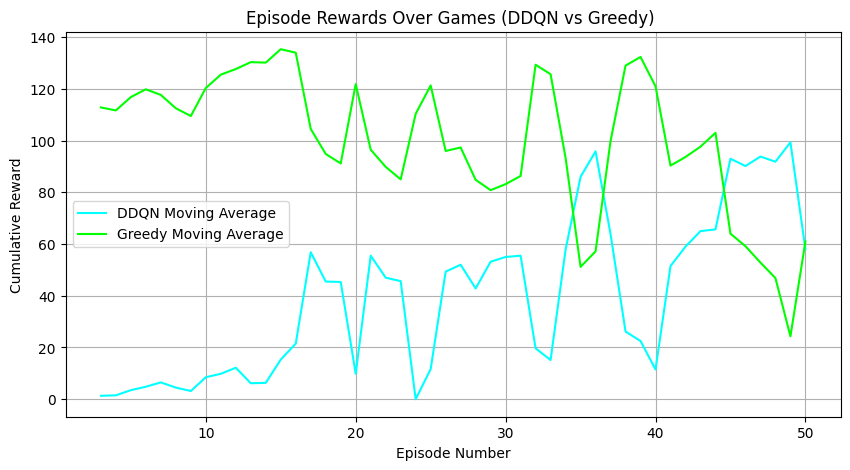

Games: 1275it [18:52,  1.13it/s]


In [ ]:
class DDQN(DQNAgent):
  ## redefine the train_on_minibatch function, use DQNAgent skeleton
  def train_on_minibatch(self, minibatch):
          obs, rewards, dones, info = zip(*minibatch)
          obs = torch.tensor([o.flatten() for o in obs])

          q_values_online = self.model(obs)
          next_actions_online = torch.argmax(self.model(obs), dim=1)

          next_obs = torch.tensor([t[0].flatten() for t in minibatch])
          target_q_values_next = self.target_model(next_obs)
          target_q_values_next = target_q_values_next[range(len(next_actions_online)), next_actions_online]

          rewards = torch.tensor(rewards, dtype=torch.float32)

          target_q_values = rewards + self.gamma * target_q_values_next * (1 - torch.tensor(dones, dtype=torch.float32))
          self.optimizer.zero_grad()
          loss = self.loss_function(q_values_online, target_q_values.unsqueeze(1))
          loss.backward()
          self.optimizer.step()

input_shape = env.observation_space.shape
nb_actions = env.action_space.n
nb_steps = 50
nb_steps_warmup = nb_steps / 10
model = DQNModel(input_shape, nb_actions)
memory = ReplayMemory(env=env)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_function = nn.MSELoss()
ddqn = DDQN(model=model, memory=memory, epsilon_decay_steps=nb_steps, nb_steps_warmup=nb_steps_warmup,
            target_model_update=1e-2)
ddqn.compile(optimizer=optimizer, loss_function=loss_function)
ddqn.fit(env, enemy_agent=GreedyAgent(), batch_size=1, nb_steps=nb_steps, visualize=False, verbose=2)

Now for DDQN, the implementation mirrors the DQN Agent, but now the solution utilizes two Q-value estimators, which work to update each other. These estimators allow for an unbiased Q-value updates of each action, minimizing maximization bias.

We again simulate 50 games of the DDQN agent playing against the greedy agent. From the plots for episode length and episode rewards, we observe that the DDQN agent is a stronger opponent for the Greedy agent than the DQN agent as average episode lengths are shorter and the DDQN agent win rate is 22%.

### Test Case 5: AlphaZero

We attempted to integrate the alpha-zero-general library (from lab) with gym-xiangqi but it entails substantial modification across multiple functions. These modifications are necessary due to differences in the API between gym-xiangqi and the original library's implementation.

However, given the extent of integration work required, it appears that the task may exceed our current timeframe. Since this integration is not the primary focus of our project, we decided to leave this for future work.

###Test Case 6: Fine-tuning LLM Agent with Online RL (PPO & LoRA)

Game: Chinese Chess

In [ ]:
!pip install peft
!pip install trl
!pip install llamagym
!pip install transformers==4.38.2
!pip install huggingface_hub.utils

In [ ]:
from huggingface_hub import login


In [ ]:
import os
import re
from abc import ABC, abstractmethod
from typing import List, Dict

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import gym
import numpy as np
import wandb
from gym.wrappers import RecordVideo
from tqdm import trange
import torch

from peft import LoraConfig
from transformers import AutoTokenizer
from trl import (
    AutoModelForCausalLMWithValueHead,
    PPOTrainer,
    PPOConfig,
    create_reference_model,
)

In [ ]:
# Some log functions that will help save intermediate results
def training_log_token_truncate(file, num_episode, round, input_token_length=2048):
  with open(file, 'a', encoding='utf-8') as f:
    f.write(f">>Episode {num_episode} round {round}, the input token length got to {input_token_length}\n")

def training_log_round_info(file, num_episode, round, turn, piece, move, reward):
  with open(file, 'a', encoding='utf-8') as f:
    f.write(f"Episode {num_episode} round: {round}\n{turn} made the move {piece} from {move[1]} to {move[2]}.\nReward: {reward}\n====================\n")

def training_log_episode_info(file, num_episode, round, ally_wins, enemy_wins, truncated_game):
  with open(file, 'a', encoding='utf-8') as f:
    f.write(f"Episode {num_episode} ended with {round} rounds. Ally Wins: {ally_wins}, Enemy Wins: {enemy_wins}, Truncated Game: {truncated_game}\n")

def training_log_llm_output(file, num_episode, round, llm_output):
  with open(file, 'a', encoding='utf-8') as f:
    f.write(f"Episode {num_episode} round {round}: response: {llm_output}\n")

This Agent class is adopted from [LlamaGym](https://github.com/KhoomeiK/LlamaGym), which is a API for fine tuning LLM agents with online reinforcement learning. However, to make this class compatible with Chinese Chess, we made several necessary changes:
*   We implemented a new dictionary called 'current_llm_input'
  *   The original implementation involves a dictionary named 'current_episode_messages.' This dictionary stores all prompts, observations, and responses from the LLM for each episode. It is cleared at the end of every episode. This dictionary serves two main purposes: first, the contents of the dictionary are compiled into a dialogue that acts as the prompt for the LLM when it is the agent's turn to act; second, at the conclusion of each episode, the information in the 'current_episode_messages' dictionary is used as training data to update the LLM's weights.
  *   The 'current_episode_messages' dictionary effectively utilizes all training data, but it also presents a challenge when generating prompts for the LLM. Specifically, compiling all the information from one episode into a single LLM prompt can easily cause the prompt to exceed the maximum token limit.
  *   To address the issue of prompts exceeding the token limit, we introduced a new dictionary called 'current_llm_input,' which is specifically used for creating prompts. If the prompt's length surpasses the token limit, the algorithm clears the records of previous turns in that episode and starts fresh. Meanwhile, 'current_episode_messages' continues to compile all the information from each episode, whhich ensures that all training data is still used efficiently.
*   We discovered that when the LLM generates an output, it first repeats the prompt and then adds its response. This process causes subsequent prompts to become longer, increasing the risk of exceeding token limits because each response is included in the prompts for the rest of the episode. To address this issue, we implemented a mechanism that truncates the repeated portion of the prompt.


In terms of **reinforcement learning algorithm**, the Agent class adopted the **PPOTrainer from the Transformer Reinforcement Learning (trl)** library. The TRL library provides a number of tools to train transformers with reinforcement learning, including but not limited to PPOTrainer. The PPOTrainer implements the Proximal Policy Optimization (PPO) algorithm, which is a policy gradient method. It is known to be sample-efficient and stable during training due to its implementation of the clipping mechanism.

In [ ]:
class Agent(ABC):
    def __init__(
        self, model, tokenizer, max_input_token, device, generate_config_dict=None, ppo_config_dict=None
    ):
        if generate_config_dict is None:
            generate_config_dict = {
                "max_new_tokens": 32,
                "do_sample": True,
                "top_p": 0.6,
                "top_k": 0,
                "temperature": 0.9,
            }
        if ppo_config_dict is None:
            ppo_config_dict = {"batch_size": 16, "mini_batch_size": 16}

        self.model = model
        self.tokenizer = tokenizer
        self.max_input_token = max_input_token
        self.device = device
        self.generate_config_dict = generate_config_dict
        self.model_ref = create_reference_model(model)
        self.ppo_config = PPOConfig(**ppo_config_dict)
        self.ppo_trainer = PPOTrainer(self.ppo_config, model, self.model_ref, tokenizer)

        self.current_batch = {"queries": [], "responses": [], "rewards": []}

        self.current_episode_messages = [
            {
                "role": "system",
                "content": self.get_system_prompt(),
            }
        ]
        self.current_llm_input = [
            {
                "role": "system",
                "content": self.get_system_prompt(),
            }
        ]
        self.current_episode_rewards = []

    @abstractmethod
    def get_system_prompt(self) -> str:
        pass

    @abstractmethod
    def format_observation(self, observation: gym.core.ObsType) -> str:
        pass

    @abstractmethod
    def extract_action(self, response: str) -> gym.core.ActType:
        pass

    def llm(self, messages: List[Dict[str, str]]) -> str:
        prompt = self.tokenizer.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=True
        )
        inputs = self.tokenizer(prompt, return_tensors="pt").to(self.device)
        context_len = inputs['attention_mask'].size(1)
        generate_ids = self.model.generate(
            inputs=inputs.input_ids,
            **{
                key.split("/")[-1]: value
                for key, value in self.generate_config_dict.items()
            }
        )
        generate_ids = generate_ids[:, context_len:]
        outputs = self.tokenizer.batch_decode(
            generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False
        )
        response = outputs[0]

        return response

    def act(self, observation, episode, round, env):
        message = self.format_observation(observation)
        self.current_episode_messages += [{"role": "user", "content": message}]
        self.current_llm_input+=[{"role": "user", "content": message}]

        # Check if the prompt exceeds the maximum token length
        prompt = self.tokenizer.apply_chat_template(
            self.current_llm_input, tokenize=False, add_generation_prompt=True
        )
        inputs = self.tokenizer(prompt, return_tensors="pt").to(self.device)
        input_token_length=len(inputs.input_ids[0])

        # Log the prompt for this round
        print(f"Round {round} LLM Prompt: {prompt}") #toggle this for print out of system prompt

        # Truncate if the length is longer than 2048-200 (give some buffer)
        if (input_token_length+200)>=self.max_input_token:
          # if it exceeds, reset self.current_llm_input
          training_log_token_truncate('chinese_chess_token_truncate_log', num_episode=episode, round=round, input_token_length=input_token_length)
          self.current_llm_input=[
            {
                "role": "system",
                "content": self.get_system_prompt(),
            }
          ]
          self.current_llm_input += [{"role": "user", "content": message}]


        response = self.llm(self.current_llm_input)

        # Log the response for this round
        print(f"Round {round} LLM Response: {response}") #toggle this for print out of llm response

        try:
            random, action = self.extract_action(response, env)
        except Exception as e:
            return None, None, response

        self.current_episode_messages += [{"role": "assistant", "content": response}]
        self.current_llm_input += [{"role": "assistant", "content": response}]
        return random, action, response

    def assign_reward(self, reward):
        self.current_episode_rewards.append(reward)

    def format_episode_for_ppo(self, messages, rewards):
        queries, responses = [], []
        for i in range(2, len(messages), 2):
            prompt = self.tokenizer.apply_chat_template(
                messages[: i + 1], tokenize=False, add_generation_prompt=False
            )
            conversation_chunks = prompt.split("</s>")[:-1]
            query = "</s>".join(conversation_chunks[:-1]) + "</s>"
            response = conversation_chunks[-1]

            # if len(query)>4500:
            #   query=query[:4500]

            query = self.tokenizer(query, return_tensors="pt").input_ids[0]
            response = self.tokenizer(response, return_tensors="pt").input_ids[0]

            # if torch.all(query >= 0) and torch.all(query < 50265):
            #   print(" ")
            # else:
            #   print("Invalid indices detected in query.")

            # if torch.all(response >= 0) and torch.all(response < 50265):
            #   print(" ")
            # else:
            #   print("Invalid indices detected in response.")
            query = torch.clamp(query, 0, 50265 - 1)
            response = torch.clamp(response, 0, 50265 - 1)

            queries.append(query)
            responses.append(response)

        if all(reward == 0 for reward in rewards[:-1]):
            # if sparse rewards, give equal reward to all conversation turns
            per_turn_reward = rewards[-1] / (len(messages) / 2)
            rewards = [torch.tensor(per_turn_reward, dtype=torch.float16)] * len(
                queries
            )
        else:
            rewards = [torch.tensor(reward, dtype=torch.float16) for reward in rewards]

        return queries, responses, rewards

    def terminate_episode(self, train=True):
        if train:
            queries, responses, rewards = self.format_episode_for_ppo(
                self.current_episode_messages, self.current_episode_rewards
            )

        self.current_episode_messages = [
            {
                "role": "system",
                "content": self.get_system_prompt(),
            }
        ]
        self.current_llm_input = [
            {
                "role": "system",
                "content": self.get_system_prompt(),
            }
        ]
        self.current_episode_rewards = []

        if train:
            self.current_batch["queries"].extend(queries)
            self.current_batch["responses"].extend(responses)
            self.current_batch["rewards"].extend(rewards)

            if len(self.current_batch["queries"]) >= self.ppo_config.batch_size:
                train_stats = self.train_batch(
                    self.current_batch["queries"],
                    self.current_batch["responses"],
                    self.current_batch["rewards"],
                )
                return train_stats

        return {}

    def train_batch(self, batch_queries, batch_responses, batch_rewards):
        if len(batch_queries) > self.ppo_config.batch_size:
            queries = batch_queries[: self.ppo_config.batch_size]
            responses = batch_responses[: self.ppo_config.batch_size]
            rewards = batch_rewards[: self.ppo_config.batch_size]

            # keep the remainder for the next batch
            self.current_batch["queries"] = batch_queries[self.ppo_config.batch_size :]
            self.current_batch["responses"] = batch_responses[
                self.ppo_config.batch_size :
            ]
            self.current_batch["rewards"] = batch_rewards[self.ppo_config.batch_size :]
        else:
            queries, responses, rewards = batch_queries, batch_responses, batch_rewards
            self.current_batch = {"queries": [], "responses": [], "rewards": []}

        train_stats = self.ppo_trainer.step(queries, responses, rewards)
        # print(train_stats)
        # print(f'LOG_STATS:{self.ppo_trainer.log_stats(train_stats, self.current_batch, rewards)}')

        torch.cuda.empty_cache()

        return train_stats

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The following cell shows the Agent class adopted specifically for Chinese Chess. This design aims to provide the language model with essential information about Chinese Chess, including the basic rule, the layout of observations and the required format for responses. If the model does not respond in the expected format, a random move will be chosen.

In [ ]:
class ChineseChessAgent(Agent):
    def get_system_prompt(self) -> str:
        return """You are an expert Chinese chess player. Your goal is to take your opponent's general piece. Every turn, you'll see the current layout on the board demonstrated by a 10 by 9 numpy array. Each coordinate in the numpy array corresponds to a single coordinate on the board with the value range from -16 to 16, which represents the pieces. Negative integers are enemy pieces, positive integers are your pieces, and 0 means it's empty. Decide what you want your move to be by writing "Action: [Piece_id, (Start_x Start_y), (End_x, End_y)]". Piece_id should be an integer from 1 to 16 which indicates the piece that you want to move. Start should be a tuple with two integers, where the first integer should be from 0 to 9 and the second integer should be from 0 to 8. Start tuple represents where Piece_id is at. End should be a tuple with two integers, where the first integer should be from 0 to 9 and the second integer should be from 0 to 8. End tuple represents where you want to move Piece_id to."""

    def format_observation(self, observation: gym.core.ObsType) -> str:
        message = f"The current board looks like this: {observation}."
        return message

    def extract_action(self, response: str, env: gym.Env) -> gym.core.ActType:
        # match = re.compile(r"Action:\s*\[\s*(\d+)\s*,\s*\((\d+)\s*,\s*(\d+)\s*\)\s*,\s*\((\d+)\s*,\s*(\d+)\s*\)\s*\]").search(response)
        match = re.compile(r".*Action:\s*(\d+)\s*,\s*\((\d+)\s*,\s*(\d+)\s*\)\s*,\s*\((\d+)\s*,\s*(\d+)\s*\)").search(response)
        if match:
            piece_id = int(match.group(1))
            from_row, from_col, to_row, to_col = int(match.group(2)), int(match.group(3)), int(match.group(4)), int(match.group(5))
            if from_row not in range(0,10):
                from_row = 0
            if to_row not in range(0,10):
                to_row = 0
            if from_col not in range(0,9):
                from_col = 0
            if to_col not in range(0,9):
                to_col = 0

            action = move_to_action_space(piece_id, (from_row, from_col), (to_row, to_col))
            if action in np.where(env.ally_actions == 1)[0]:
              return False, action

        legal_moves = np.where(env.ally_actions == 1)[0]
        return True, np.random.choice(legal_moves)

The LLM we chose to finetune is the **Open Pre-trained Transformer Language Models (OPT)** with 125 million parameters. OPT is a decoder-only pretrained transoformers with size ranging from 125M to 175B. They are trained to roughly match the performance and sizes of the GPT-3 class. Due to limited compute, we chose to work with the OPT model with 125M parameters.

To optimize model fine-tuning with our limited computing resources, we implemented **Low-Rank Adaptation (LoRA)**, a lightweight training technique. LoRA focuses on fine-tuning two lower-rank matrices rather than the entire weight matrix. These matrices approximate the original weight matrix and are incorporated into the LoRA adapter. This adapter is then integrated into the pretrained model for use during inference.

Let's take a closer look at the **parameters choices** we made for LoRA:

*   'lora/r' represents the rank of the low-rank matrices. A higher rank results in more parameters being updated, which can improve the model's fit to new data but also increases computational intensity. Conversely, a lower rank updates fewer parameters, preserving more of the pretrained model's structure. This leads to faster training times and reduced memory usage. Therefore, selecting the rank involves balancing the need for model adaptation against training efficiency. Due to limited compute, we chose 16 for 'lora/r', which trains ~0.5% of the total parameters.
*   'lora/lora_alpha' is a scaling factor that determines the influence of the low-rank matrices during the fine-tuning process. The weight matrix is scaled by $\frac{lora\_alpha}{lora\_rank}$. A higher alpha value means the low-rank matrices will have a greater impact on the model's behavior. However, setting the alpha value too high can result in overfitting. In our case, we set this parameter to be 32, which is double 'lora/r.'
*   'lora/lora_dropout' represents the dropout rate for LoRA, and it helps to prevent overfitting. Since our model is relatively small, we don't think it will overfit. Thus, we chose a relativly low dropout rate, which is 0.05.
*   'lora/bias' specifies if the bias parameters are being trained. It involves considering how much additional adaptability we need in our model in addition to what is provided by the low-rank matrices. Due to limited compute, we want to focus more on updating the weights, thus we set this parameter to be "none."
*   'lora/task_type' indicates the task type that the model is being fine-tuned for. Since we are working with causal language modeling, we chose "CAUSAL_LM."



In [ ]:
# Settings and config for the LLM before we start the training
max_input_token=2048

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hyperparams = {
        "model_name": "facebook/opt-125m", #"facebook/opt-125m", "meta-llama/Llama-2-7b-chat-hf"
        "env": "gym_xiangqi:xiangqi-v0",
        "lora/r": 16, #changed to 16 from 32 because gpu spikes
        "lora/lora_alpha": 32,
        "lora/lora_dropout": 0.05,
        "lora/bias": "none",
        "lora/task_type": "CAUSAL_LM",
        "load_in_8bit": True,
        "batch_size": 1,
        "seed": 42069,
        "episodes": 25,
        "generate/max_new_tokens": 50,
        "generate/do_sample": True,
        "generate/top_p": 0.6,
        "generate/top_k": 0,
        "generate/temperature": 0.9,
    }

wandb_run = wandb.init(project=os.environ.get("WANDB_PROJECT"), config=hyperparams)
device = "cuda:0"
# device='cpu'
HF_TOKEN = os.environ.get("HF_TOKEN")

lora_config = LoraConfig(
    **{key.split("/")[-1]: value for key, value in hyperparams.items() if key.startswith("lora/")}
)

model = AutoModelForCausalLMWithValueHead.from_pretrained(
    pretrained_model_name_or_path=hyperparams["model_name"],
    peft_config=lora_config,
    load_in_8bit=hyperparams["load_in_8bit"]
).to(device)

tokenizer = AutoTokenizer.from_pretrained(hyperparams["model_name"])
tokenizer.add_special_tokens({"pad_token": "<pad>"})
model.pretrained_model.resize_token_embeddings(len(tokenizer))

# Save initial parameters for comparison later
initial_params = {name: param.clone().detach() for name, param in model.named_parameters()}

def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"\ntrainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

print(f'PPO model parameters to be updated:\n{print_number_of_trainable_model_parameters(model)}\n')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (10, 9)
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/lo

Round 1 LLM Prompt: You are an expert Chinese chess player. Your goal is to take your opponent's general piece. Every turn, you'll see the current layout on the board demonstrated by a 10 by 9 numpy array. Each coordinate in the numpy array corresponds to a single coordinate on the board with the value range from -16 to 16, which represents the pieces. Negative integers are enemy pieces, positive integers are your pieces, and 0 means it's empty. Decide what you want your move to be by writing "Action: [Piece_id, (Start_x Start_y), (End_x, End_y)]". Piece_id should be an integer from 1 to 16 which indicates the piece that you want to move. Start should be a tuple with two integers, where the first integer should be from 0 to 9 and the second integer should be from 0 to 8. Start tuple represents where Piece_id is at. End should be a tuple with two integers, where the first integer should be from 0 to 9 and the second integer should be from 0 to 8. End tuple represents where you want to m

/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Round 1 LLM Response: Maine residents were horrified when they learned that they were going to be able to vote for the first time in the state's history on Tuesday, June 8, when the state's election results were announced.

The Maine House of Representatives approved a
Episode: 1 Round: 1
Ally made the move GENERAL from [9, 4] to [8, 4]. Reward: 0.0. Random True
Episode: 1 Round: 2
Enemy made the move CANNON_1 from [2, 7] to [9, 7]. Reward: 4.0 
Round 3 LLM Prompt: You are an expert Chinese chess player. Your goal is to take your opponent's general piece. Every turn, you'll see the current layout on the board demonstrated by a 10 by 9 numpy array. Each coordinate in the numpy array corresponds to a single coordinate on the board with the value range from -16 to 16, which represents the pieces. Negative integers are enemy pieces, positive integers are your pieces, and 0 means it's empty. Decide what you want your move to be by writing "Action: [Piece_id, (Start_x Start_y), (End_x, End_y

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):


Round 3 LLM Response: I think I'd have to say no. I have a lot of friends who have lost their jobs because of their bad work.   But I don't want to get worked up about it. I just want to get my shit together.

Episode: 1 Round: 3
Ally made the move GENERAL from [8, 4] to [9, 4]. Reward: 0.0. Random True
Episode: 1 Round: 4
Enemy made the move CANNON_2 from [2, 1] to [9, 1]. Reward: 4.0 
Round 5 LLM Prompt: You are an expert Chinese chess player. Your goal is to take your opponent's general piece. Every turn, you'll see the current layout on the board demonstrated by a 10 by 9 numpy array. Each coordinate in the numpy array corresponds to a single coordinate on the board with the value range from -16 to 16, which represents the pieces. Negative integers are enemy pieces, positive integers are your pieces, and 0 means it's empty. Decide what you want your move to be by writing "Action: [Piece_id, (Start_x Start_y), (End_x, End_y)]". Piece_id should be an integer from 1 to 16 which indica

/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_trainer.py:1275: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  std_scores = data["scores"].std()
/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_trainer.py:1302: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  stats["tokens/queries_len_std"] = torch.std(query_lens).cpu().numpy().item()
/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_trainer.py:1305: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  stats["tok

Round 1 LLM Prompt: You are an expert Chinese chess player. Your goal is to take your opponent's general piece. Every turn, you'll see the current layout on the board demonstrated by a 10 by 9 numpy array. Each coordinate in the numpy array corresponds to a single coordinate on the board with the value range from -16 to 16, which represents the pieces. Negative integers are enemy pieces, positive integers are your pieces, and 0 means it's empty. Decide what you want your move to be by writing "Action: [Piece_id, (Start_x Start_y), (End_x, End_y)]". Piece_id should be an integer from 1 to 16 which indicates the piece that you want to move. Start should be a tuple with two integers, where the first integer should be from 0 to 9 and the second integer should be from 0 to 8. Start tuple represents where Piece_id is at. End should be a tuple with two integers, where the first integer should be from 0 to 9 and the second integer should be from 0 to 8. End tuple represents where you want to m

  8%|▊         | 2/25 [00:56<11:35, 30.24s/it]

Round 1 LLM Prompt: You are an expert Chinese chess player. Your goal is to take your opponent's general piece. Every turn, you'll see the current layout on the board demonstrated by a 10 by 9 numpy array. Each coordinate in the numpy array corresponds to a single coordinate on the board with the value range from -16 to 16, which represents the pieces. Negative integers are enemy pieces, positive integers are your pieces, and 0 means it's empty. Decide what you want your move to be by writing "Action: [Piece_id, (Start_x Start_y), (End_x, End_y)]". Piece_id should be an integer from 1 to 16 which indicates the piece that you want to move. Start should be a tuple with two integers, where the first integer should be from 0 to 9 and the second integer should be from 0 to 8. Start tuple represents where Piece_id is at. End should be a tuple with two integers, where the first integer should be from 0 to 9 and the second integer should be from 0 to 8. End tuple represents where you want to m

 12%|█▏        | 3/25 [01:29<11:39, 31.79s/it]

Round 1 LLM Prompt: You are an expert Chinese chess player. Your goal is to take your opponent's general piece. Every turn, you'll see the current layout on the board demonstrated by a 10 by 9 numpy array. Each coordinate in the numpy array corresponds to a single coordinate on the board with the value range from -16 to 16, which represents the pieces. Negative integers are enemy pieces, positive integers are your pieces, and 0 means it's empty. Decide what you want your move to be by writing "Action: [Piece_id, (Start_x Start_y), (End_x, End_y)]". Piece_id should be an integer from 1 to 16 which indicates the piece that you want to move. Start should be a tuple with two integers, where the first integer should be from 0 to 9 and the second integer should be from 0 to 8. Start tuple represents where Piece_id is at. End should be a tuple with two integers, where the first integer should be from 0 to 9 and the second integer should be from 0 to 8. End tuple represents where you want to m

 16%|█▌        | 4/25 [01:49<09:26, 26.98s/it]

Round 1 LLM Prompt: You are an expert Chinese chess player. Your goal is to take your opponent's general piece. Every turn, you'll see the current layout on the board demonstrated by a 10 by 9 numpy array. Each coordinate in the numpy array corresponds to a single coordinate on the board with the value range from -16 to 16, which represents the pieces. Negative integers are enemy pieces, positive integers are your pieces, and 0 means it's empty. Decide what you want your move to be by writing "Action: [Piece_id, (Start_x Start_y), (End_x, End_y)]". Piece_id should be an integer from 1 to 16 which indicates the piece that you want to move. Start should be a tuple with two integers, where the first integer should be from 0 to 9 and the second integer should be from 0 to 8. Start tuple represents where Piece_id is at. End should be a tuple with two integers, where the first integer should be from 0 to 9 and the second integer should be from 0 to 8. End tuple represents where you want to m

 20%|██        | 5/25 [02:13<08:36, 25.82s/it]

Round 1 LLM Prompt: You are an expert Chinese chess player. Your goal is to take your opponent's general piece. Every turn, you'll see the current layout on the board demonstrated by a 10 by 9 numpy array. Each coordinate in the numpy array corresponds to a single coordinate on the board with the value range from -16 to 16, which represents the pieces. Negative integers are enemy pieces, positive integers are your pieces, and 0 means it's empty. Decide what you want your move to be by writing "Action: [Piece_id, (Start_x Start_y), (End_x, End_y)]". Piece_id should be an integer from 1 to 16 which indicates the piece that you want to move. Start should be a tuple with two integers, where the first integer should be from 0 to 9 and the second integer should be from 0 to 8. Start tuple represents where Piece_id is at. End should be a tuple with two integers, where the first integer should be from 0 to 9 and the second integer should be from 0 to 8. End tuple represents where you want to m

 24%|██▍       | 6/25 [02:53<09:45, 30.82s/it]

Round 1 LLM Prompt: You are an expert Chinese chess player. Your goal is to take your opponent's general piece. Every turn, you'll see the current layout on the board demonstrated by a 10 by 9 numpy array. Each coordinate in the numpy array corresponds to a single coordinate on the board with the value range from -16 to 16, which represents the pieces. Negative integers are enemy pieces, positive integers are your pieces, and 0 means it's empty. Decide what you want your move to be by writing "Action: [Piece_id, (Start_x Start_y), (End_x, End_y)]". Piece_id should be an integer from 1 to 16 which indicates the piece that you want to move. Start should be a tuple with two integers, where the first integer should be from 0 to 9 and the second integer should be from 0 to 8. Start tuple represents where Piece_id is at. End should be a tuple with two integers, where the first integer should be from 0 to 9 and the second integer should be from 0 to 8. End tuple represents where you want to m

 28%|██▊       | 7/25 [08:32<39:25, 131.43s/it]

Round 1 LLM Prompt: You are an expert Chinese chess player. Your goal is to take your opponent's general piece. Every turn, you'll see the current layout on the board demonstrated by a 10 by 9 numpy array. Each coordinate in the numpy array corresponds to a single coordinate on the board with the value range from -16 to 16, which represents the pieces. Negative integers are enemy pieces, positive integers are your pieces, and 0 means it's empty. Decide what you want your move to be by writing "Action: [Piece_id, (Start_x Start_y), (End_x, End_y)]". Piece_id should be an integer from 1 to 16 which indicates the piece that you want to move. Start should be a tuple with two integers, where the first integer should be from 0 to 9 and the second integer should be from 0 to 8. Start tuple represents where Piece_id is at. End should be a tuple with two integers, where the first integer should be from 0 to 9 and the second integer should be from 0 to 8. End tuple represents where you want to m

 32%|███▏      | 8/25 [08:49<26:53, 94.91s/it] 

Round 1 LLM Prompt: You are an expert Chinese chess player. Your goal is to take your opponent's general piece. Every turn, you'll see the current layout on the board demonstrated by a 10 by 9 numpy array. Each coordinate in the numpy array corresponds to a single coordinate on the board with the value range from -16 to 16, which represents the pieces. Negative integers are enemy pieces, positive integers are your pieces, and 0 means it's empty. Decide what you want your move to be by writing "Action: [Piece_id, (Start_x Start_y), (End_x, End_y)]". Piece_id should be an integer from 1 to 16 which indicates the piece that you want to move. Start should be a tuple with two integers, where the first integer should be from 0 to 9 and the second integer should be from 0 to 8. Start tuple represents where Piece_id is at. End should be a tuple with two integers, where the first integer should be from 0 to 9 and the second integer should be from 0 to 8. End tuple represents where you want to m

 36%|███▌      | 9/25 [09:42<21:50, 81.89s/it]

Round 1 LLM Prompt: You are an expert Chinese chess player. Your goal is to take your opponent's general piece. Every turn, you'll see the current layout on the board demonstrated by a 10 by 9 numpy array. Each coordinate in the numpy array corresponds to a single coordinate on the board with the value range from -16 to 16, which represents the pieces. Negative integers are enemy pieces, positive integers are your pieces, and 0 means it's empty. Decide what you want your move to be by writing "Action: [Piece_id, (Start_x Start_y), (End_x, End_y)]". Piece_id should be an integer from 1 to 16 which indicates the piece that you want to move. Start should be a tuple with two integers, where the first integer should be from 0 to 9 and the second integer should be from 0 to 8. Start tuple represents where Piece_id is at. End should be a tuple with two integers, where the first integer should be from 0 to 9 and the second integer should be from 0 to 8. End tuple represents where you want to m

 40%|████      | 10/25 [10:02<15:41, 62.76s/it]

Episode 10 ended. Ally Wins: 0, Enemy Wins: 10, Truncated Game: 0 
Round 1 LLM Prompt: You are an expert Chinese chess player. Your goal is to take your opponent's general piece. Every turn, you'll see the current layout on the board demonstrated by a 10 by 9 numpy array. Each coordinate in the numpy array corresponds to a single coordinate on the board with the value range from -16 to 16, which represents the pieces. Negative integers are enemy pieces, positive integers are your pieces, and 0 means it's empty. Decide what you want your move to be by writing "Action: [Piece_id, (Start_x Start_y), (End_x, End_y)]". Piece_id should be an integer from 1 to 16 which indicates the piece that you want to move. Start should be a tuple with two integers, where the first integer should be from 0 to 9 and the second integer should be from 0 to 8. Start tuple represents where Piece_id is at. End should be a tuple with two integers, where the first integer should be from 0 to 9 and the second inte

 44%|████▍     | 11/25 [10:44<13:12, 56.64s/it]

Round 1 LLM Prompt: You are an expert Chinese chess player. Your goal is to take your opponent's general piece. Every turn, you'll see the current layout on the board demonstrated by a 10 by 9 numpy array. Each coordinate in the numpy array corresponds to a single coordinate on the board with the value range from -16 to 16, which represents the pieces. Negative integers are enemy pieces, positive integers are your pieces, and 0 means it's empty. Decide what you want your move to be by writing "Action: [Piece_id, (Start_x Start_y), (End_x, End_y)]". Piece_id should be an integer from 1 to 16 which indicates the piece that you want to move. Start should be a tuple with two integers, where the first integer should be from 0 to 9 and the second integer should be from 0 to 8. Start tuple represents where Piece_id is at. End should be a tuple with two integers, where the first integer should be from 0 to 9 and the second integer should be from 0 to 8. End tuple represents where you want to m

 48%|████▊     | 12/25 [13:40<20:05, 92.73s/it]

Round 1 LLM Prompt: You are an expert Chinese chess player. Your goal is to take your opponent's general piece. Every turn, you'll see the current layout on the board demonstrated by a 10 by 9 numpy array. Each coordinate in the numpy array corresponds to a single coordinate on the board with the value range from -16 to 16, which represents the pieces. Negative integers are enemy pieces, positive integers are your pieces, and 0 means it's empty. Decide what you want your move to be by writing "Action: [Piece_id, (Start_x Start_y), (End_x, End_y)]". Piece_id should be an integer from 1 to 16 which indicates the piece that you want to move. Start should be a tuple with two integers, where the first integer should be from 0 to 9 and the second integer should be from 0 to 8. Start tuple represents where Piece_id is at. End should be a tuple with two integers, where the first integer should be from 0 to 9 and the second integer should be from 0 to 8. End tuple represents where you want to m

 52%|█████▏    | 13/25 [14:09<14:42, 73.51s/it]

Round 1 LLM Prompt: You are an expert Chinese chess player. Your goal is to take your opponent's general piece. Every turn, you'll see the current layout on the board demonstrated by a 10 by 9 numpy array. Each coordinate in the numpy array corresponds to a single coordinate on the board with the value range from -16 to 16, which represents the pieces. Negative integers are enemy pieces, positive integers are your pieces, and 0 means it's empty. Decide what you want your move to be by writing "Action: [Piece_id, (Start_x Start_y), (End_x, End_y)]". Piece_id should be an integer from 1 to 16 which indicates the piece that you want to move. Start should be a tuple with two integers, where the first integer should be from 0 to 9 and the second integer should be from 0 to 8. Start tuple represents where Piece_id is at. End should be a tuple with two integers, where the first integer should be from 0 to 9 and the second integer should be from 0 to 8. End tuple represents where you want to m

 56%|█████▌    | 14/25 [14:23<10:11, 55.56s/it]

Round 1 LLM Prompt: You are an expert Chinese chess player. Your goal is to take your opponent's general piece. Every turn, you'll see the current layout on the board demonstrated by a 10 by 9 numpy array. Each coordinate in the numpy array corresponds to a single coordinate on the board with the value range from -16 to 16, which represents the pieces. Negative integers are enemy pieces, positive integers are your pieces, and 0 means it's empty. Decide what you want your move to be by writing "Action: [Piece_id, (Start_x Start_y), (End_x, End_y)]". Piece_id should be an integer from 1 to 16 which indicates the piece that you want to move. Start should be a tuple with two integers, where the first integer should be from 0 to 9 and the second integer should be from 0 to 8. Start tuple represents where Piece_id is at. End should be a tuple with two integers, where the first integer should be from 0 to 9 and the second integer should be from 0 to 8. End tuple represents where you want to m

 60%|██████    | 15/25 [14:47<07:40, 46.06s/it]

Round 1 LLM Prompt: You are an expert Chinese chess player. Your goal is to take your opponent's general piece. Every turn, you'll see the current layout on the board demonstrated by a 10 by 9 numpy array. Each coordinate in the numpy array corresponds to a single coordinate on the board with the value range from -16 to 16, which represents the pieces. Negative integers are enemy pieces, positive integers are your pieces, and 0 means it's empty. Decide what you want your move to be by writing "Action: [Piece_id, (Start_x Start_y), (End_x, End_y)]". Piece_id should be an integer from 1 to 16 which indicates the piece that you want to move. Start should be a tuple with two integers, where the first integer should be from 0 to 9 and the second integer should be from 0 to 8. Start tuple represents where Piece_id is at. End should be a tuple with two integers, where the first integer should be from 0 to 9 and the second integer should be from 0 to 8. End tuple represents where you want to m

 64%|██████▍   | 16/25 [15:07<05:42, 38.03s/it]

Round 1 LLM Prompt: You are an expert Chinese chess player. Your goal is to take your opponent's general piece. Every turn, you'll see the current layout on the board demonstrated by a 10 by 9 numpy array. Each coordinate in the numpy array corresponds to a single coordinate on the board with the value range from -16 to 16, which represents the pieces. Negative integers are enemy pieces, positive integers are your pieces, and 0 means it's empty. Decide what you want your move to be by writing "Action: [Piece_id, (Start_x Start_y), (End_x, End_y)]". Piece_id should be an integer from 1 to 16 which indicates the piece that you want to move. Start should be a tuple with two integers, where the first integer should be from 0 to 9 and the second integer should be from 0 to 8. Start tuple represents where Piece_id is at. End should be a tuple with two integers, where the first integer should be from 0 to 9 and the second integer should be from 0 to 8. End tuple represents where you want to m

 68%|██████▊   | 17/25 [17:29<09:14, 69.32s/it]

Round 1 LLM Prompt: You are an expert Chinese chess player. Your goal is to take your opponent's general piece. Every turn, you'll see the current layout on the board demonstrated by a 10 by 9 numpy array. Each coordinate in the numpy array corresponds to a single coordinate on the board with the value range from -16 to 16, which represents the pieces. Negative integers are enemy pieces, positive integers are your pieces, and 0 means it's empty. Decide what you want your move to be by writing "Action: [Piece_id, (Start_x Start_y), (End_x, End_y)]". Piece_id should be an integer from 1 to 16 which indicates the piece that you want to move. Start should be a tuple with two integers, where the first integer should be from 0 to 9 and the second integer should be from 0 to 8. Start tuple represents where Piece_id is at. End should be a tuple with two integers, where the first integer should be from 0 to 9 and the second integer should be from 0 to 8. End tuple represents where you want to m

 72%|███████▏  | 18/25 [18:00<06:45, 57.88s/it]

Round 1 LLM Prompt: You are an expert Chinese chess player. Your goal is to take your opponent's general piece. Every turn, you'll see the current layout on the board demonstrated by a 10 by 9 numpy array. Each coordinate in the numpy array corresponds to a single coordinate on the board with the value range from -16 to 16, which represents the pieces. Negative integers are enemy pieces, positive integers are your pieces, and 0 means it's empty. Decide what you want your move to be by writing "Action: [Piece_id, (Start_x Start_y), (End_x, End_y)]". Piece_id should be an integer from 1 to 16 which indicates the piece that you want to move. Start should be a tuple with two integers, where the first integer should be from 0 to 9 and the second integer should be from 0 to 8. Start tuple represents where Piece_id is at. End should be a tuple with two integers, where the first integer should be from 0 to 9 and the second integer should be from 0 to 8. End tuple represents where you want to m

 76%|███████▌  | 19/25 [18:19<04:38, 46.37s/it]

Round 1 LLM Prompt: You are an expert Chinese chess player. Your goal is to take your opponent's general piece. Every turn, you'll see the current layout on the board demonstrated by a 10 by 9 numpy array. Each coordinate in the numpy array corresponds to a single coordinate on the board with the value range from -16 to 16, which represents the pieces. Negative integers are enemy pieces, positive integers are your pieces, and 0 means it's empty. Decide what you want your move to be by writing "Action: [Piece_id, (Start_x Start_y), (End_x, End_y)]". Piece_id should be an integer from 1 to 16 which indicates the piece that you want to move. Start should be a tuple with two integers, where the first integer should be from 0 to 9 and the second integer should be from 0 to 8. Start tuple represents where Piece_id is at. End should be a tuple with two integers, where the first integer should be from 0 to 9 and the second integer should be from 0 to 8. End tuple represents where you want to m

 80%|████████  | 20/25 [19:06<03:52, 46.45s/it]

Episode 20 ended. Ally Wins: 0, Enemy Wins: 20, Truncated Game: 0 
Round 1 LLM Prompt: You are an expert Chinese chess player. Your goal is to take your opponent's general piece. Every turn, you'll see the current layout on the board demonstrated by a 10 by 9 numpy array. Each coordinate in the numpy array corresponds to a single coordinate on the board with the value range from -16 to 16, which represents the pieces. Negative integers are enemy pieces, positive integers are your pieces, and 0 means it's empty. Decide what you want your move to be by writing "Action: [Piece_id, (Start_x Start_y), (End_x, End_y)]". Piece_id should be an integer from 1 to 16 which indicates the piece that you want to move. Start should be a tuple with two integers, where the first integer should be from 0 to 9 and the second integer should be from 0 to 8. Start tuple represents where Piece_id is at. End should be a tuple with two integers, where the first integer should be from 0 to 9 and the second inte

 84%|████████▍ | 21/25 [19:40<02:50, 42.64s/it]

Round 1 LLM Prompt: You are an expert Chinese chess player. Your goal is to take your opponent's general piece. Every turn, you'll see the current layout on the board demonstrated by a 10 by 9 numpy array. Each coordinate in the numpy array corresponds to a single coordinate on the board with the value range from -16 to 16, which represents the pieces. Negative integers are enemy pieces, positive integers are your pieces, and 0 means it's empty. Decide what you want your move to be by writing "Action: [Piece_id, (Start_x Start_y), (End_x, End_y)]". Piece_id should be an integer from 1 to 16 which indicates the piece that you want to move. Start should be a tuple with two integers, where the first integer should be from 0 to 9 and the second integer should be from 0 to 8. Start tuple represents where Piece_id is at. End should be a tuple with two integers, where the first integer should be from 0 to 9 and the second integer should be from 0 to 8. End tuple represents where you want to m

 88%|████████▊ | 22/25 [20:12<01:58, 39.36s/it]

Round 1 LLM Prompt: You are an expert Chinese chess player. Your goal is to take your opponent's general piece. Every turn, you'll see the current layout on the board demonstrated by a 10 by 9 numpy array. Each coordinate in the numpy array corresponds to a single coordinate on the board with the value range from -16 to 16, which represents the pieces. Negative integers are enemy pieces, positive integers are your pieces, and 0 means it's empty. Decide what you want your move to be by writing "Action: [Piece_id, (Start_x Start_y), (End_x, End_y)]". Piece_id should be an integer from 1 to 16 which indicates the piece that you want to move. Start should be a tuple with two integers, where the first integer should be from 0 to 9 and the second integer should be from 0 to 8. Start tuple represents where Piece_id is at. End should be a tuple with two integers, where the first integer should be from 0 to 9 and the second integer should be from 0 to 8. End tuple represents where you want to m

/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1.09 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 92%|█████████▏| 23/25 [20:54<01:20, 40.29s/it]

Round 1 LLM Prompt: You are an expert Chinese chess player. Your goal is to take your opponent's general piece. Every turn, you'll see the current layout on the board demonstrated by a 10 by 9 numpy array. Each coordinate in the numpy array corresponds to a single coordinate on the board with the value range from -16 to 16, which represents the pieces. Negative integers are enemy pieces, positive integers are your pieces, and 0 means it's empty. Decide what you want your move to be by writing "Action: [Piece_id, (Start_x Start_y), (End_x, End_y)]". Piece_id should be an integer from 1 to 16 which indicates the piece that you want to move. Start should be a tuple with two integers, where the first integer should be from 0 to 9 and the second integer should be from 0 to 8. Start tuple represents where Piece_id is at. End should be a tuple with two integers, where the first integer should be from 0 to 9 and the second integer should be from 0 to 8. End tuple represents where you want to m

/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1.88 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 96%|█████████▌| 24/25 [21:29<00:38, 38.68s/it]

Round 1 LLM Prompt: You are an expert Chinese chess player. Your goal is to take your opponent's general piece. Every turn, you'll see the current layout on the board demonstrated by a 10 by 9 numpy array. Each coordinate in the numpy array corresponds to a single coordinate on the board with the value range from -16 to 16, which represents the pieces. Negative integers are enemy pieces, positive integers are your pieces, and 0 means it's empty. Decide what you want your move to be by writing "Action: [Piece_id, (Start_x Start_y), (End_x, End_y)]". Piece_id should be an integer from 1 to 16 which indicates the piece that you want to move. Start should be a tuple with two integers, where the first integer should be from 0 to 9 and the second integer should be from 0 to 8. Start tuple represents where Piece_id is at. End should be a tuple with two integers, where the first integer should be from 0 to 9 and the second integer should be from 0 to 8. End tuple represents where you want to m

100%|██████████| 25/25 [22:09<00:00, 53.19s/it]



Final score after 25 episodes -> Ally Wins: 0, Enemy Wins: 25, Truncated Game: 0
Ally Win Rate: 0.0%
Enemy Win Rate: 100.0%
Truncated Rate: 0.0%
Average Winning Reward per Episode: 116.64
Average Episode Length: 15.16
Ally Reward Variability: 1.7118411141224525
Enemy Reward Variability: 10.916519591884585


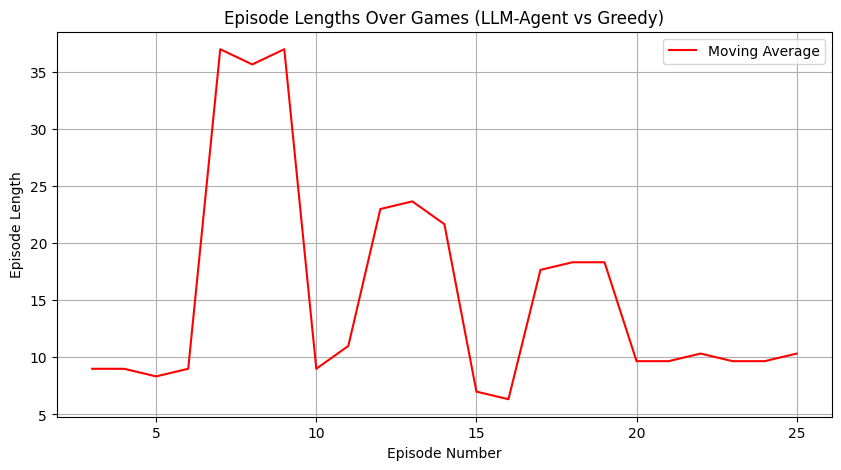

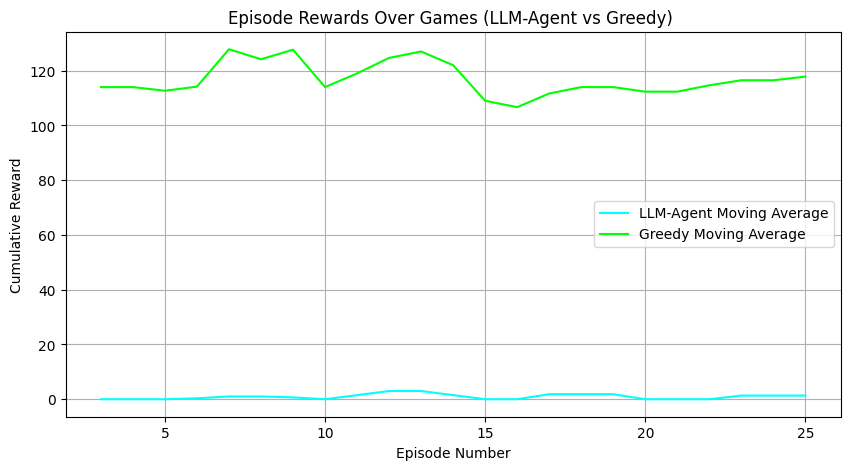

In [ ]:
gap_size=10

# Initialize Environment and Agents
env = gym.make(hyperparams["env"])
enemy_agent = GreedyAgent()
ally_agent = ChineseChessAgent(
    model,
    tokenizer,
    max_input_token,
    device,
    {
        key: value
        for key, value in hyperparams.items()
        if key.startswith("generate/")
    },
    {
        "batch_size": hyperparams["batch_size"],
        "mini_batch_size": hyperparams["batch_size"],
    },
)

# Variables to track statistics
ally_wins, enemy_wins, truncated_game = 0, 0, 0
episode_lengths, ally_rewards, enemy_rewards, winning_rewards = [], [], [], []
training_errors = []


for episode in trange(1, hyperparams["episodes"]+1):
    observation = env.reset()
    round, done = 1, False
    current_ally_rewards, current_enemy_rewards = 0, 0

    while not done:
        if env.turn==ALLY:
          random, ally_action, llm_output = ally_agent.act(observation, episode, round, env)
          _, ally_reward, done, info = env.step(ally_action)
          current_ally_rewards += ally_reward
          ally_agent.assign_reward(ally_reward)

          # Logging move details
          move = action_space_to_move(ally_action)
          piece = PIECE_ID_TO_NAME[move[0]]
          print(f"Episode: {episode} Round: {round}")
          print(f"Ally made the move {piece} from {move[1]} to {move[2]}. Reward: {ally_reward}. Random {random}")
          print("================")

          if episode%gap_size==0:
            print(f"\nEpisode {episode}, Round {round}")
            move = action_space_to_move(ally_action)
            piece = PIECE_ID_TO_NAME[move[0]]
            print(f"Ally made the move {piece} from {move[1]} to {move[2]}. Reward: {ally_reward}. Is Ally's move random: {random}")
            print("================")
            training_log_llm_output("chinese_chess_llm_output_log", episode, round, llm_output)

        else:
          enemy_action = enemy_agent.move(env)
          observation, enemy_reward, done, info = env.step(enemy_action)
          current_enemy_rewards += enemy_reward

          # Logging move details
          move = action_space_to_move(enemy_action)
          piece = PIECE_ID_TO_NAME[move[0]]
          print(f"Episode: {episode} Round: {round}")
          print(f"Enemy made the move {piece} from {move[1]} to {move[2]}. Reward: {enemy_reward} ")
          print("================")

          if episode%gap_size==0:
            print(f"\nEpisode {episode}, Round {round}")
            move = action_space_to_move(enemy_action)
            piece = PIECE_ID_TO_NAME[move[0]]
            print(f"Enemy made the move {piece} from {move[1]} to {move[2]}. Reward: {enemy_reward}")
            print("================")

        round+=1
        if round >= 200:
            print("Episode reached 200 rounds, stopping to prevent infinite loop.")
            done = True
            truncated_game += 1

    episode_lengths.append(round)
    if enemy_reward==100:
      enemy_wins += 1
      winning_rewards.append(current_enemy_rewards)
    elif ally_reward==100:
      ally_wins += 1
      winning_rewards.append(current_ally_rewards)

    ally_rewards.append(current_ally_rewards)
    enemy_rewards.append(current_enemy_rewards)

    episode_stats = {
            "episode": episode,
            "total_return": current_ally_rewards + current_enemy_rewards,
            "ally_return": current_ally_rewards,
            "enemy_return": current_enemy_rewards,
            "message_ct": len(ally_agent.current_episode_messages),
            "episode_messages": ally_agent.current_episode_messages,
            # "loss":
        }

    train_stats = ally_agent.terminate_episode()
    episode_stats.update(train_stats)
    wandb.log(episode_stats)

    if episode%gap_size==0:
      print(f"Episode {episode} ended. Ally Wins: {ally_wins}, Enemy Wins: {enemy_wins}, Truncated Game: {truncated_game} ")
env.close()

print(f"\nFinal score after {episode} episodes -> Ally Wins: {ally_wins}, Enemy Wins: {enemy_wins}, Truncated Game: {truncated_game}")
print(f"Ally Win Rate: {calculate_win_rate(ally_wins, episode)}%")
print(f"Enemy Win Rate: {calculate_win_rate(enemy_wins, episode)}%")
print(f"Truncated Rate: {calculate_win_rate(truncated_game, episode)}%")
print(f"Average Winning Reward per Episode: {average_reward(winning_rewards)}")
print(f"Average Episode Length: {average_episode_length(episode_lengths)}")
print(f"Ally Reward Variability: {reward_variability(ally_rewards)}")
print(f"Enemy Reward Variability: {reward_variability(enemy_rewards)}")
plot_episode_lengths(episode_lengths, ally="LLM-Agent", enemy="Greedy")
plot_episode_rewards(ally_rewards, enemy_rewards, ally="LLM-Agent", enemy="Greedy")


This loss plot from weights and bias also shows that the PPO algorithm was not learning. The total loss is a combination of policy loss and value loss. Ideally, you would expect this to decrease over time as the model learns.



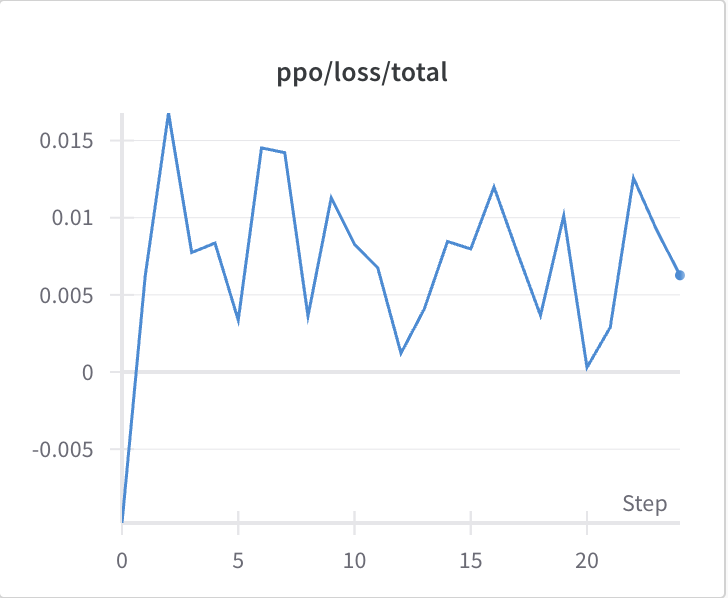

We suspect that the poor performance is due to the model size: opt with 175m parameter is too small to actually learn meaningful things. You can also see from the print outs that the LLM response is mostly unintelligble.

To prove our hypothesis, we ran 5 episodes with Llama 2 with 7 billion parameters to show that a larger model size will give a more relevant response to our prompt.

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp "/content/chinese_chess_token_truncate_log" "/content/drive/MyDrive/Spring 2024 RL/Log"
!cp "/content/chinese_chess_llm_output_log" "/content/drive/MyDrive/Spring 2024 RL/Log"

In [ ]:
# Settings and config for the LLM before we start the training
max_input_token=4096

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hyperparams = {
        "model_name": "meta-llama/Llama-2-7b-chat-hf", #"facebook/opt-125m", "meta-llama/Llama-2-7b-chat-hf"
        "env": "gym_xiangqi:xiangqi-v0",
        "lora/r": 1, #changed to 1 from 16 because gpu spikes
        "lora/lora_alpha": 32,
        "lora/lora_dropout": 0.05,
        "lora/bias": "none",
        "lora/task_type": "CAUSAL_LM",
        "load_in_8bit": True,
        "batch_size": 1,
        "seed": 42069,
        "episodes": 3,
        "generate/max_new_tokens": 50,
        "generate/do_sample": True,
        "generate/top_p": 0.6,
        "generate/top_k": 0,
        "generate/temperature": 0.9,
    }

wandb_run = wandb.init(project=os.environ.get("WANDB_PROJECT"), config=hyperparams)
device = "cuda:0"
# device='cpu'
HF_TOKEN = os.environ.get("HF_TOKEN")

lora_config = LoraConfig(
    **{key.split("/")[-1]: value for key, value in hyperparams.items() if key.startswith("lora/")}
)

model = AutoModelForCausalLMWithValueHead.from_pretrained(
    pretrained_model_name_or_path=hyperparams["model_name"],
    peft_config=lora_config,
    load_in_8bit=hyperparams["load_in_8bit"]
).to(device)

tokenizer = AutoTokenizer.from_pretrained(hyperparams["model_name"])
tokenizer.add_special_tokens({"pad_token": "<pad>"})
model.pretrained_model.resize_token_embeddings(len(tokenizer))

# Save initial parameters for comparison later
initial_params = {name: param.clone().detach() for name, param in model.named_parameters()}

def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"\ntrainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

print(f'PPO model parameters to be updated:\n{print_number_of_trainable_model_parameters(model)}\n')

In [ ]:
gap_size=1

# Initialize Environment and Agents
env = gym.make(hyperparams["env"])
enemy_agent = GreedyAgent()
ally_agent = ChineseChessAgent(
    model,
    tokenizer,
    max_input_token,
    device,
    {
        key: value
        for key, value in hyperparams.items()
        if key.startswith("generate/")
    },
    {
        "batch_size": hyperparams["batch_size"],
        "mini_batch_size": hyperparams["batch_size"],
    },
)

# Variables to track statistics
ally_wins, enemy_wins, truncated_game = 0, 0, 0
episode_lengths, ally_rewards, enemy_rewards, winning_rewards = [], [], [], []
training_errors = []


for episode in trange(1, hyperparams["episodes"]+1):
    observation = env.reset()
    round, done = 1, False
    current_ally_rewards, current_enemy_rewards = 0, 0

    while not done:
        if env.turn==ALLY:
          random, ally_action, llm_output = ally_agent.act(observation, episode, round, env)
          _, ally_reward, done, info = env.step(ally_action)
          current_ally_rewards += ally_reward
          ally_agent.assign_reward(ally_reward)

          # Logging move details
          move = action_space_to_move(ally_action)
          piece = PIECE_ID_TO_NAME[move[0]]
          print(f"Episode: {episode} Round: {round}")
          print(f"Ally made the move {piece} from {move[1]} to {move[2]}. Reward: {ally_reward}. Random {random}")
          print("================")

          if episode%gap_size==0:
            print(f"\nEpisode {episode}, Round {round}")
            move = action_space_to_move(ally_action)
            piece = PIECE_ID_TO_NAME[move[0]]
            print(f"Ally made the move {piece} from {move[1]} to {move[2]}. Reward: {ally_reward}. Is Ally's move random: {random}")
            print("================")
            training_log_llm_output("chinese_chess_llm_output_log", episode, round, llm_output)

        else:
          enemy_action = enemy_agent.move(env)
          observation, enemy_reward, done, info = env.step(enemy_action)
          current_enemy_rewards += enemy_reward

          # Logging move details
          move = action_space_to_move(enemy_action)
          piece = PIECE_ID_TO_NAME[move[0]]
          print(f"Episode: {episode} Round: {round}")
          print(f"Enemy made the move {piece} from {move[1]} to {move[2]}. Reward: {enemy_reward} ")
          print("================")

          if episode%gap_size==0:
            print(f"\nEpisode {episode}, Round {round}")
            move = action_space_to_move(enemy_action)
            piece = PIECE_ID_TO_NAME[move[0]]
            print(f"Enemy made the move {piece} from {move[1]} to {move[2]}. Reward: {enemy_reward}")
            print("================")

        round+=1
        if round >= 200:
            print("Episode reached 200 rounds, stopping to prevent infinite loop.")
            done = True
            truncated_game += 1

    episode_lengths.append(round)
    if enemy_reward==100:
      enemy_wins += 1
      winning_rewards.append(current_enemy_rewards)
    elif ally_reward==100:
      ally_wins += 1
      winning_rewards.append(current_ally_rewards)

    ally_rewards.append(current_ally_rewards)
    enemy_rewards.append(current_enemy_rewards)

    if episode%gap_size==0:
      print(f"Episode {episode} ended. Ally Wins: {ally_wins}, Enemy Wins: {enemy_wins}, Truncated Game: {truncated_game} ")
env.close()

print(f"\nFinal score after {episode} episodes -> Ally Wins: {ally_wins}, Enemy Wins: {enemy_wins}, Truncated Game: {truncated_game}")
print(f"Ally Win Rate: {calculate_win_rate(ally_wins, episode)}%")
print(f"Enemy Win Rate: {calculate_win_rate(enemy_wins, episode)}%")
print(f"Truncated Rate: {calculate_win_rate(truncated_game, episode)}%")
print(f"Average Winning Reward per Episode: {average_reward(winning_rewards)}")
print(f"Average Episode Length: {average_episode_length(episode_lengths)}")
print(f"Ally Reward Variability: {reward_variability(ally_rewards)}")
print(f"Enemy Reward Variability: {reward_variability(enemy_rewards)}")
plot_episode_lengths(episode_lengths, ally="LLM-Agent", enemy="Greedy")
plot_episode_rewards(ally_rewards, enemy_rewards, ally="LLM-Agent", enemy="Greedy")

  0%|          | 0/3 [00:00<?, ?it/s]

Round 1 LLM Prompt: <s>[INST] <<SYS>>
You are an expert Chinese chess player. Your goal is to take your opponent's general piece. Every turn, you'll see the current layout on the board demonstrated by a 10 by 9 numpy array. Each coordinate in the numpy array corresponds to a single coordinate on the board with the value range from -16 to 16, which represents the pieces. Negative integers are enemy pieces, positive integers are your pieces, and 0 means it's empty. Decide what you want your move to be by writing "Action: [Piece_id, (Start_x Start_y), (End_x, End_y)]". Piece_id should be an integer from 1 to 16 which indicates the piece that you want to move. Start should be a tuple with two integers, where the first integer should be from 0 to 9 and the second integer should be from 0 to 8. Start tuple represents where Piece_id is at. End should be a tuple with two integers, where the first integer should be from 0 to 9 and the second integer should be from 0 to 8. End tuple represents w

 33%|███▎      | 1/3 [00:39<01:18, 39.35s/it]

Round 5 LLM Response: Great, let's continue the game! It's my turn again.

Action: 5, (2, 4)

Your move!
Episode: 1 Round: 5
Ally made the move ELEPHANT_1 from [9, 2] to [7, 0]. Reward: 0.0. Random True

Episode 1, Round 5
Ally made the move ELEPHANT_1 from [9, 2] to [7, 0]. Reward: 0.0. Is Ally's move random: True
Episode: 1 Round: 6
Enemy made the move CANNON_2 from [9, 1] to [9, 4]. Reward: 100.0 

Episode 1, Round 6
Enemy made the move CANNON_2 from [9, 1] to [9, 4]. Reward: 100.0
Episode 1 ended. Ally Wins: 0, Enemy Wins: 1, Truncated Game: 0 
Round 1 LLM Prompt: <s>[INST] <<SYS>>
You are an expert Chinese chess player. Your goal is to take your opponent's general piece. Every turn, you'll see the current layout on the board demonstrated by a 10 by 9 numpy array. Each coordinate in the numpy array corresponds to a single coordinate on the board with the value range from -16 to 16, which represents the pieces. Negative integers are enemy pieces, positive integers are your pieces, a

 33%|███▎      | 1/3 [00:40<01:20, 40.47s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 22.00 MiB. GPU 0 has a total capacity of 39.56 GiB of which 14.81 MiB is free. Process 10171 has 39.54 GiB memory in use. Of the allocated memory 38.26 GiB is allocated by PyTorch, and 805.24 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

From the above, with a larger model size of 7B parameters, the LLM's response is much more sensible and a better starting policy for our agent. However, we lack the sufficient GPU RAM to accomodate fine-tuning a model of this size as we experience GPU RAM spikes of 40GB during training using 1 Nvidia A100 GPU (40GB).

Since the results for finetuing the LLM to play Chinese Chess is very suboptimal, we also tried out an easier environment (See [Appendix](#scrollTo=c_gsSkIqM48e&line=1&uniqifier=1) for Frozen Lake).

### Conclusion:

Even when playing a simpler game, our LLM agent appears to perform suboptimally. We believe that limited computing power is the primary cause of this underperformance. With more resources available, we would opt for a significantly larger model, such as the Llama 2 model with 7 billion parameters. Additionally, we would select a higher value for 'lora/r' to allow for more weights to be adjusted specifically for our task.

### Appendix:

Frozen Lake

In [ ]:
class FrozenLakeAgent(Agent):
    def get_system_prompt(self) -> str:
        return """You are an expert Frozen Lake player. Your goal is to cross a 3-by-3 frozen lake grid from start to goal without falling into any holes. You will see your current location in terms of which row and column you are at. Decide whether to move left by writing "Action: 0", moving down by writing "Action: 1", moving right by writing "Action: 2", or moving up by writing "Action: 3"."""

    def format_observation(self, observation: gym.core.ObsType) -> str:
        row = observation//3
        col = observation%3
        if row == 0:
          row_txt = 'first'
        elif row == 1:
          row_txt = 'second'
        else:
          row_txt = 'third'
        if col == 0:
          col_txt = 'first'
        elif col == 1:
          col_txt = 'second'
        else:
          col_txt = 'third'
        return f"You are currently located at the {row_txt} row and the {col_txt} column."

    def extract_action(self, response: str, env: gym.Env) -> gym.core.ActType:
        # print(f"\n response: {response} \n")
        match = re.compile(r"Action: (\d)").search(response)
        if match:
            return int(match.group(1))

        digits = [char for char in response if char.isdigit()]
        if len(digits) == 0 or digits[-1] not in ("0", "1", "2", "3"):
            if "left" in response.lower():
                return False, 0
            elif "down" in response.lower():
                return False, 1
            elif "right" in response.lower():
                return False, 2
            elif "up" in response.lower():
                return False, 3
        return True, 2

In [ ]:
# Settings and config for the LLM before we start the training
max_input_token=2048

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hyperparams = {
        "model_name": "facebook/opt-125m",
        "env": "FrozenLake-v1",
        "lora/r": 32,
        "lora/lora_alpha": 32,
        "lora/lora_dropout": 0.05,
        "lora/bias": "none",
        "lora/task_type": "CAUSAL_LM",
        "load_in_8bit": True,
        "batch_size": 4,
        "seed": 42069,
        "episodes": 3,
        "generate/max_new_tokens": 50,
        "generate/do_sample": True,
        "generate/top_p": 0.6,
        "generate/top_k": 0,
        "generate/temperature": 0.9,
    }

lora_config = LoraConfig(
    **{key.split("/")[-1]: value for key, value in hyperparams.items() if key.startswith("lora/")}
)

model = AutoModelForCausalLMWithValueHead.from_pretrained(
    pretrained_model_name_or_path=hyperparams["model_name"],
    peft_config=lora_config,
    # load_in_8bit=hyperparams["load_in_8bit"]
).to(device)

tokenizer = AutoTokenizer.from_pretrained(hyperparams["model_name"])
tokenizer.add_special_tokens({"pad_token": "<pad>"})
model.pretrained_model.resize_token_embeddings(len(tokenizer))

# Save initial parameters for comparison later
initial_params = {name: param.clone().detach() for name, param in model.named_parameters()}

print(f'PPO model parameters to be updated:\n{print_number_of_trainable_model_parameters(model)}\n')

In [ ]:
record, truncated_game, gap_size_video=True, 0, 500

agent = FrozenLakeAgent(
    model,
    tokenizer,
    max_input_token,
    device,
    {
        key: value
        for key, value in hyperparams.items()
        if key.startswith("generate/")
    },
    {
        "batch_size": hyperparams["batch_size"],
        "mini_batch_size": hyperparams["batch_size"],
    },
)

env = gym.make(hyperparams["env"], desc=["SHF", "FHF", "FFG"], is_slippery=False)
if record:
    env = RecordVideo(env, "./video", episode_trigger=lambda episode: episode % gap_size_video == 0)

for episode in trange(1, hyperparams["episodes"]+1):
    observation = env.reset()
    round, done = 1, False

    while not done:
        random, action, llm_output = agent.act(observation, episode, round, env)
        observation, reward, done, info = env.step(action)
        agent.assign_reward(reward)
        round+=1
        if round >= 200:
            print("Episode reached 200 rounds, stopping to prevent infinite loop.")
            done = True
            truncated_game += 1

    train_stats = agent.terminate_episode()
    if episode%gap_size==0:
      print(f"Episode {episode} ended with {round} rounds. Reward: {reward}")

    # log_training('frozen_lake_log', episode, round, observation, action, reward, llm_output)
env.close()

In [ ]:
!cp "/content/video" "/content/drive/MyDrive/Spring 2024 RL"